# 0.0 IMPORTS

In [1]:
import pandas     as pd
import numpy      as np
import seaborn    as sns
import scikitplot as skplt


import matplotlib.gridspec as gridspec

from matplotlib import pyplot as plt
from scipy      import stats  as ss

from random               import sample
from IPython.core.display import HTML
from IPython.display      import Image

from boruta                  import BorutaPy
from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from catboost                import CatBoostClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.ensemble        import RandomForestRegressor, ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from category_encoders       import TargetEncoder
from feature_engine.encoding import CountFrequencyEncoder

## 0.1 Helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

    
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return  np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))


# compute precision at k
def precision_at_k(data, yhat, k=20000):
    # propensity score
    data['score'] = yhat[:,1].tolist()

    # sort clients by propensity score
    data = data.sort_values('score', ascending=False)

    #reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum()/data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k(data, yhat, k=20000):
    # propensity score
    data['score'] = yhat[:,1].tolist()

    # sort clients by propensity score
    data = data.sort_values('score', ascending=False)

    #reset index
    data = data.reset_index(drop=True)

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum()/data['response'].sum()

    return data.loc[k, 'recall_at_k']


def cross_validation(model, kfold, X_train, y_train):
    precision_list = []
    recall_list = []
    skf = StratifiedKFold(n_splits=kfold)

    for train, test in skf.split(X_train, y_train):
        # test dataset
        X_train_fold = X_train.iloc[train]
        y_train_fold = y_train.iloc[train]

        # validation dataset
        X_test_fold = X_train.iloc[test]
        y_test_fold = y_train.iloc[test]

        # Encoding
        ss = StandardScaler()

        # annual_premium
        X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
        
        mms_age = MinMaxScaler()
        mms_vintage = MinMaxScaler()

        # age (since its distribution is not a normal one)
        X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)

        # vintage
        X_train_fold['vintage'] = mms_vintage.fit_transform(X_train_fold[['vintage']].values)
        
        # gender
        le = LabelEncoder()
        X_train_fold['gender'] = le.fit_transform(X_train_fold['gender'])

        # region_code - Target Enconder
        te = TargetEncoder()
        X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
        X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)

        # vehicle_age - Ordinal Encoding
        vehicle_age_dict = {'below_1_year': 1, 'between_1_2_years': 2, 'over_2_years': 3}
        X_train_fold['vehicle_age'] = X_train_fold['vehicle_age'].map(vehicle_age_dict)

        # policy_sales_channel - Frequency Encoding
        X_train_fold['policy_sales_channel'] = X_train_fold['policy_sales_channel'].astype(str)
        cfe = CountFrequencyEncoder(encoding_method='frequency', variables=['policy_sales_channel'])
        X_train_fold = cfe.fit_transform(X_train_fold)
        
        # annual_premium
        X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)

        # age (since its distribution is not a normal one)
        X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)

        # vintage
        X_test_fold['vintage'] = mms_vintage.transform(X_test_fold[['vintage']].values)

        # gender
        X_test_fold['gender'] = le.transform(X_test_fold['gender'])

        # region_code - Target Enconder
        X_test_fold['region_code'] = X_test_fold['region_code'].astype(str)
        X_test_fold['region_code'] = te.transform(X_test_fold['region_code'])

        # vehicle_age - Ordinal Encoding
        vehicle_age_dict = {'below_1_year': 1, 'between_1_2_years': 2, 'over_2_years': 3}
        X_test_fold['vehicle_age'] = X_test_fold['vehicle_age'].map(vehicle_age_dict)

        # policy_sales_channel - Frequency Encoding
        X_test_fold['policy_sales_channel'] = X_test_fold['policy_sales_channel'].astype(str)
        X_test_fold = cfe.transform(X_test_fold)
        X_test_fold = X_test_fold.replace(np.nan, 0)
        
        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage',
                         'policy_sales_channel', 'previously_insured']
        
        X_train_fold = X_train_fold[cols_selected]
        X_test_fold = X_test_fold[cols_selected]

        # Model training
        model.fit(X_train_fold, y_train_fold)

        # Predicting probability
        yhat = model.predict_proba(X_test_fold)

        df = X_test_fold.copy()
        df['response'] = y_test_fold.copy()

        precision_list.append(precision_at_k(df, yhat))
        recall_list.append(recall_at_k(df, yhat))

    return pd.DataFrame({'Model': type(model).__name__,
                       'Precision at k': np.round(np.mean(precision_list), 4).astype(str) + '+/-' +
                         np.round(np.std(precision_list), 4).astype(str),
                       'Recall at k': np.round(np.mean(recall_list), 4).astype(str) + '+/-' +
                         np.round(np.std(recall_list), 4).astype(str)}, index=[0])


In [3]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sample']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading dataset

In [4]:
data_raw = pd.read_csv('../data/raw/train.csv')

In [5]:
data_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 1.0 ANÁLISE DESCRITIVA

In [6]:
df1 = data_raw.copy()

In [7]:
# columns in snakecase
cols_new = ['id', 'gender', 'age', 'driving_license', 'region_code',
            'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
            'policy_sales_channel', 'vintage', 'response']

df1.columns = cols_new

## 1.1 Data informations

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int64  
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int64  
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


## 1.2 Análise Descritiva

In [9]:
# numerical features
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

# categorical features
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

### 1.2.1 Atributos Numéricos

In [10]:
# Tendência Central - média, mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = (['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 2.0 FEATURE ENGINEERING

In [11]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

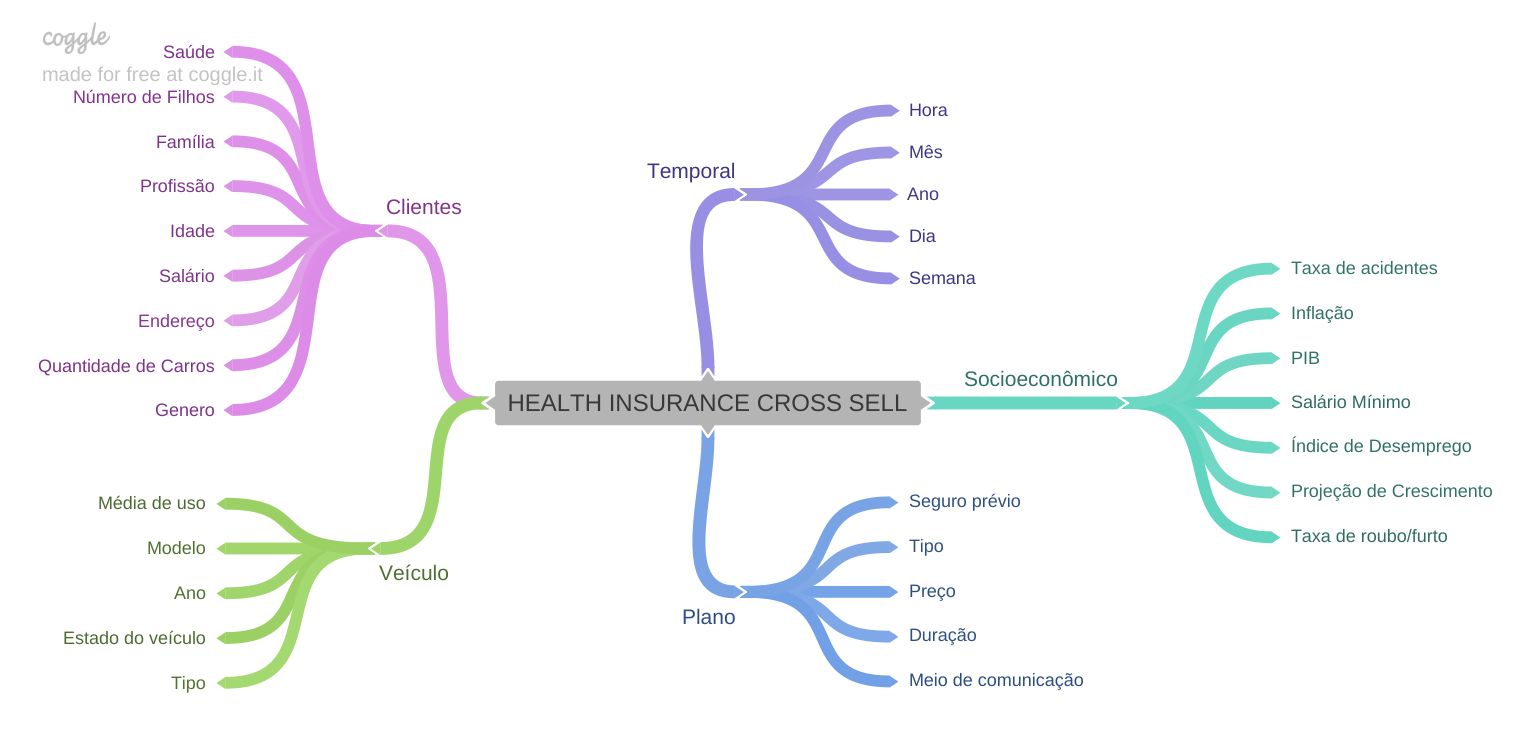

In [12]:
Image('../img/MindMap.png')

## 2.2 Criação de Hipóteses

### 2.2.1 Hipóteses Cliente

**1.** Clientes com mais de 40 anos são mais propensos a contratarem o seguro.

**2.** Clientes sem filhos são mais propensos a contratarem o seguro.

**3.** Clientes mulheres são mais propensas a contratarem o seguro.

**4.** Clientes com carteira de habilitação são mais propensos a contratarem o seguro.

### 2.2.2 Hipóteses Veículo

**1.** Clientes com veículo que apresenta algum dano são mais propensos a contratarem o seguro.

**2.** Clientes com veículos mais novos são mais propensos a contratarem o seguro.

**3.** Clientes que usam o veículo em mais dias da semana são mais propensos a contratarem o seguro.

### 2.2.3 Hipóteses Temporal

**1.** Clientes contatados no mês de janeiro são menos propensos a contratarem o seguro.

**2.** Clientes contatados na sexta-feira são menos propensos a contratarem o seguro.

**3.** Clientes contatados depois do meio dia são menos propensos a contratarem o seguro.

### 2.2.4 Hipóteses Plano

**1.** Clientes com annual premium maior são mais propensos a contratarem o seguro.

**2.** Clientes mais antigos são mais propensos a contratarem o seguro.

**3.** Clientes contatados por um determinado meio de comunicação são mais propensos a contratarem o seguro.

**4.** Clientes que já possuem seguro de veículo são menos propensos a contratarem o seguro.

### 2.2.5 Hipóteses Socioeconômico

**1.** Clientes que moram em regiões com maior taxa de acidentes são mais propensos a contratarem o seguro.

**2.** Clientes que moram em regiões com maior taxa de furto/roubo são mais propensos a contratarem o seguro.

**3.** Clientes que moram em regiões com menor índice de desemprego são mais propensos a contratarem o seguro.

## 2.3 Lista Final de Hipóteses

**1.** Clientes com mais de 40 anos são mais propensos a contratarem o seguro.

**2.** Clientes mulheres são mais propensas a contratarem o seguro.

**3.** Clientes com carteira de habilitação são mais propensos a contratarem o seguro.

**4.** Clientes com veículo que apresenta algum dano são mais propensos a contratarem o seguro.

**5.** Clientes com veículos mais novos são mais propensos a contratarem o seguro.

**6.** Clientes com planos mais caros são mais propensos a contratarem o seguro.

**7.** Clientes mais antigos são mais propensos a contratarem o seguro.

**8.** Clientes contatados por um determinado meio de comunicação são mais propensos a contratarem o seguro.

**9.** Clientes que já possuem seguro de veículo são menos propensos a contratarem o seguro.

**10.** Clientes que moram em regiões com maior taxa de acidentes são mais propensos a contratarem o seguro.

## 2.4 Feature Enginnering

In [13]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else
                                              'between_1_2_years' if x == '1-2 Year' else 'below_1_year')

# vehicle damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0 FILTRAGEM DOS DADOS

In [14]:
df3 = df2.copy()

# 4.0 ANÁLISE EXPLORATÓRIA DOS DADOS

In [15]:
df4 = df3.copy()

## 4.1 Análise Univariada

### Variáveis Numéricas

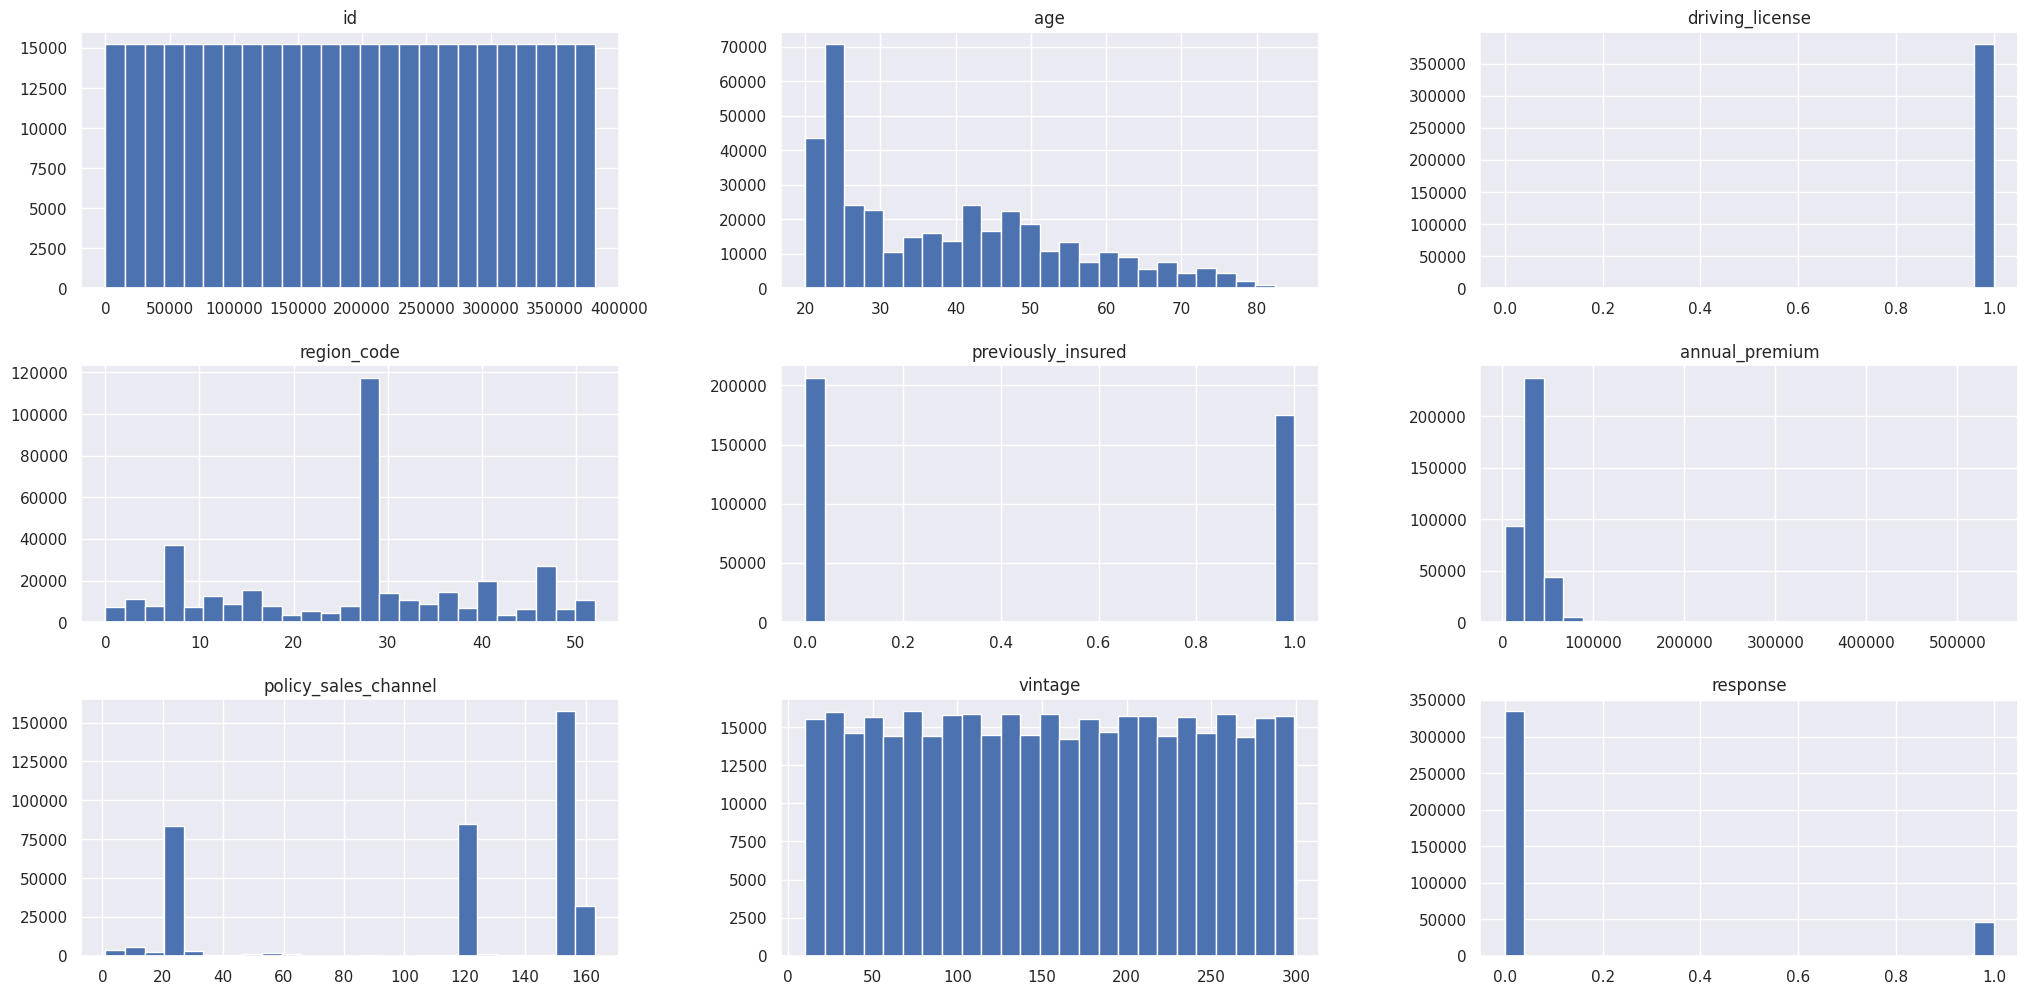

In [16]:
num_attributes.hist(bins=25);

### Variáveis Categóricas

## 4.2 Análise Bivariada

### H1. Clientes com mais de 40 anos são mais propensos a contratarem o seguro.
***VERDADEIRA.*** Clientes entre 40 e 50 anos são mais propensos a contratarem o seguro.

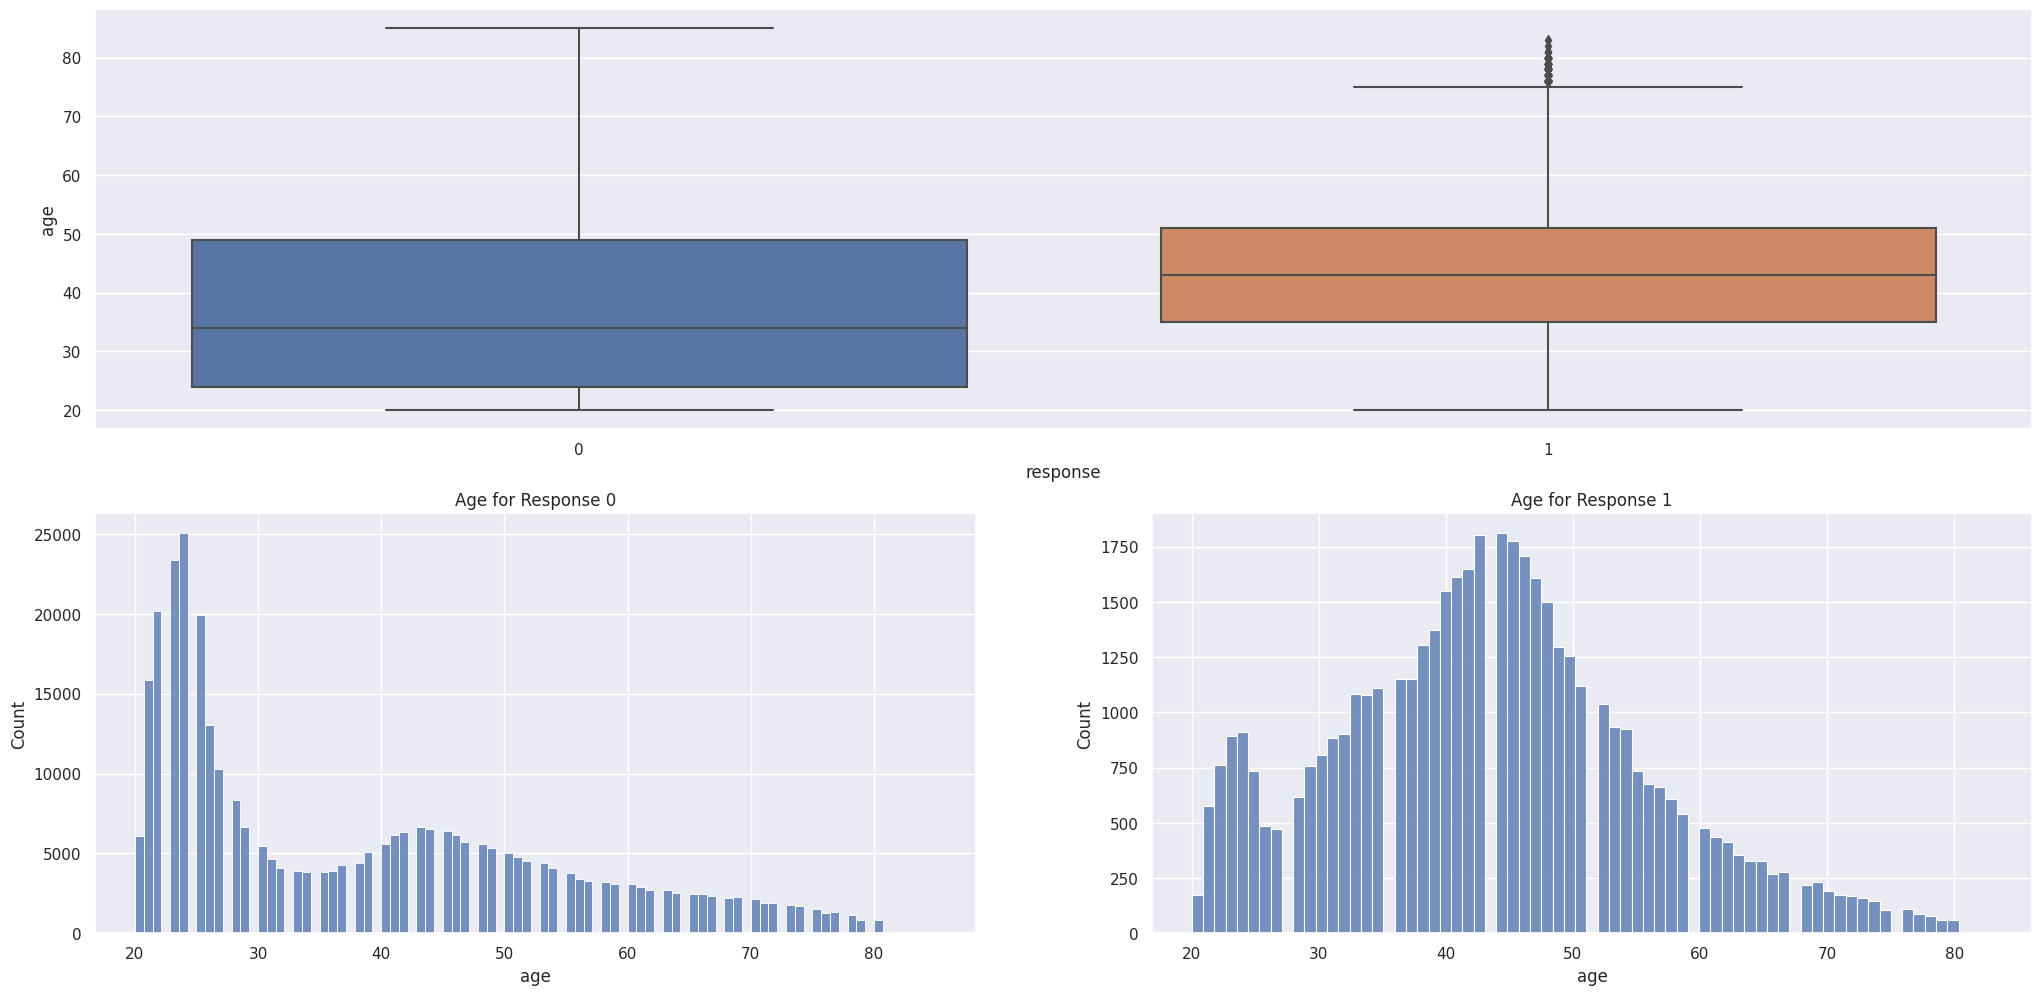

In [15]:
# 'age'
G = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(G[0, :])
sns.boxplot(x='response', y='age', data=df4, ax=ax1)

ax2 = plt.subplot(G[1, 0])
sns.histplot(data=df4[df4['response'] == 0], x='age', ax=ax2)
plt.title('Age for Response 0')

ax3 = plt.subplot(G[1, 1])
sns.histplot(data=df4[df4['response'] == 1], x='age', ax=ax3)
plt.title('Age for Response 1');

### **H2.** Clientes mulheres são mais propensas a contratarem o seguro.
***FALSA.*** Clientes HOMENS são mais propensos a contratarem o seguro.

gender,Female,Male
response,,
0,0.469006,0.530994
1,0.389317,0.610683


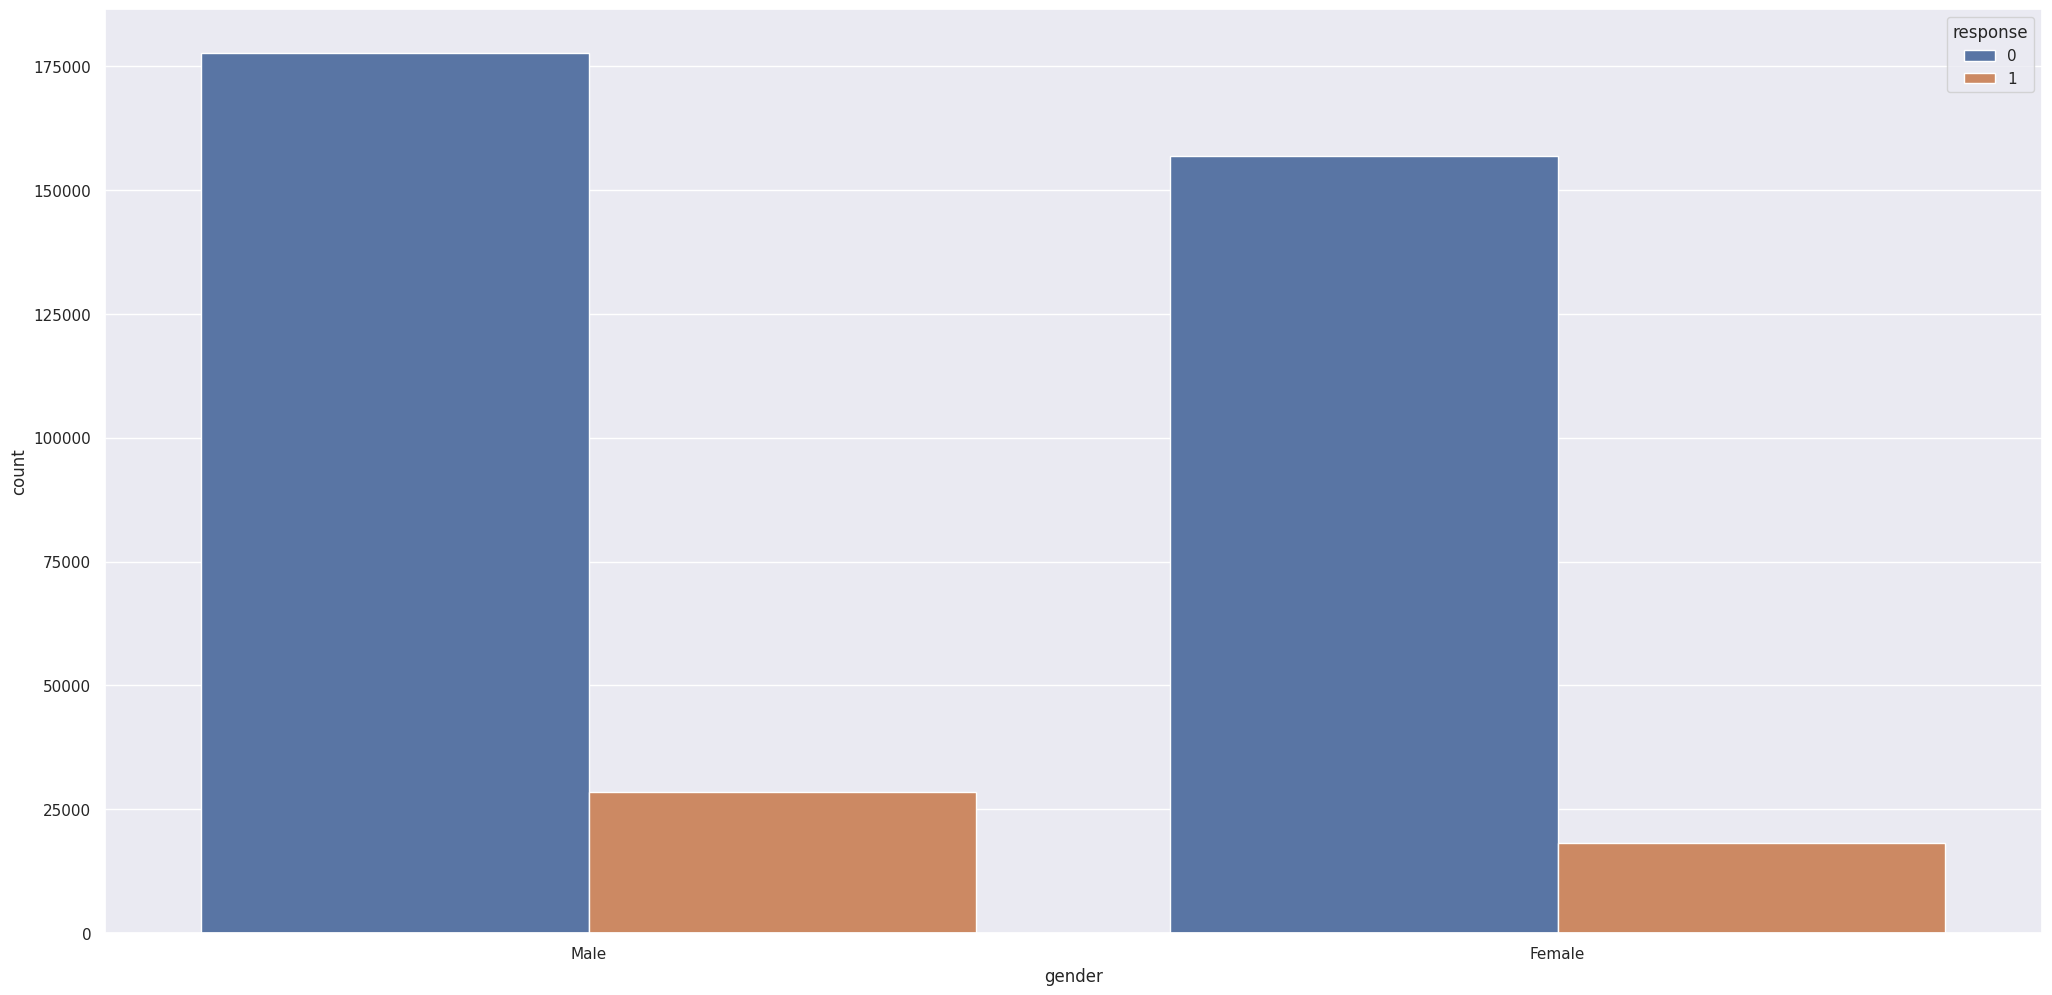

In [16]:
# 'gender'
sns.countplot(x=df4['gender'], hue=df4['response'])

pd.crosstab(df4['response'], df4['gender']).apply(lambda x: x/x.sum(), axis=1)

### **H3.** Clientes com carteira de habilitação são mais propensos a contratarem o seguro.
***VERDADEIRA.*** Clientes com CARTEIRA DE HABILITAÇÃO são mais propensos a contratarem o seguro.

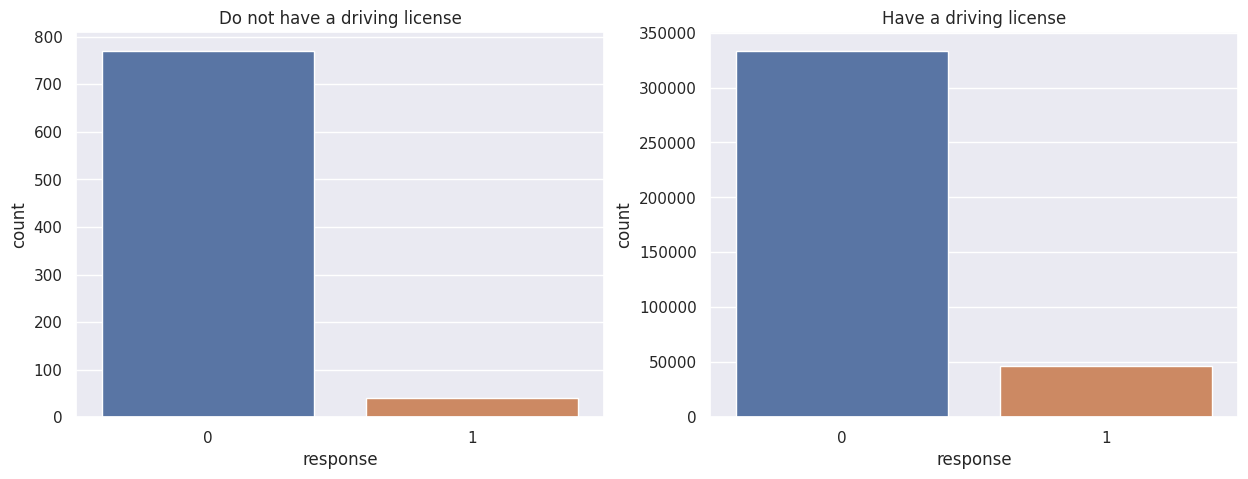

In [17]:
# 'driving_license'
plt.figure(figsize=(15, 5))
G = gridspec.GridSpec(1, 2)

ax1 = plt.subplot(G[0, 0])
sns.countplot(x='response', data=df4[df4['driving_license'] == 0], ax=ax1)
plt.title('Do not have a driving license')

ax2 = plt.subplot(G[0, 1])
sns.countplot(x='response', data=df4[df4['driving_license'] == 1], ax=ax2)
plt.title('Have a driving license');

### **H4.** Clientes com veículo que apresenta algum dano são mais propensos a contratarem o seguro.
***VERDADEIRA.*** Clientes com veículos que aprensentam algum DANO são mais propensos a contratarem o seguro.

response,0,1
vehicle_damage,,
0,0.994796,0.005204
1,0.762345,0.237655


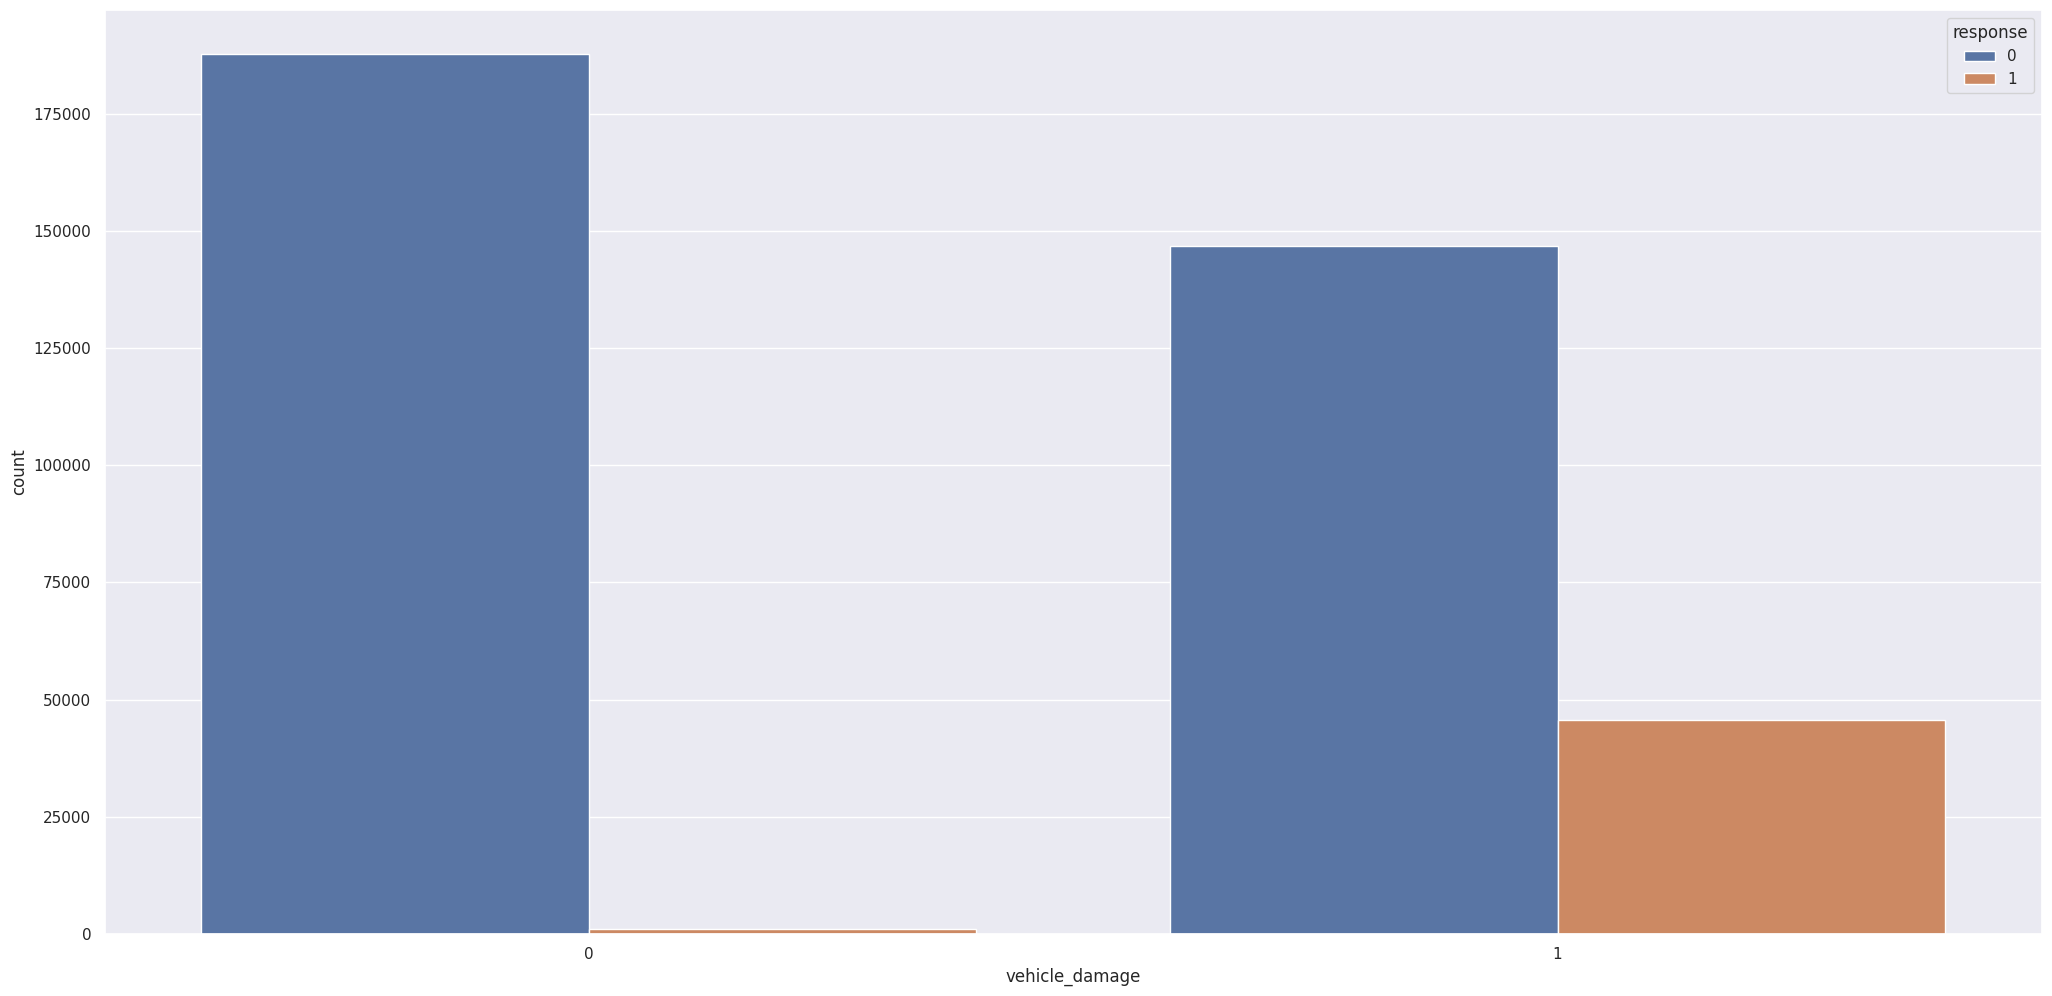

In [21]:
# 'vehicle_damage'
sns.countplot(x=df4['vehicle_damage'], hue=df4['response'])

pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

### **H5.** Clientes com veículos mais novos são mais propensos a contratarem o seguro.
***FALSA.*** Clientes com veículos entre 1 e 2 anos são mais propensos a contratarem o seguro.

,vehicle_age,response,0
0,between_1_2_years,0,0.434285
1,below_1_year,0,0.413488
2,between_1_2_years,1,0.091328
3,over_2_years,0,0.029663
4,below_1_year,1,0.018897
5,over_2_years,1,0.012338


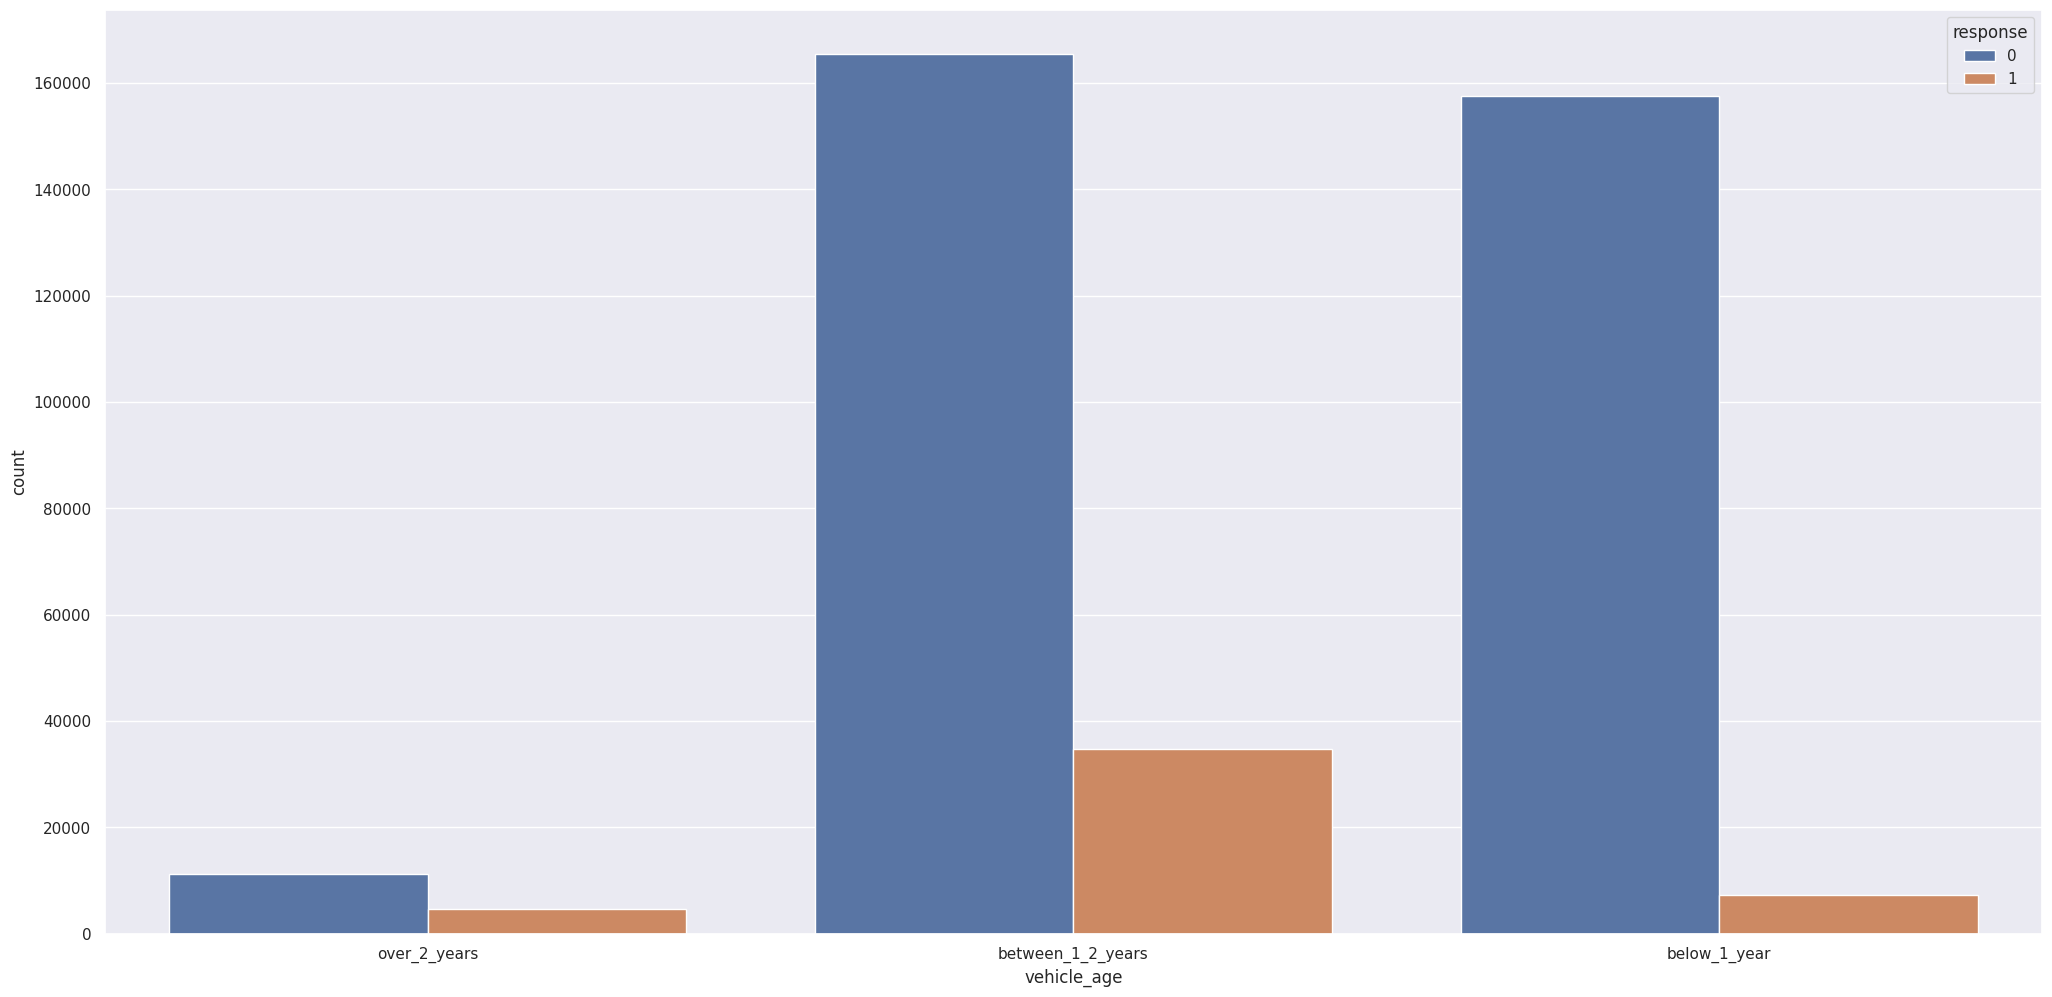

In [24]:
# 'vehicle_age'
sns.countplot(x=df4['vehicle_age'], hue=df4['response'])

df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

### **H6.** Clientes com planos mais caros são mais propensos a contratarem o seguro.
***FALSA.*** Clientes com planos em torno de 30000 (valores intermediários) rúpias são mais propensos a contratarem o seguro.

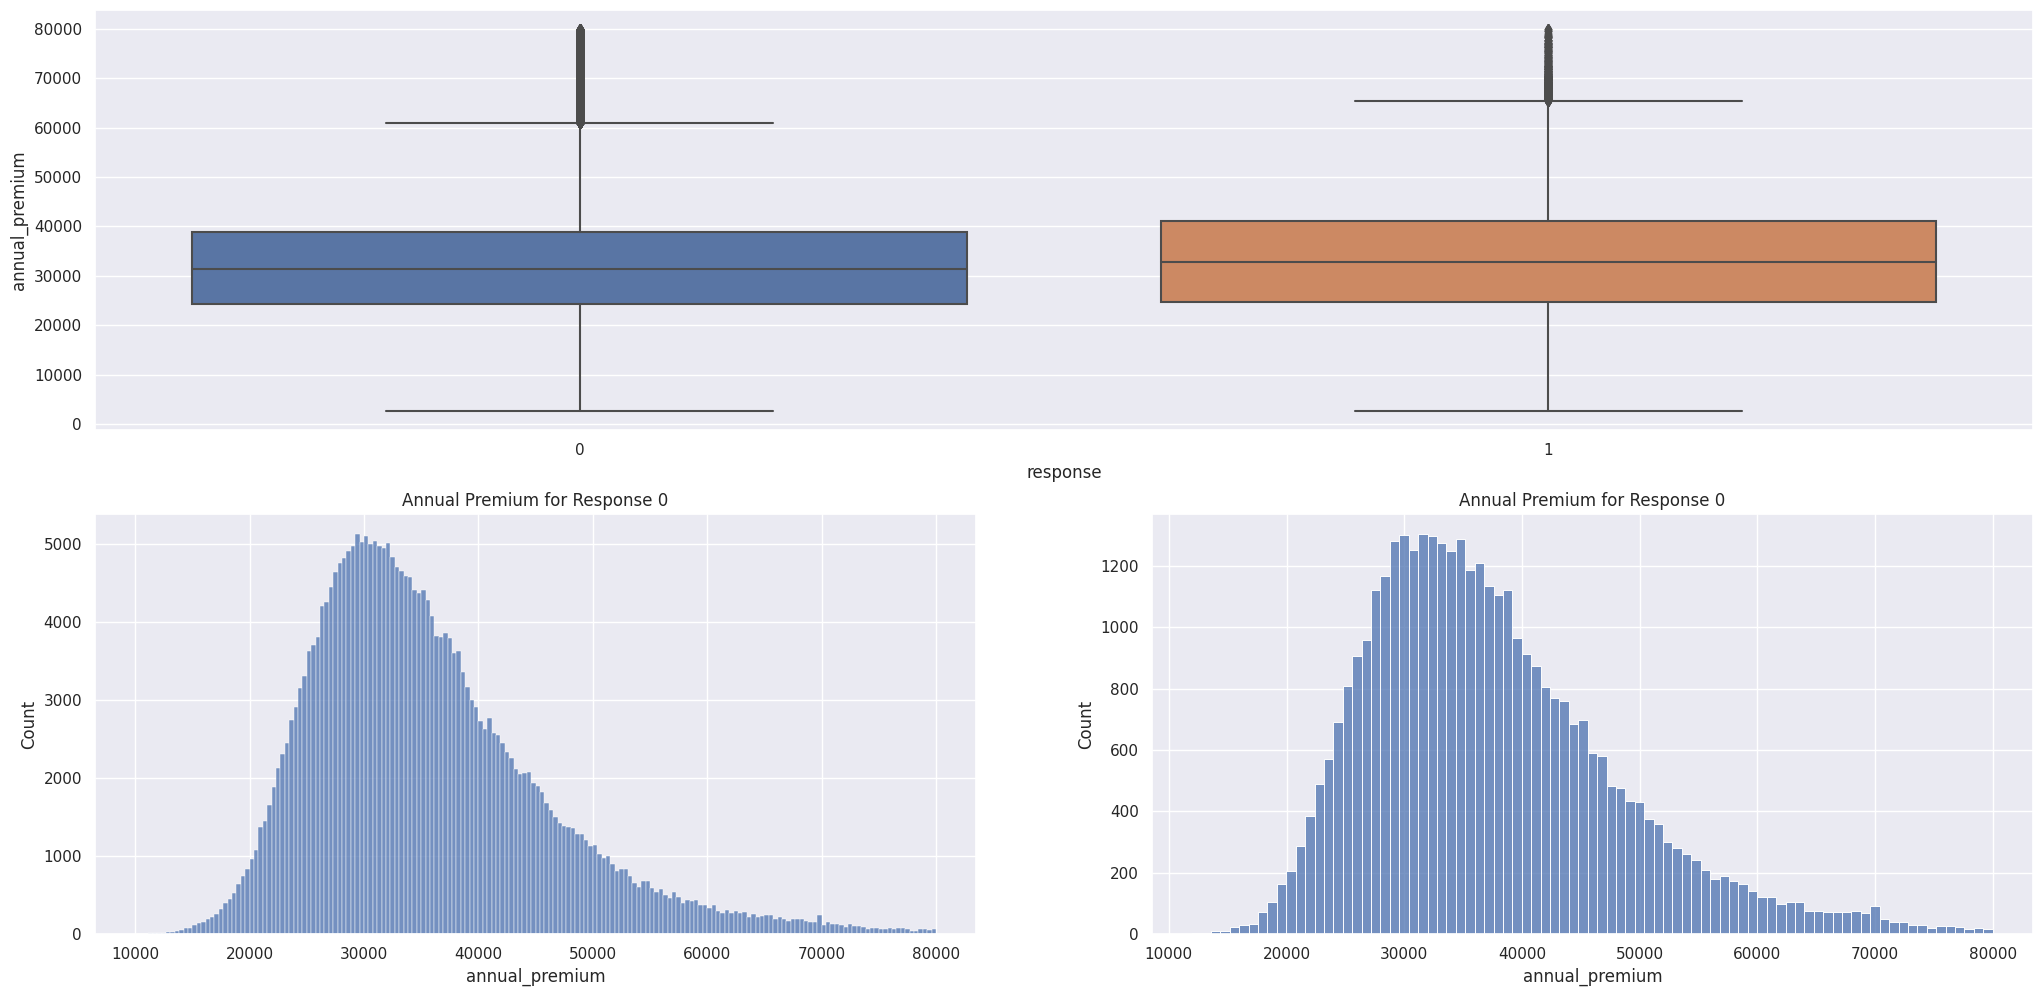

In [22]:
# 'annual_premium'
G = gridspec.GridSpec(2, 2)

aux = df4[df4['annual_premium'] < 80000]
ax1 = plt.subplot(G[0, :])
sns.boxplot(x='response', y='annual_premium', data=aux, ax=ax1)

# Removing outliers for better visualization
aux2 = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]

ax2 = plt.subplot(G[1, 0])
sns.histplot(data=aux2[aux2['response'] == 0], x='annual_premium', ax=ax2)
plt.title('Annual Premium for Response 0')

ax3 = plt.subplot(G[1, 1])
sns.histplot(data=aux2[aux2['response'] == 1], x='annual_premium', ax=ax3)
plt.title('Annual Premium for Response 1');

### **H7.** Clientes mais antigos são mais propensos a contratarem o seguro.
***FALSA.*** Clientes mais antigos não apresentam maior propensão que clientes novos.

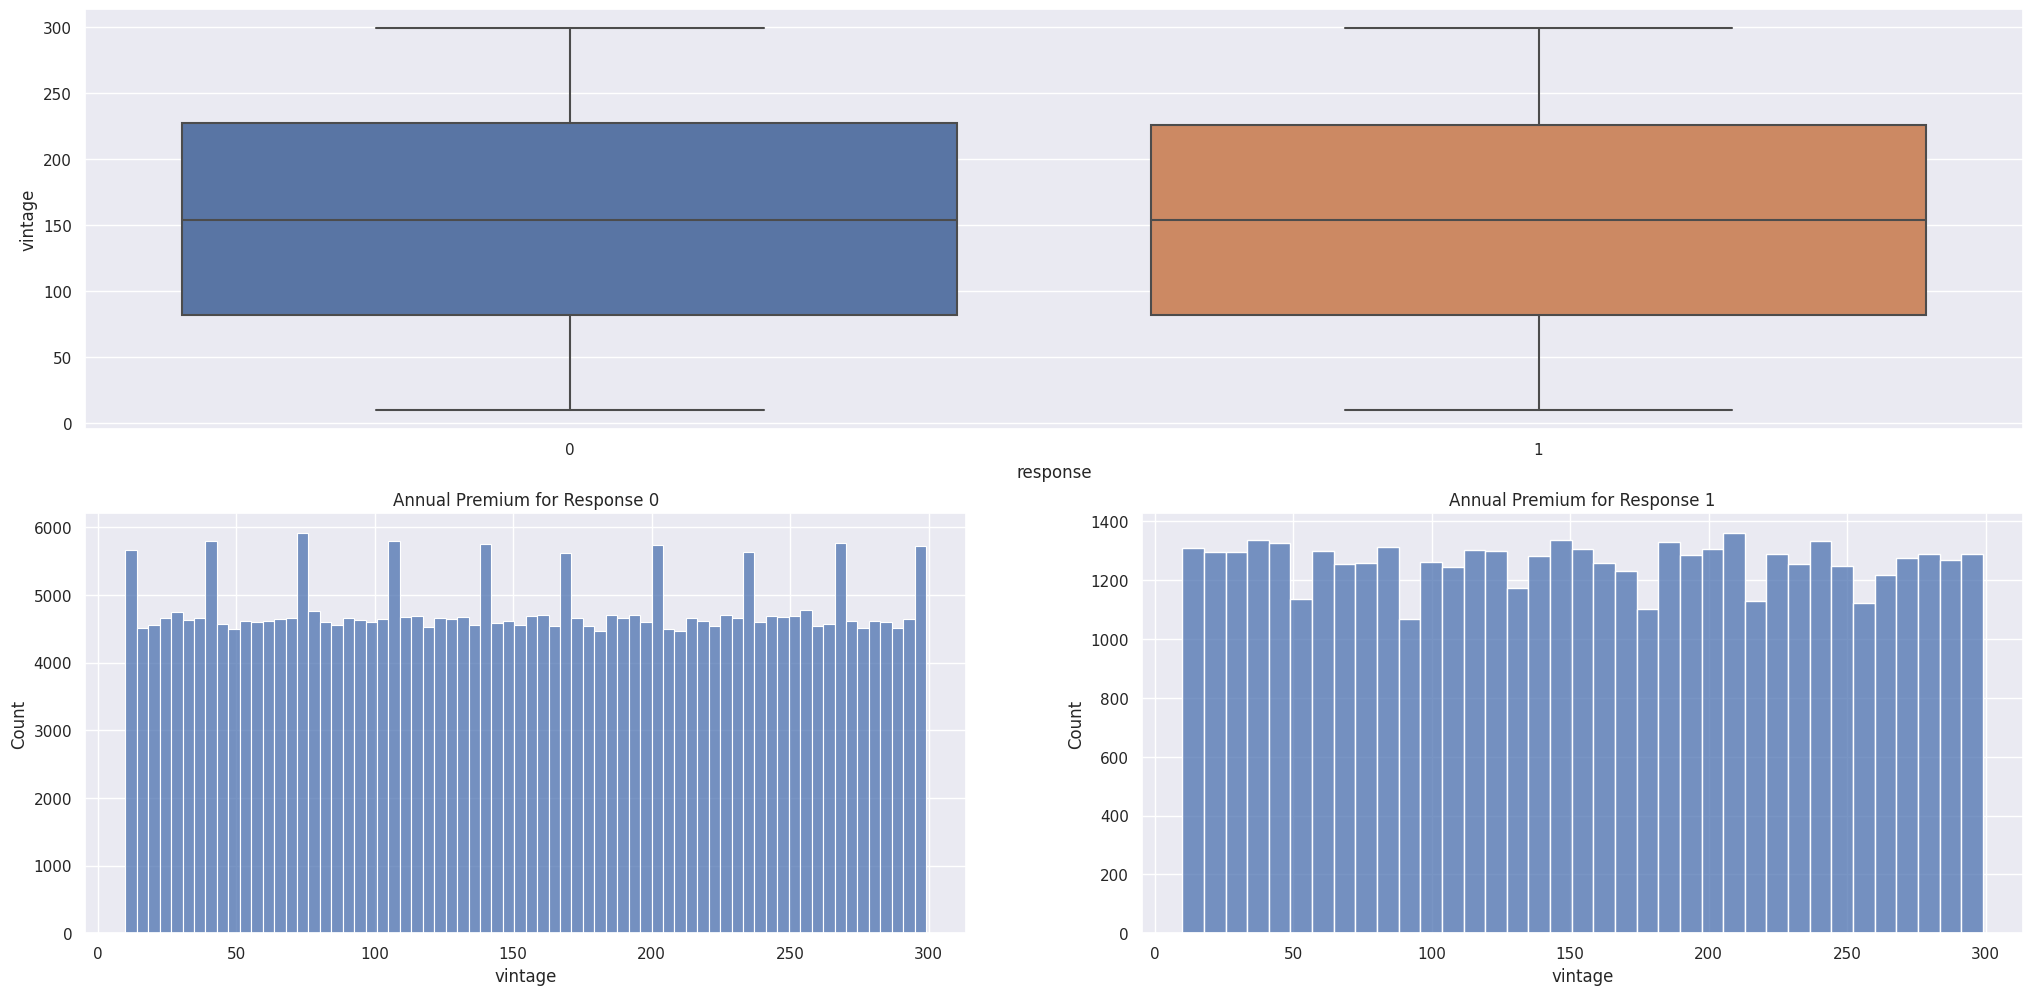

In [24]:
# 'vintage'
G = gridspec.GridSpec(2, 2)

ax1 = plt.subplot(G[0, :])
sns.boxplot(x=df4['response'], y=df4['vintage'])

ax2 = plt.subplot(G[1, 0])
sns.histplot(data=df4[df4['response'] == 0], x='vintage', ax=ax2)
plt.title('Annual Premium for Response 0')

ax3 = plt.subplot(G[1, 1])
sns.histplot(data=df4[df4['response'] == 1], x='vintage', ax=ax3)
plt.title('Annual Premium for Response 1');

### **H8.** Clientes contatados por um determinado meio de comunicação são mais propensos a contratarem o seguro.
***VERDADEIRA.*** Clientes contatados por determinados meios de comunicação sao mais propensos a contratarem o seguro.

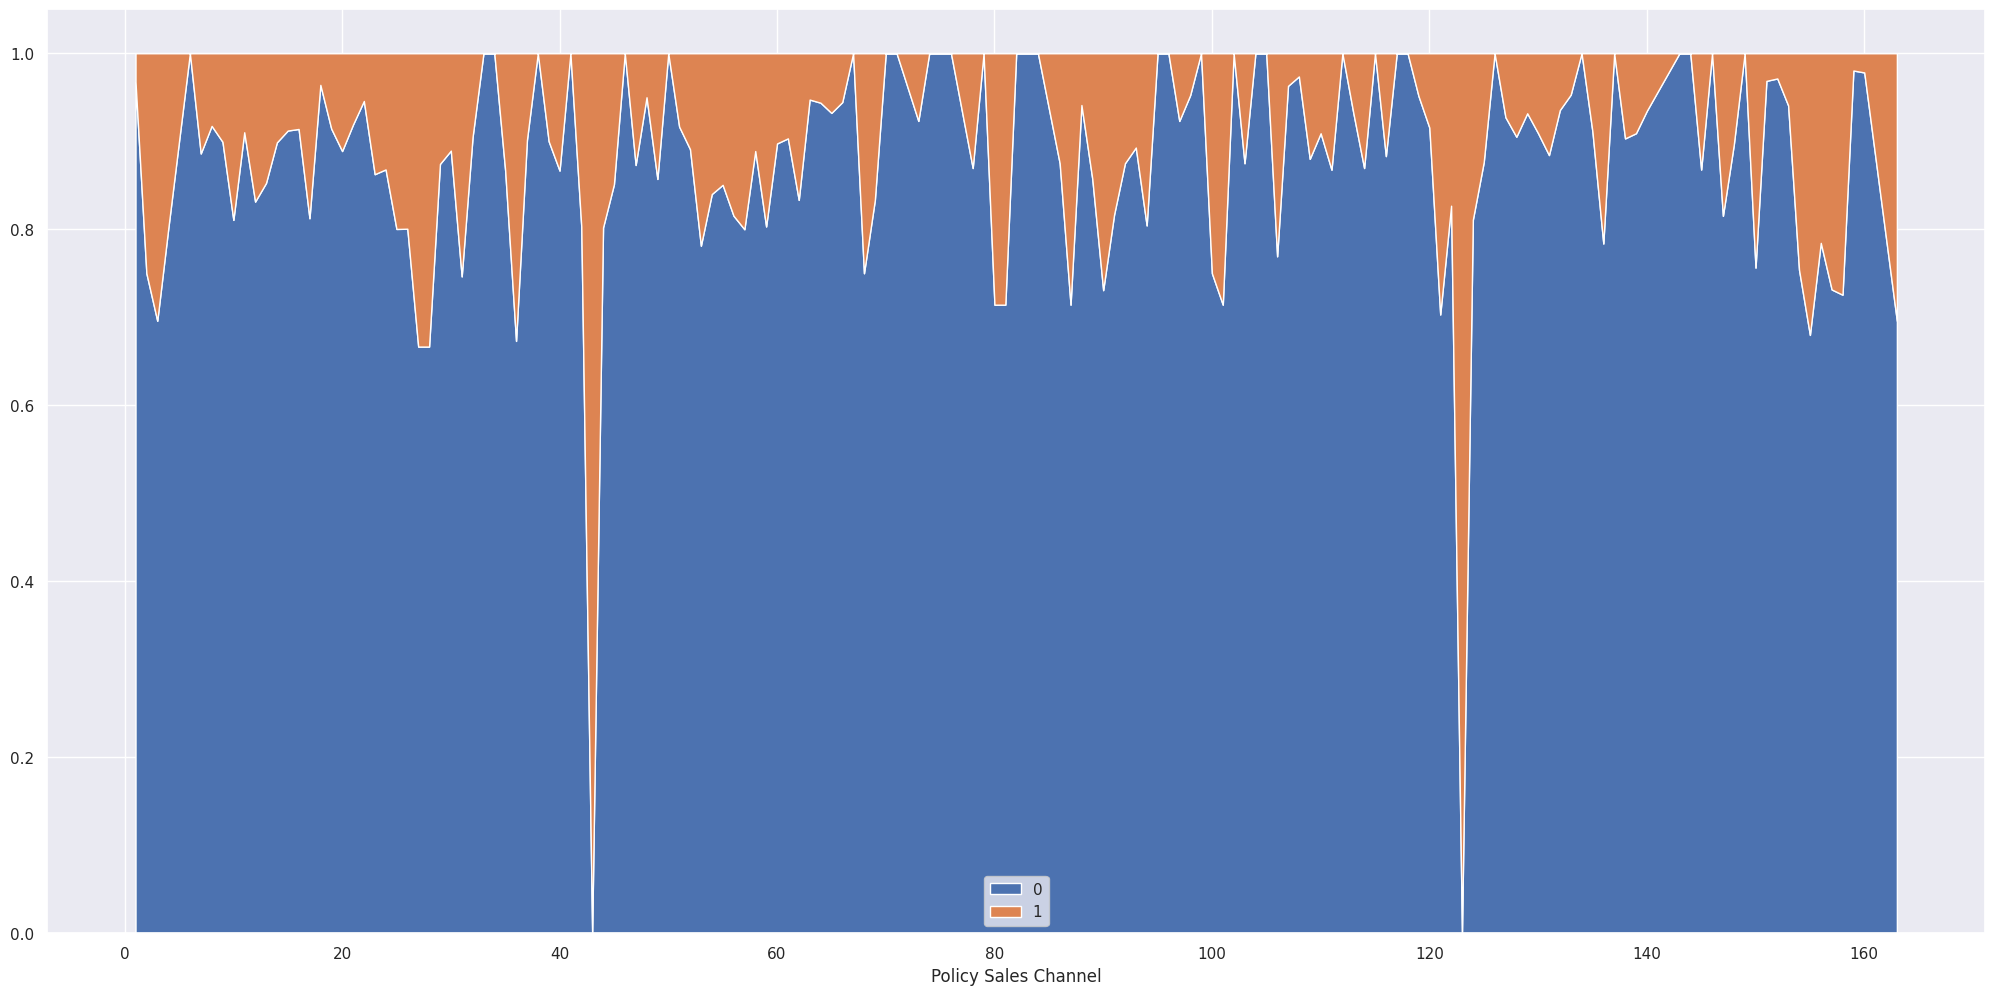

In [23]:
# 'policy_sales_channel'
aux1 = pd.crosstab(df4['policy_sales_channel'], df4['response']).apply(lambda x: x/x.sum(), axis=1).reset_index()

x = aux1['policy_sales_channel']
y1=aux1[0]
y2=aux1[1]

plt.stackplot(x, y1, y2, labels=['0', '1'])
plt.xlabel('Policy Sales Channel')
plt.legend(loc='lower center');

### **H9.** Clientes que já possuem seguro de veículo são menos propensos a contratarem o seguro.
***VERDADEIRA.*** Clientes que não possuem seguro de veículo são mais propensos a contratarem o seguro.

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


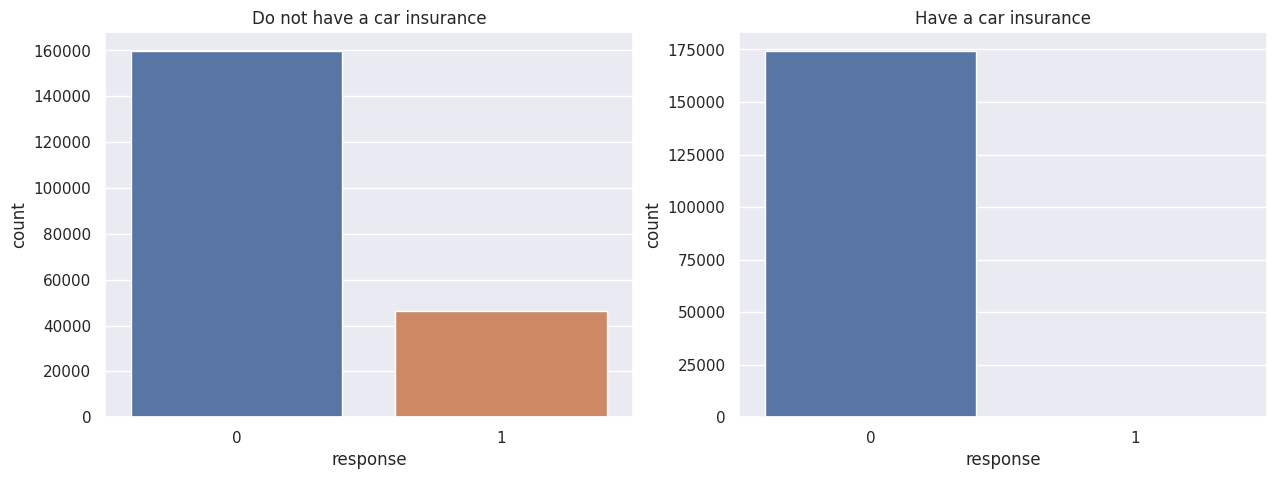

In [19]:
# 'previously_insured'
plt.figure(figsize=(15, 5))
G = gridspec.GridSpec(1, 2)

ax1 = plt.subplot(G[0, 0])
sns.countplot(x='response', data=df4[df4['previously_insured'] == 0], ax=ax1)
plt.title('Do not have a car insurance')

ax2 = plt.subplot(G[0, 1])
sns.countplot(x='response', data=df4[df4['previously_insured'] == 1], ax=ax2)
plt.title('Have a car insurance');

# percentage
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

### **H10.** Clientes que moram em regiões com maior taxa de acidentes são mais propensos a contratarem o seguro.
***INDETERMINADA.*** Uma região apresenta mais clientes propensos, mas é a região com mais clientes no total e não é possível saber a situação socioeconômica da região.

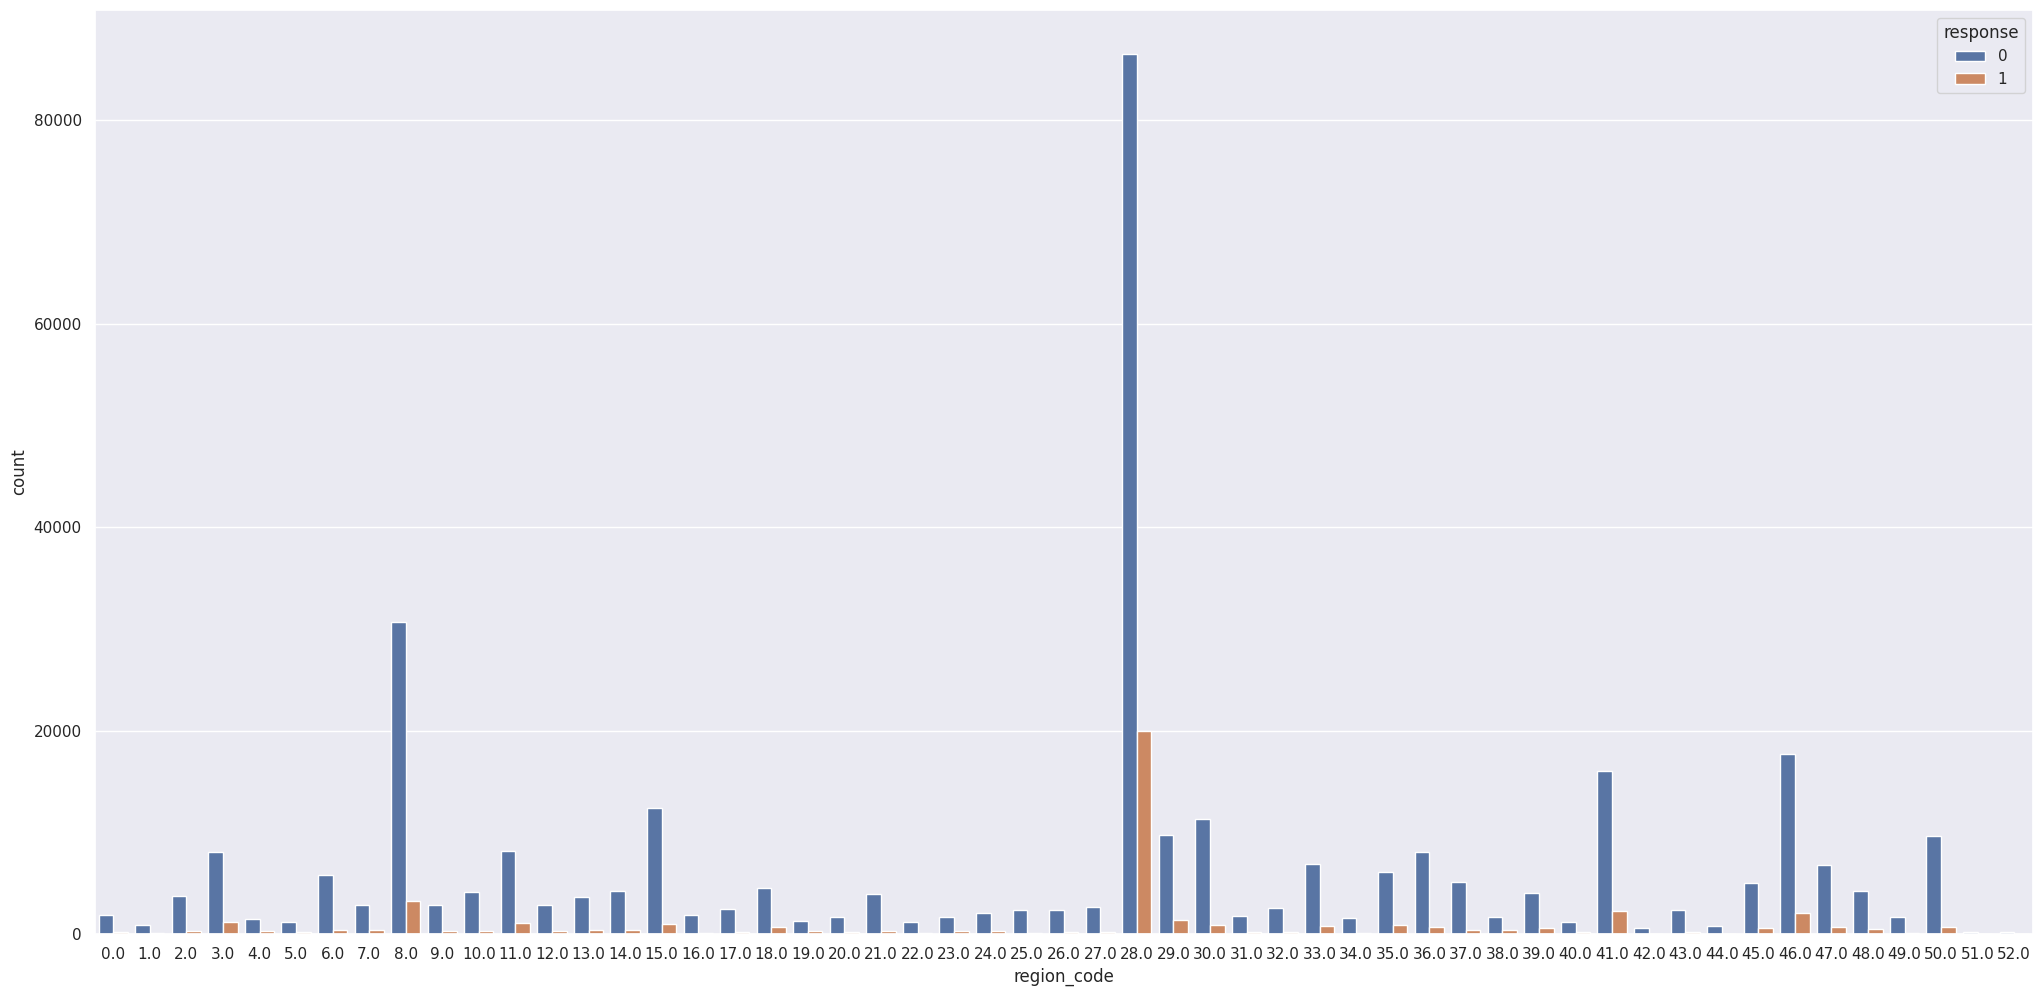

In [18]:
# 'region_code'
sns.countplot(x='region_code', hue='response', data=df4);

## 4.3 Resumo das Hipóteses

| Hipóteses | Conclusão | Relevância |
|-------|-------|-----|
H1| Verdadeira | Média
H2| Falsa | Baixa
H3| Verdadeira | Alta
H4| Verdadeira | Alta
H5| Falsa | Baixa
H6| Falsa | Baixa
H7| Falsa | Baixa
H8| Verdadeira | Alta
H9| Verdadeira | Alta
H10| Indeterminada | Alta


## 4.4 Análise Multivariada

### Atributos Numéricos

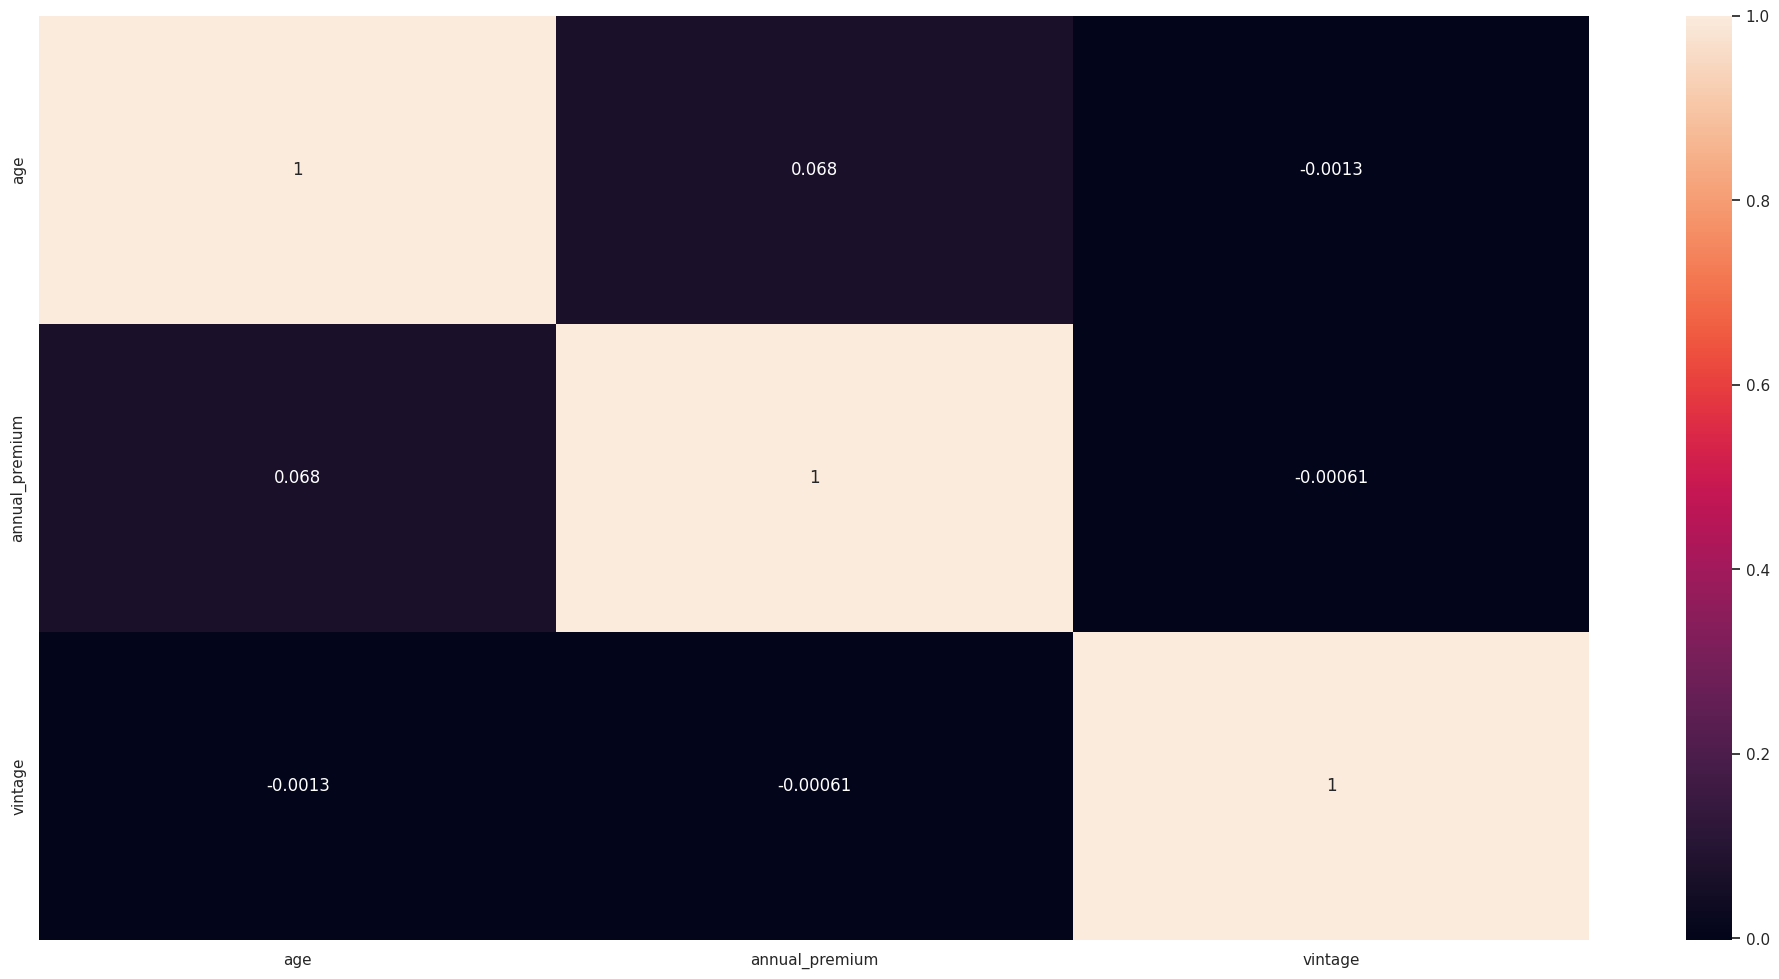

In [55]:
correlation = df4[['age', 'annual_premium', 'vintage']].corr(method='pearson')
sns.heatmap(correlation, annot=True);

In [26]:
df4.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


### Atributos Categóricos

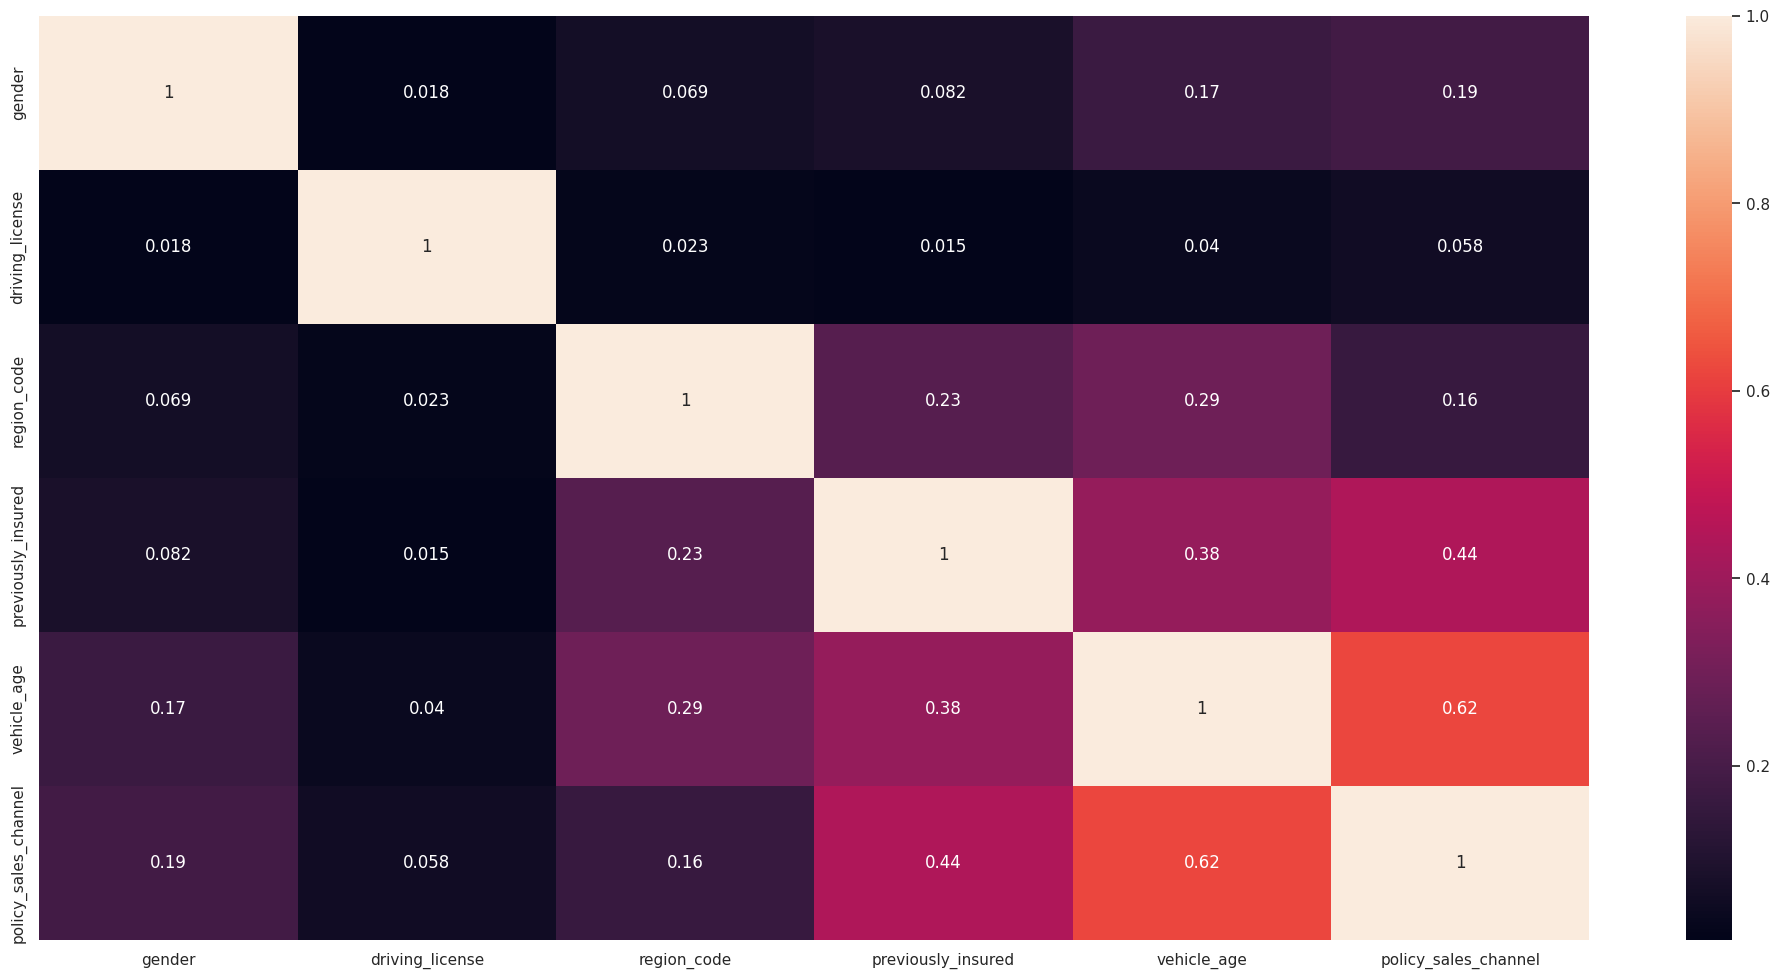

In [51]:
aux = df4[['gender', 'driving_license', 'region_code', 'previously_insured', 'vehicle_age', 'policy_sales_channel']]

aux2 = pd.DataFrame()

for col1 in aux.columns:
    cramer_list = []
    for col2 in aux.columns:
        cramer_list.append(cramer_v(aux[col1], aux[col2]))
    aux2[col1] = cramer_list

aux2 = aux2.set_index(aux2.columns)
sns.heatmap(aux2, annot=True);

# 5.0 DATA PREPARATION

## 5.1 Data Split 

In [83]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=26)

# Cross validation
X_train_cv = X_train.copy()
y_train_cv = y_train.copy()

# Metrics
data_metrics = X_val.copy()
data_metrics['response'] = y_val.copy()

## Standardization

In [84]:
ss = StandardScaler()

# annual_premium
X_train['annual_premium'] = ss.fit_transform(X_train[['annual_premium']].values)

## Rescaling

In [85]:
mms_age = MinMaxScaler()
mms_vintage = MinMaxScaler()

# age (since its distribution is not a normal one)
X_train['age'] = mms_age.fit_transform(X_train[['age']].values)

# vintage
X_train['vintage'] = mms_vintage.fit_transform(X_train[['vintage']].values)

## Encoder

In [86]:
# gender
le = LabelEncoder()
X_train['gender'] = le.fit_transform(X_train['gender'])


# region_code - Target Enconder
te = TargetEncoder()
X_train['region_code'] = X_train['region_code'].astype(str)
X_train['region_code'] = te.fit_transform(X_train['region_code'], y_train)


# vehicle_age - Ordinal Encoding
vehicle_age_dict = {'below_1_year': 1, 'between_1_2_years': 2, 'over_2_years': 3}
X_train['vehicle_age'] = X_train['vehicle_age'].map(vehicle_age_dict)


# policy_sales_channel - Frequency Encoding
X_train['policy_sales_channel'] = X_train['policy_sales_channel'].astype(str)
cfe = CountFrequencyEncoder(encoding_method='frequency', variables=['policy_sales_channel'])
X_train = cfe.fit_transform(X_train)

/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


## Validation Encoding

In [87]:
# annual_premium
X_val['annual_premium'] = ss.transform(X_val[['annual_premium']].values)

# age (since its distribution is not a normal one)
X_val['age'] = mms_age.transform(X_val[['age']].values)

# vintage
X_val['vintage'] = mms_vintage.transform(X_val[['vintage']].values)

# gender
X_val['gender'] = le.transform(X_val['gender'])

# region_code - Target Enconder
X_val['region_code'] = X_val['region_code'].astype(str)
X_val['region_code'] = te.transform(X_val['region_code'])

# vehicle_age - Ordinal Encoding
vehicle_age_dict = {'below_1_year': 1, 'between_1_2_years': 2, 'over_2_years': 3}
X_val['vehicle_age'] = X_val['vehicle_age'].map(vehicle_age_dict)

# policy_sales_channel - Frequency Encoding
X_val['policy_sales_channel'] = X_val['policy_sales_channel'].astype(str)
X_val = cfe.transform(X_val)
X_val = X_val.replace(np.nan, 0)

/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:210: UserWarning: During the encoding, NaN values were introduced in the feature(s) policy_sales_channel.
  warnings.warn(


# 6.0 FEATURE SELECTION

## 6.1 Boruta Selection

In [34]:
# training and test dataset for Boruta
X_train_b = X_train.drop(['id', 'region_code'], axis=1).values
y_train_b = y_train.values.ravel()

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_b, y_train_b)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	8
Iteration:

In [36]:
cols_selected = boruta.support_.tolist()

# best features
X_train_fs = X_train.drop(['id', 'region_code'], axis=1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
cols_not_selected_boruta = np.setdiff1d(X_train_fs.columns, cols_selected_boruta)

In [42]:
print(f'Cols selected:{cols_selected_boruta}')
print(f'Cols not selected: {cols_not_selected_boruta}')

Cols selected:['vehicle_damage']
Cols not selected: ['age' 'annual_premium' 'driving_license' 'gender' 'policy_sales_channel'
 'previously_insured' 'region_code_encoded' 'vehicle_age' 'vintage']


## 6.2 Features Importance

In [45]:
# Model
forest = ExtraTreesClassifier(n_estimators=250, n_jobs=-1)

# data preparation
X_train_n = X_train.drop(['id', 'region_code'], axis=1)
y_train_n = y_train.values

forest.fit(X_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1)

In [46]:
# Print the feature ranking
print('Features ranking:')
df = pd.DataFrame()

for i, j in zip(X_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature':i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)
    
print(df.sort_values('importance', ascending=False))

Features ranking:
                feature  importance
0               vintage    0.278095
0        annual_premium    0.246704
0                   age    0.157871
0   region_code_encoded    0.105943
0        vehicle_damage    0.071834
0  policy_sales_channel    0.060828
0    previously_insured    0.056785
0           vehicle_age    0.016155
0                gender    0.005294
0       driving_license    0.000489


In [22]:
cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage',
                 'policy_sales_channel', 'previously_insured']

# 7.0 MACHINE LEARNING

In [88]:
x_train = X_train[cols_selected]
x_val = X_val[cols_selected]

In [89]:
df7 = X_val.copy()
df7['response'] = y_val.copy()

## 7.1 Models

### K-Nearest Neighbors

In [90]:
# Model
knn_model = KNeighborsClassifier(n_neighbors=10)

# model training
knn_model.fit(x_train, y_train)

# model prediction - GENERALIZATION
yhat_knn = knn_model.predict_proba(x_val)

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

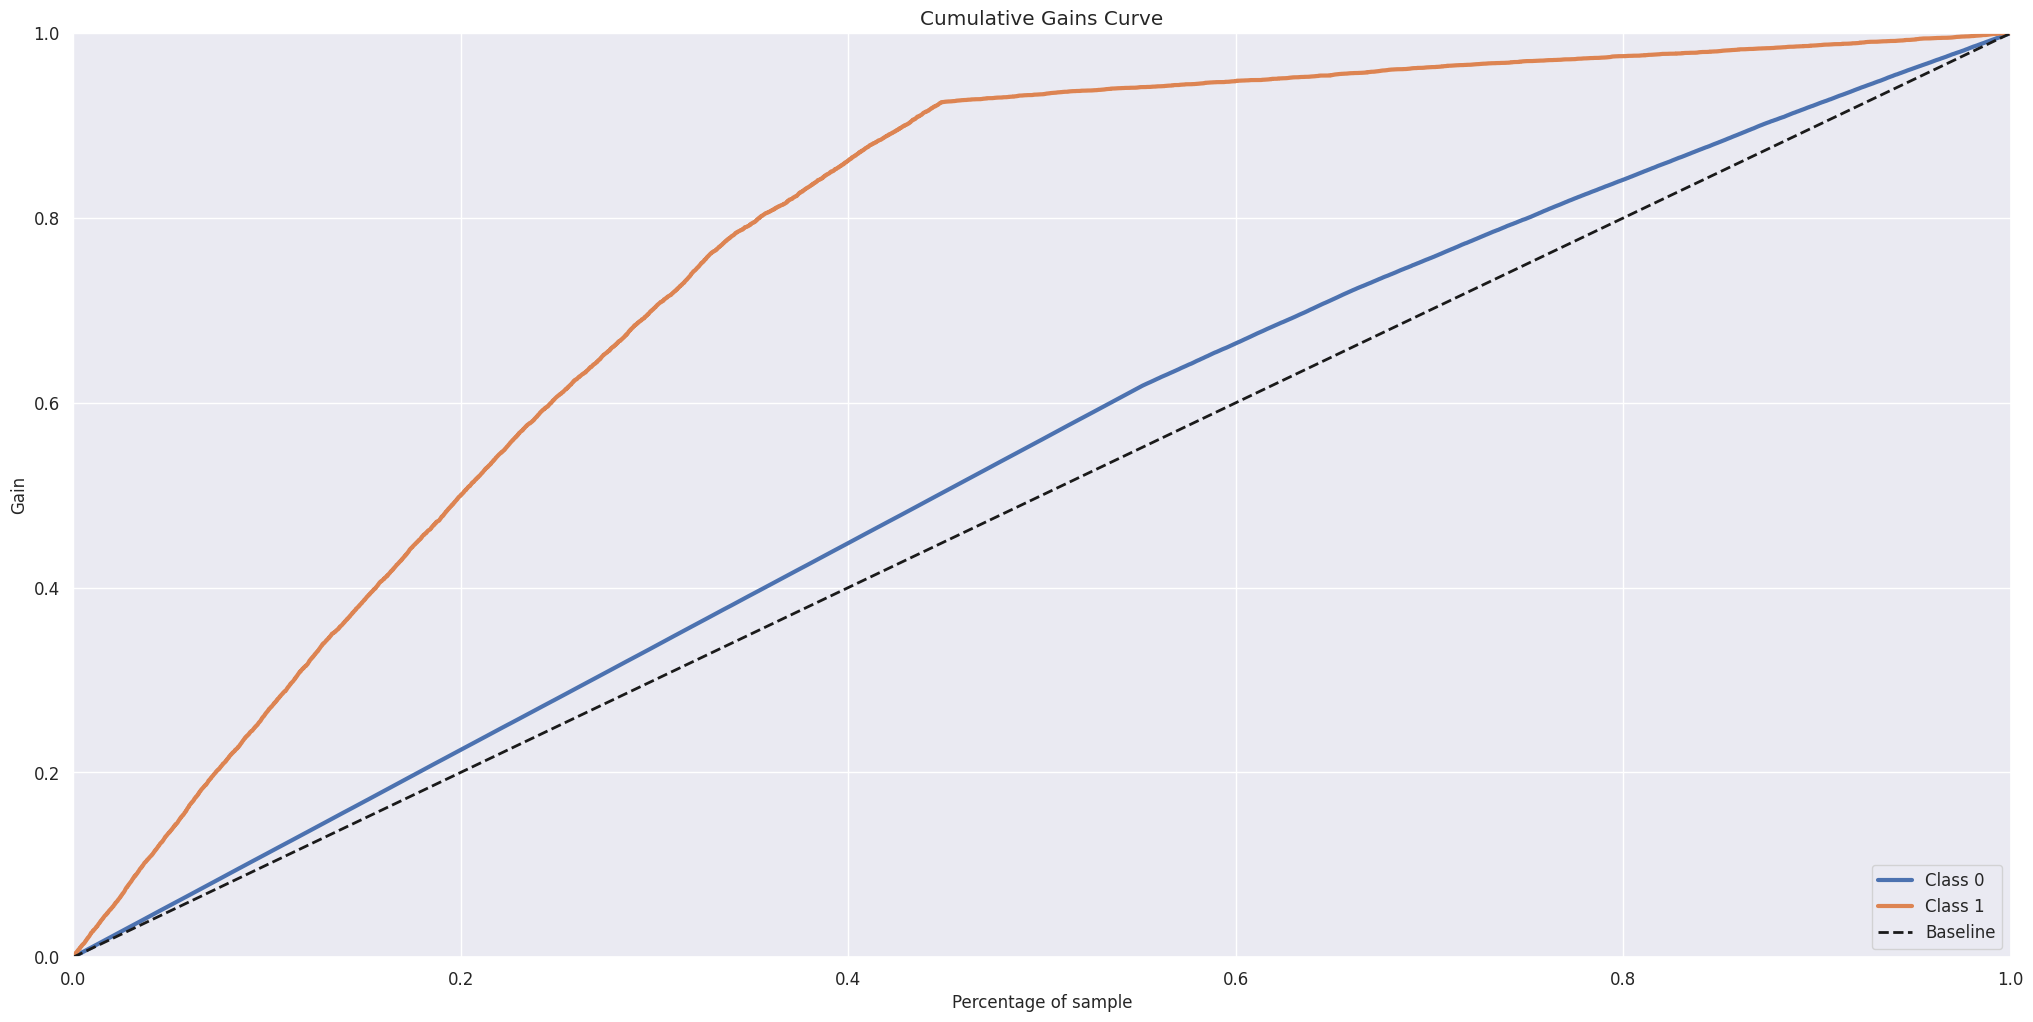

In [91]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn)

In [92]:
print(f'Precision at k: {precision_at_k(df7, yhat_knn)}')
print(f'Recall at k: {recall_at_k(df7, yhat_knn)}')

Precision at k: 0.303884805759712
Recall at k: 0.5204658331906148


#### Cross Validation

In [93]:
cv_knn = cross_validation(knn_model, 5, X_train_cv, y_train_cv)

/tmp/ipykernel_34820/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_34820/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_34820/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_34820/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_34820/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_34820/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

### Logistic Regression

In [94]:
# Model
lr_model = LogisticRegression()

# model training
lr_model.fit(x_train, y_train)

# model prediction - GENERALIZATION
yhat_lr = lr_model.predict_proba(x_val)

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

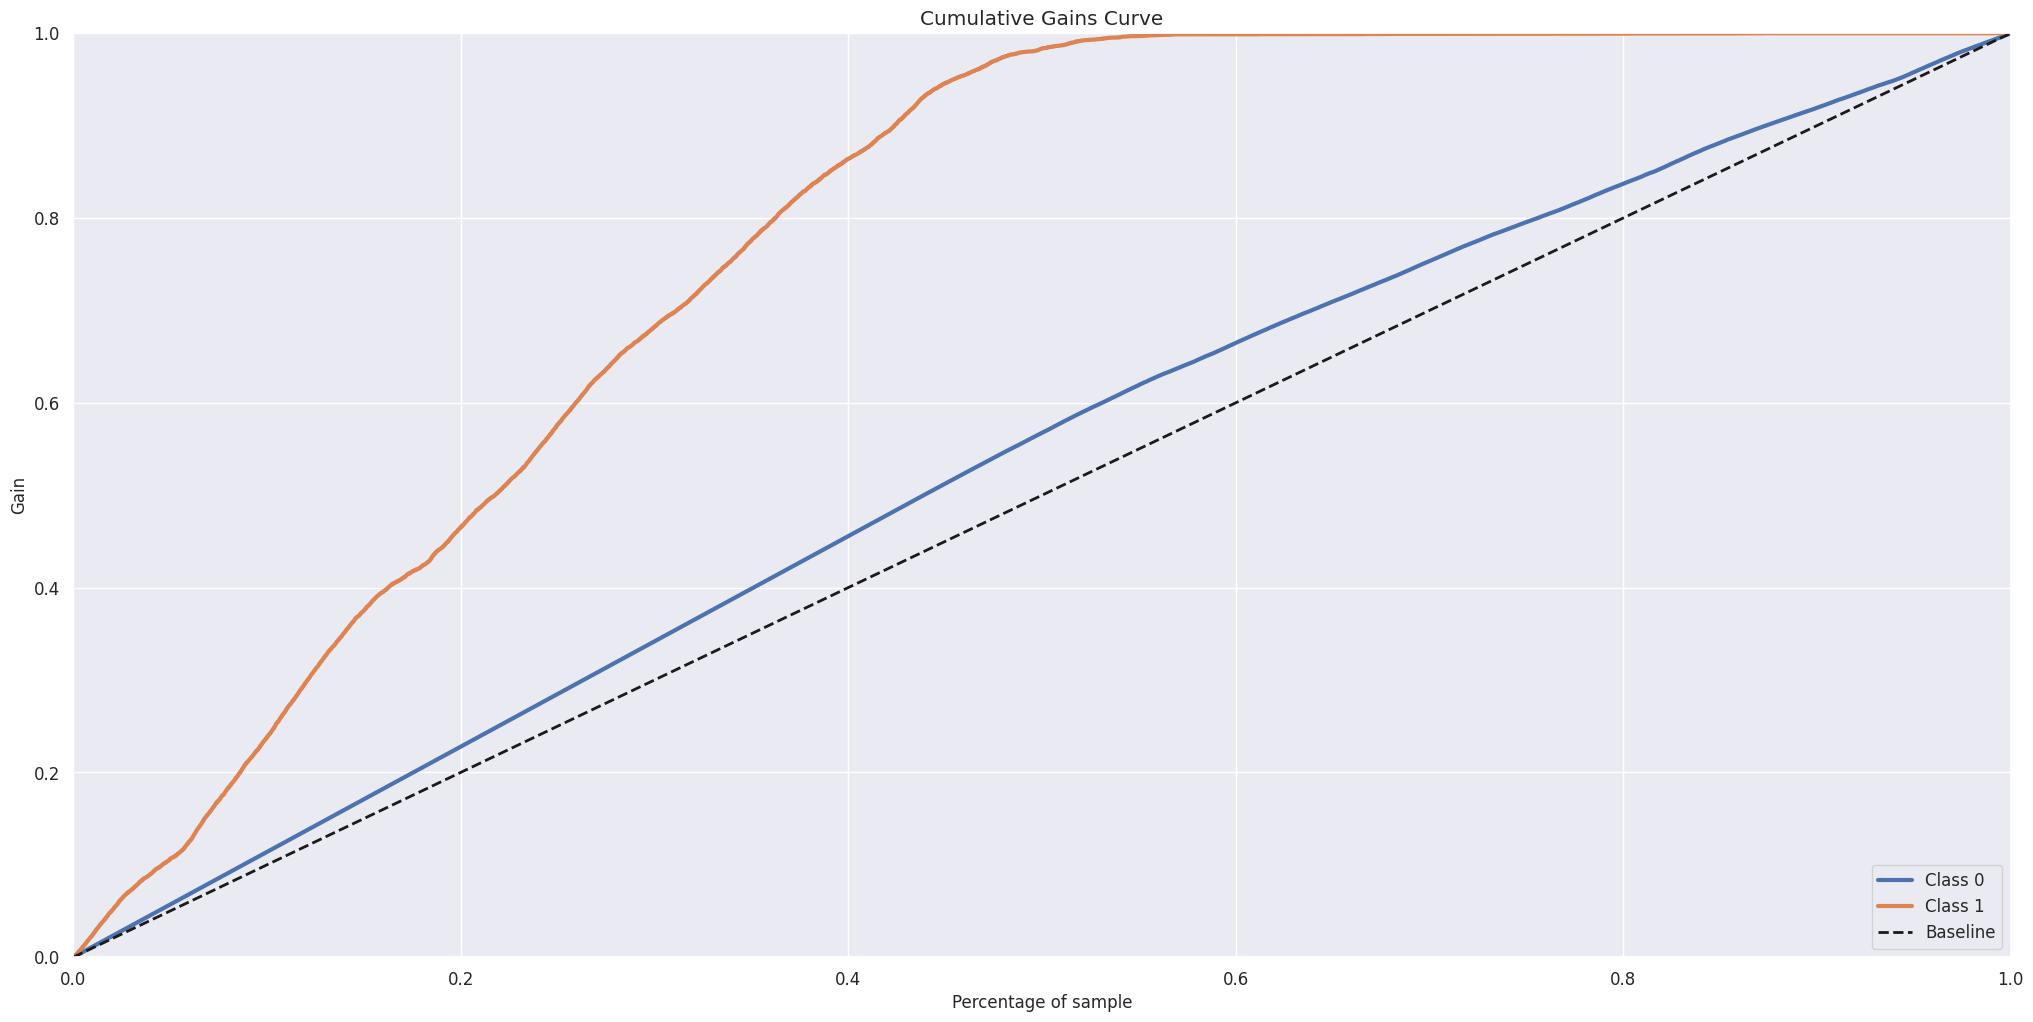

In [95]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr)

In [96]:
print(f'Precision at k: {precision_at_k(df7, yhat_lr)}')
print(f'Recall at k: {recall_at_k(df7, yhat_lr)}')

Precision at k: 0.2840857957102145
Recall at k: 0.486555917109094


#### Cross Validation

In [97]:
cv_lr = cross_validation(lr_model, 5, X_train_cv, y_train_cv)
cv_lr

/tmp/ipykernel_34820/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_34820/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_34820/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_34820/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_34820/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_34820/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,Model,Precision at k,Recall at k
0,LogisticRegression,0.275+/-0.002,0.785+/-0.0057


### Random Forest

In [98]:
# Model
rf_model = RandomForestClassifier(n_jobs=-1)

# model training
rf_model.fit(x_train, y_train)

# model prediction - GENERALIZATION
yhat_rf = lr_model.predict_proba(x_val)

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

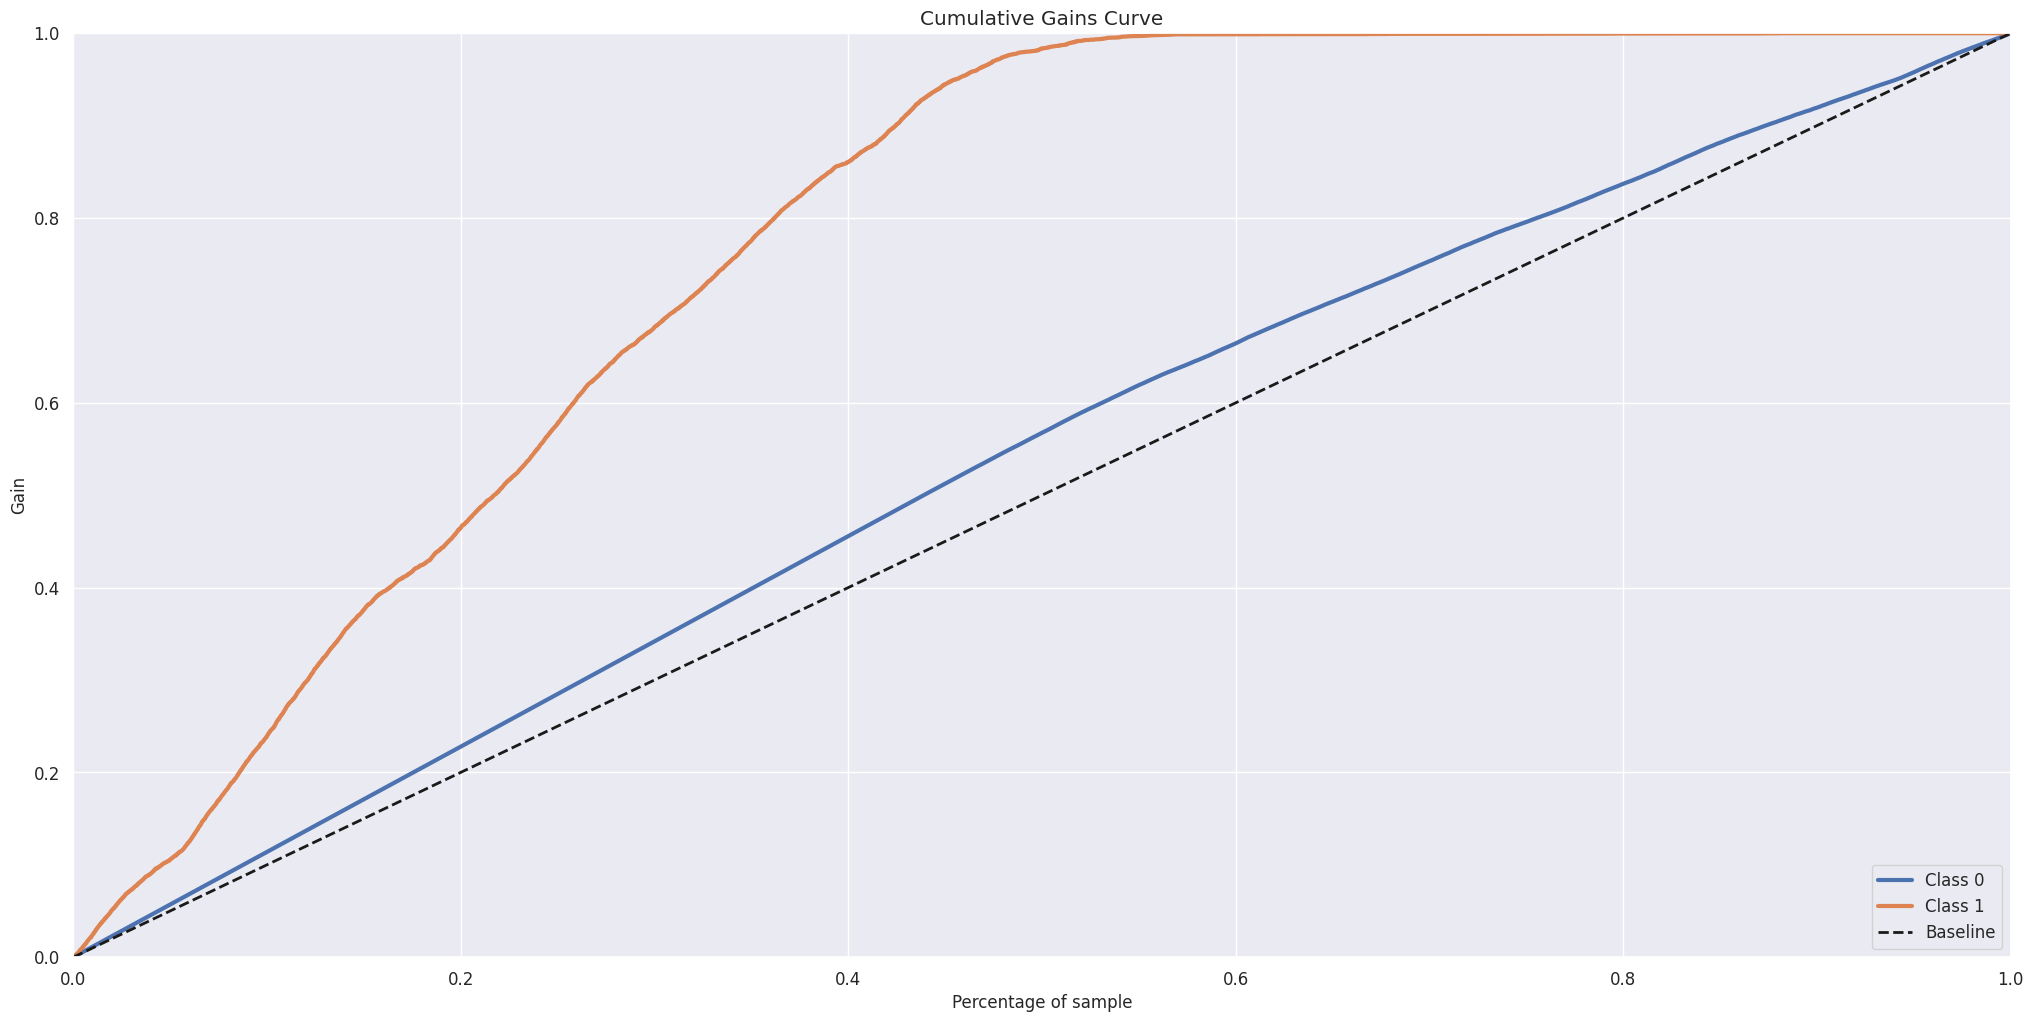

In [99]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_rf)

In [100]:
print(f'Precision at k: {precision_at_k(df7, yhat_rf)}')
print(f'Recall at k: {recall_at_k(df7, yhat_rf)}')

Precision at k: 0.2839358032098395
Recall at k: 0.48629902380544615


#### Cross Validation

In [101]:
cv_rf = cross_validation(rf_model, 5, X_train_cv, y_train_cv)
cv_rf

/tmp/ipykernel_34820/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_34820/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_34820/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['vehicle_age'] = X_train_fold['vehicle_age'].map(vehicle_age_dict)
/tmp/ipykernel_34820/4150216634.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

/tmp/ipykernel_34820/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_34820/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

,Model,Precision at k,Recall at k
0,RandomForestClassifier,0.2869+/-0.0026,0.8189+/-0.0074


### XGBoost

In [102]:
# Model
xgb_model = XGBClassifier(max_delta_step=1, n_jobs=-1)

# model training
xgb_model.fit(x_train, y_train)

# model prediction
yhat_xgb = xgb_model.predict_proba(x_val)

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

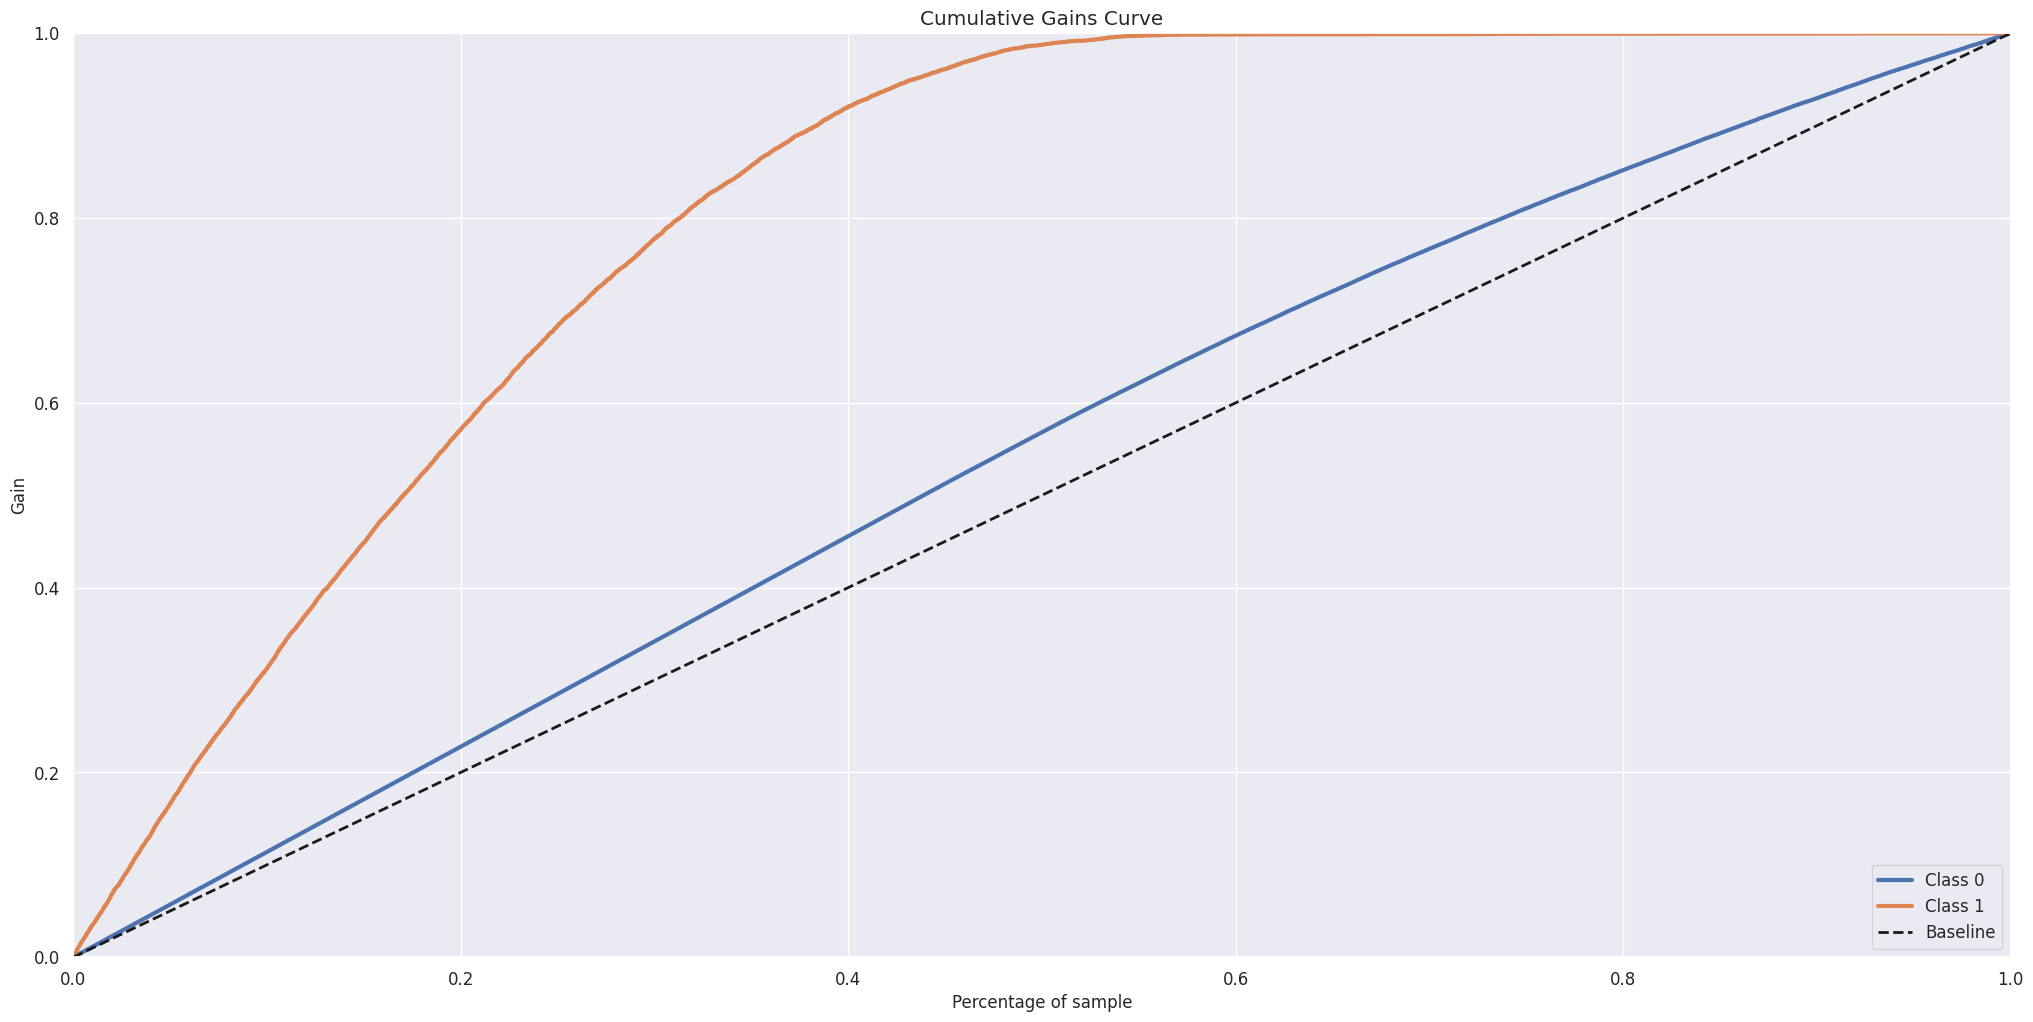

In [103]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb)

In [104]:
print(f'Precision at k: {precision_at_k(df7, yhat_xgb)}')
print(f'Recall at k: {recall_at_k(df7, yhat_xgb)}')

Precision at k: 0.34693265336733164
Recall at k: 0.5941942113375578


#### Cross Validation

In [105]:
cv_xgb = cross_validation(xgb_model, 5, X_train_cv, y_train_cv)

/tmp/ipykernel_34820/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_34820/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_34820/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['vehicle_age'] = X_train_fold['vehicle_age'].map(vehicle_age_dict)
/tmp/ipykernel_34820/4150216634.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

/tmp/ipykernel_34820/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_34820/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

### LightGBM

In [130]:
# Model
lgbm_model = LGBMClassifier(objective='binary', is_unbalance=True)

# model training
lgbm_model.fit(x_train, y_train)

# model prediction
yhat_lgbm = lgbm_model.predict_proba(x_val)

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

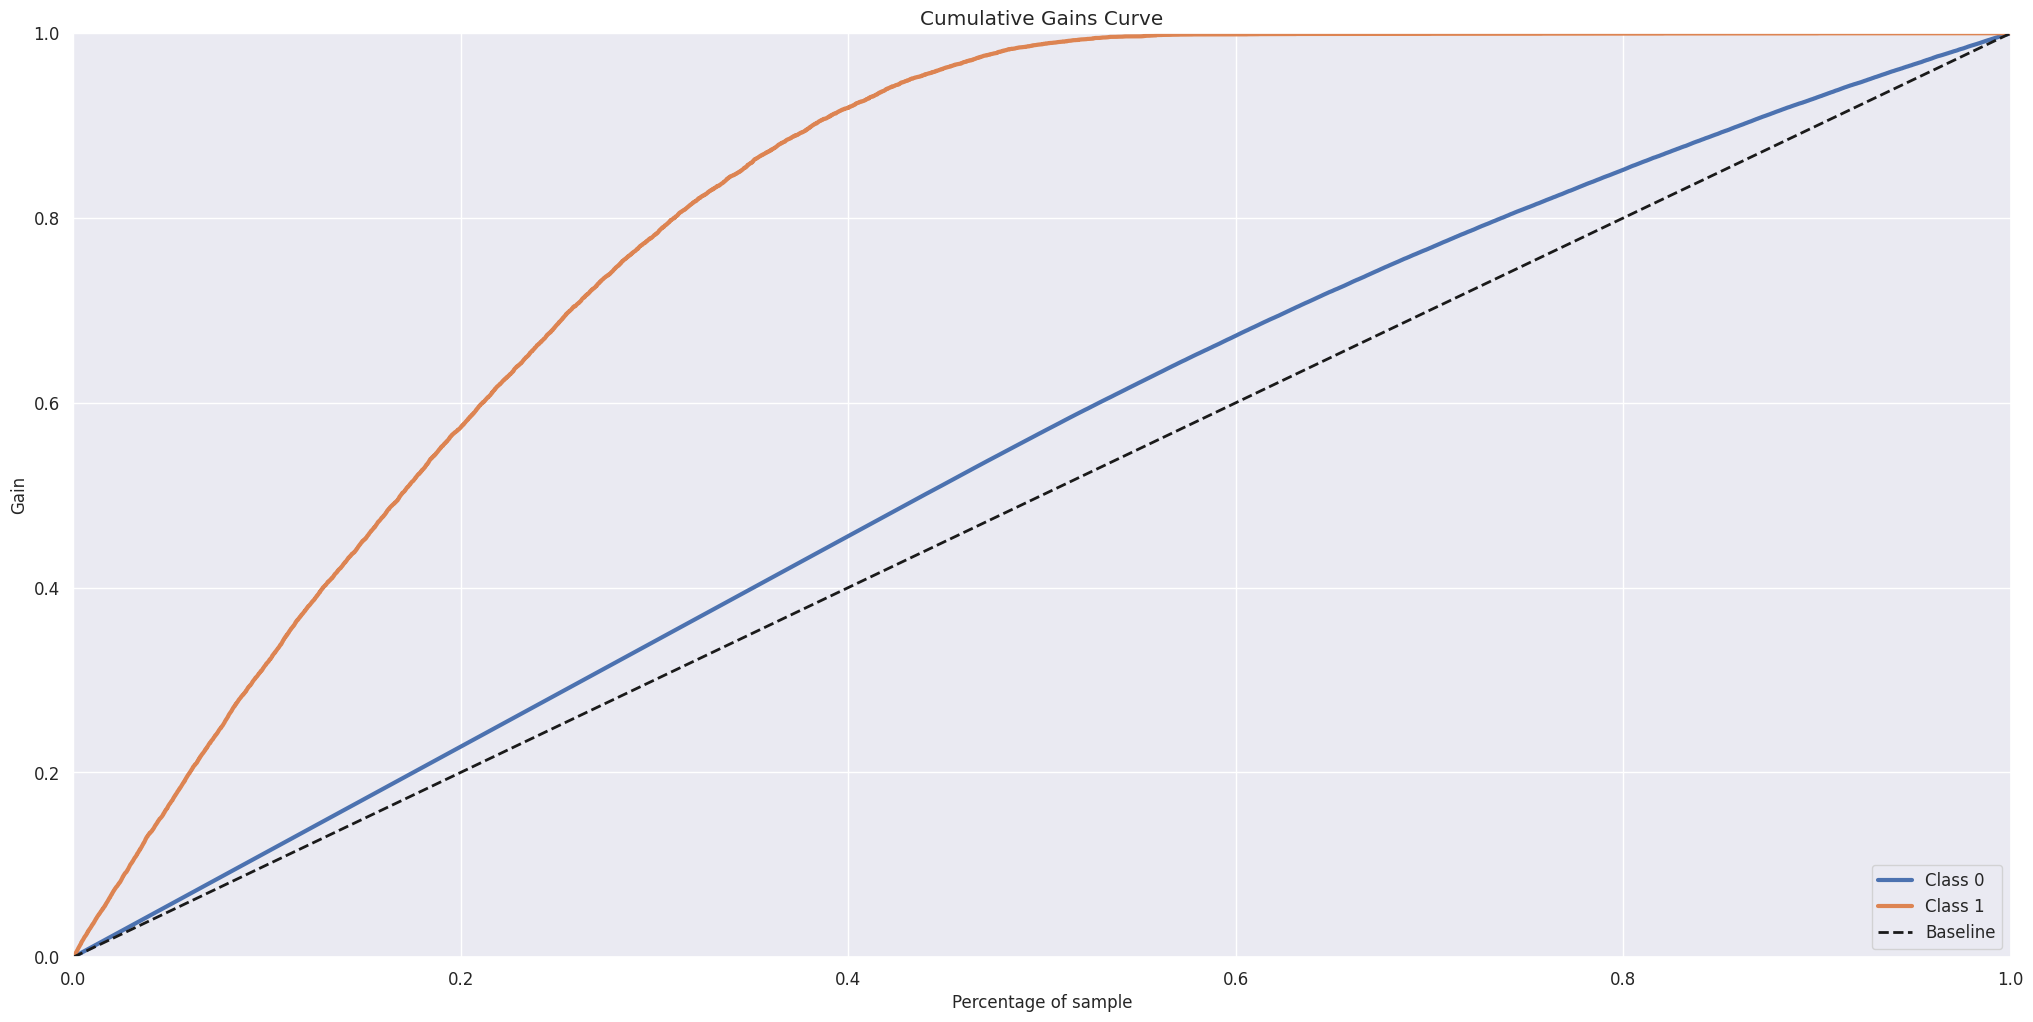

In [131]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm)

In [132]:
print(f'Precision at k: {precision_at_k(df7, yhat_lgbm)}')
print(f'Recall at k: {recall_at_k(df7, yhat_lgbm)}')

Precision at k: 0.3487325633718314
Recall at k: 0.5972769309813324


#### Cross Validation

In [109]:
cv_lgbm = cross_validation(lgbm_model, 5, X_train_cv, y_train_cv)

/tmp/ipykernel_34820/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_34820/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_34820/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['vehicle_age'] = X_train_fold['vehicle_age'].map(vehicle_age_dict)
/tmp/ipykernel_34820/4150216634.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

/tmp/ipykernel_34820/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_34820/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

### CatBoost

In [110]:
# Model
cat_model = CatBoostClassifier()

# model training
cat_model.fit(x_train, y_train)

# model prediction
yhat_cat = cat_model.predict_proba(x_val)

Learning rate set to 0.115264
0:	learn: 0.5075926	total: 82.5ms	remaining: 1m 22s
1:	learn: 0.4075805	total: 129ms	remaining: 1m 4s
2:	learn: 0.3559729	total: 204ms	remaining: 1m 7s
3:	learn: 0.3271069	total: 251ms	remaining: 1m 2s
4:	learn: 0.3096499	total: 300ms	remaining: 59.6s
5:	learn: 0.2980465	total: 354ms	remaining: 58.7s
6:	learn: 0.2903140	total: 406ms	remaining: 57.6s
7:	learn: 0.2849876	total: 462ms	remaining: 57.3s
8:	learn: 0.2814593	total: 516ms	remaining: 56.8s
9:	learn: 0.2785800	total: 561ms	remaining: 55.6s
10:	learn: 0.2763120	total: 618ms	remaining: 55.6s
11:	learn: 0.2745629	total: 672ms	remaining: 55.3s
12:	learn: 0.2734829	total: 720ms	remaining: 54.7s
13:	learn: 0.2724164	total: 766ms	remaining: 54s
14:	learn: 0.2716351	total: 815ms	remaining: 53.5s
15:	learn: 0.2708531	total: 877ms	remaining: 53.9s
16:	learn: 0.2703364	total: 923ms	remaining: 53.4s
17:	learn: 0.2698953	total: 966ms	remaining: 52.7s
18:	learn: 0.2695044	total: 1.01s	remaining: 52.4s
19:	learn: 

160:	learn: 0.2631875	total: 9.08s	remaining: 47.3s
161:	learn: 0.2631719	total: 9.18s	remaining: 47.5s
162:	learn: 0.2631386	total: 9.34s	remaining: 48s
163:	learn: 0.2631247	total: 9.47s	remaining: 48.3s
164:	learn: 0.2630991	total: 9.58s	remaining: 48.5s
165:	learn: 0.2630882	total: 9.69s	remaining: 48.7s
166:	learn: 0.2630754	total: 9.76s	remaining: 48.7s
167:	learn: 0.2630587	total: 9.84s	remaining: 48.7s
168:	learn: 0.2630449	total: 9.93s	remaining: 48.8s
169:	learn: 0.2630259	total: 10s	remaining: 49s
170:	learn: 0.2630074	total: 10.3s	remaining: 49.7s
171:	learn: 0.2629961	total: 10.4s	remaining: 50s
172:	learn: 0.2629813	total: 10.5s	remaining: 50.4s
173:	learn: 0.2629661	total: 10.7s	remaining: 50.6s
174:	learn: 0.2629536	total: 10.8s	remaining: 50.7s
175:	learn: 0.2629420	total: 10.9s	remaining: 51s
176:	learn: 0.2629133	total: 11s	remaining: 51.1s
177:	learn: 0.2628780	total: 11.1s	remaining: 51.3s
178:	learn: 0.2628426	total: 11.2s	remaining: 51.4s
179:	learn: 0.2628284	to

320:	learn: 0.2605889	total: 26.9s	remaining: 56.9s
321:	learn: 0.2605761	total: 27.1s	remaining: 57s
322:	learn: 0.2605679	total: 27.2s	remaining: 57s
323:	learn: 0.2605483	total: 27.3s	remaining: 56.9s
324:	learn: 0.2605385	total: 27.4s	remaining: 56.9s
325:	learn: 0.2605288	total: 27.5s	remaining: 56.8s
326:	learn: 0.2605157	total: 27.6s	remaining: 56.8s
327:	learn: 0.2605080	total: 27.8s	remaining: 57s
328:	learn: 0.2604909	total: 28s	remaining: 57.1s
329:	learn: 0.2604786	total: 28.1s	remaining: 57.1s
330:	learn: 0.2604587	total: 28.3s	remaining: 57.1s
331:	learn: 0.2604486	total: 28.4s	remaining: 57.2s
332:	learn: 0.2604390	total: 28.5s	remaining: 57.1s
333:	learn: 0.2604217	total: 28.6s	remaining: 57.1s
334:	learn: 0.2604058	total: 28.8s	remaining: 57.1s
335:	learn: 0.2603880	total: 28.9s	remaining: 57s
336:	learn: 0.2603733	total: 29s	remaining: 57s
337:	learn: 0.2603529	total: 29.2s	remaining: 57.1s
338:	learn: 0.2603369	total: 29.3s	remaining: 57.1s
339:	learn: 0.2603304	tota

480:	learn: 0.2584233	total: 41.9s	remaining: 45.2s
481:	learn: 0.2584109	total: 42.1s	remaining: 45.2s
482:	learn: 0.2583987	total: 42.2s	remaining: 45.2s
483:	learn: 0.2583927	total: 42.3s	remaining: 45.1s
484:	learn: 0.2583796	total: 42.4s	remaining: 45.1s
485:	learn: 0.2583709	total: 42.5s	remaining: 45s
486:	learn: 0.2583576	total: 42.6s	remaining: 44.9s
487:	learn: 0.2583494	total: 42.8s	remaining: 44.9s
488:	learn: 0.2583347	total: 42.9s	remaining: 44.8s
489:	learn: 0.2583114	total: 43s	remaining: 44.8s
490:	learn: 0.2583015	total: 43.1s	remaining: 44.7s
491:	learn: 0.2582849	total: 43.2s	remaining: 44.7s
492:	learn: 0.2582722	total: 43.4s	remaining: 44.6s
493:	learn: 0.2582553	total: 43.5s	remaining: 44.6s
494:	learn: 0.2582368	total: 43.7s	remaining: 44.6s
495:	learn: 0.2582237	total: 43.9s	remaining: 44.6s
496:	learn: 0.2582122	total: 44s	remaining: 44.5s
497:	learn: 0.2581972	total: 44.1s	remaining: 44.4s
498:	learn: 0.2581885	total: 44.2s	remaining: 44.4s
499:	learn: 0.2581

642:	learn: 0.2564591	total: 56.6s	remaining: 31.4s
643:	learn: 0.2564496	total: 56.7s	remaining: 31.4s
644:	learn: 0.2564349	total: 56.8s	remaining: 31.3s
645:	learn: 0.2564144	total: 56.9s	remaining: 31.2s
646:	learn: 0.2563971	total: 57s	remaining: 31.1s
647:	learn: 0.2563871	total: 57s	remaining: 31s
648:	learn: 0.2563729	total: 57.1s	remaining: 30.9s
649:	learn: 0.2563554	total: 57.1s	remaining: 30.8s
650:	learn: 0.2563435	total: 57.2s	remaining: 30.7s
651:	learn: 0.2563376	total: 57.3s	remaining: 30.6s
652:	learn: 0.2563264	total: 57.4s	remaining: 30.5s
653:	learn: 0.2563192	total: 57.4s	remaining: 30.4s
654:	learn: 0.2563067	total: 57.5s	remaining: 30.3s
655:	learn: 0.2562944	total: 57.6s	remaining: 30.2s
656:	learn: 0.2562848	total: 57.6s	remaining: 30.1s
657:	learn: 0.2562730	total: 57.7s	remaining: 30s
658:	learn: 0.2562608	total: 57.8s	remaining: 29.9s
659:	learn: 0.2562380	total: 57.9s	remaining: 29.8s
660:	learn: 0.2562256	total: 58s	remaining: 29.7s
661:	learn: 0.2562156	

803:	learn: 0.2545275	total: 1m 8s	remaining: 16.7s
804:	learn: 0.2545189	total: 1m 8s	remaining: 16.6s
805:	learn: 0.2545071	total: 1m 8s	remaining: 16.5s
806:	learn: 0.2544974	total: 1m 8s	remaining: 16.4s
807:	learn: 0.2544819	total: 1m 8s	remaining: 16.3s
808:	learn: 0.2544715	total: 1m 8s	remaining: 16.2s
809:	learn: 0.2544569	total: 1m 8s	remaining: 16.1s
810:	learn: 0.2544466	total: 1m 8s	remaining: 16.1s
811:	learn: 0.2544365	total: 1m 9s	remaining: 16s
812:	learn: 0.2544259	total: 1m 9s	remaining: 15.9s
813:	learn: 0.2544122	total: 1m 9s	remaining: 15.8s
814:	learn: 0.2544013	total: 1m 9s	remaining: 15.7s
815:	learn: 0.2543858	total: 1m 9s	remaining: 15.6s
816:	learn: 0.2543773	total: 1m 9s	remaining: 15.6s
817:	learn: 0.2543700	total: 1m 9s	remaining: 15.5s
818:	learn: 0.2543617	total: 1m 9s	remaining: 15.4s
819:	learn: 0.2543566	total: 1m 9s	remaining: 15.3s
820:	learn: 0.2543414	total: 1m 9s	remaining: 15.2s
821:	learn: 0.2543323	total: 1m 9s	remaining: 15.1s
822:	learn: 0.

961:	learn: 0.2527517	total: 1m 19s	remaining: 3.15s
962:	learn: 0.2527350	total: 1m 19s	remaining: 3.06s
963:	learn: 0.2527242	total: 1m 19s	remaining: 2.98s
964:	learn: 0.2527143	total: 1m 19s	remaining: 2.89s
965:	learn: 0.2527048	total: 1m 19s	remaining: 2.81s
966:	learn: 0.2526999	total: 1m 19s	remaining: 2.73s
967:	learn: 0.2526857	total: 1m 20s	remaining: 2.64s
968:	learn: 0.2526696	total: 1m 20s	remaining: 2.56s
969:	learn: 0.2526527	total: 1m 20s	remaining: 2.48s
970:	learn: 0.2526430	total: 1m 20s	remaining: 2.4s
971:	learn: 0.2526356	total: 1m 20s	remaining: 2.31s
972:	learn: 0.2526265	total: 1m 20s	remaining: 2.23s
973:	learn: 0.2526067	total: 1m 20s	remaining: 2.15s
974:	learn: 0.2525914	total: 1m 20s	remaining: 2.06s
975:	learn: 0.2525830	total: 1m 20s	remaining: 1.98s
976:	learn: 0.2525710	total: 1m 20s	remaining: 1.9s
977:	learn: 0.2525594	total: 1m 20s	remaining: 1.81s
978:	learn: 0.2525534	total: 1m 20s	remaining: 1.73s
979:	learn: 0.2525459	total: 1m 20s	remaining: 1

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

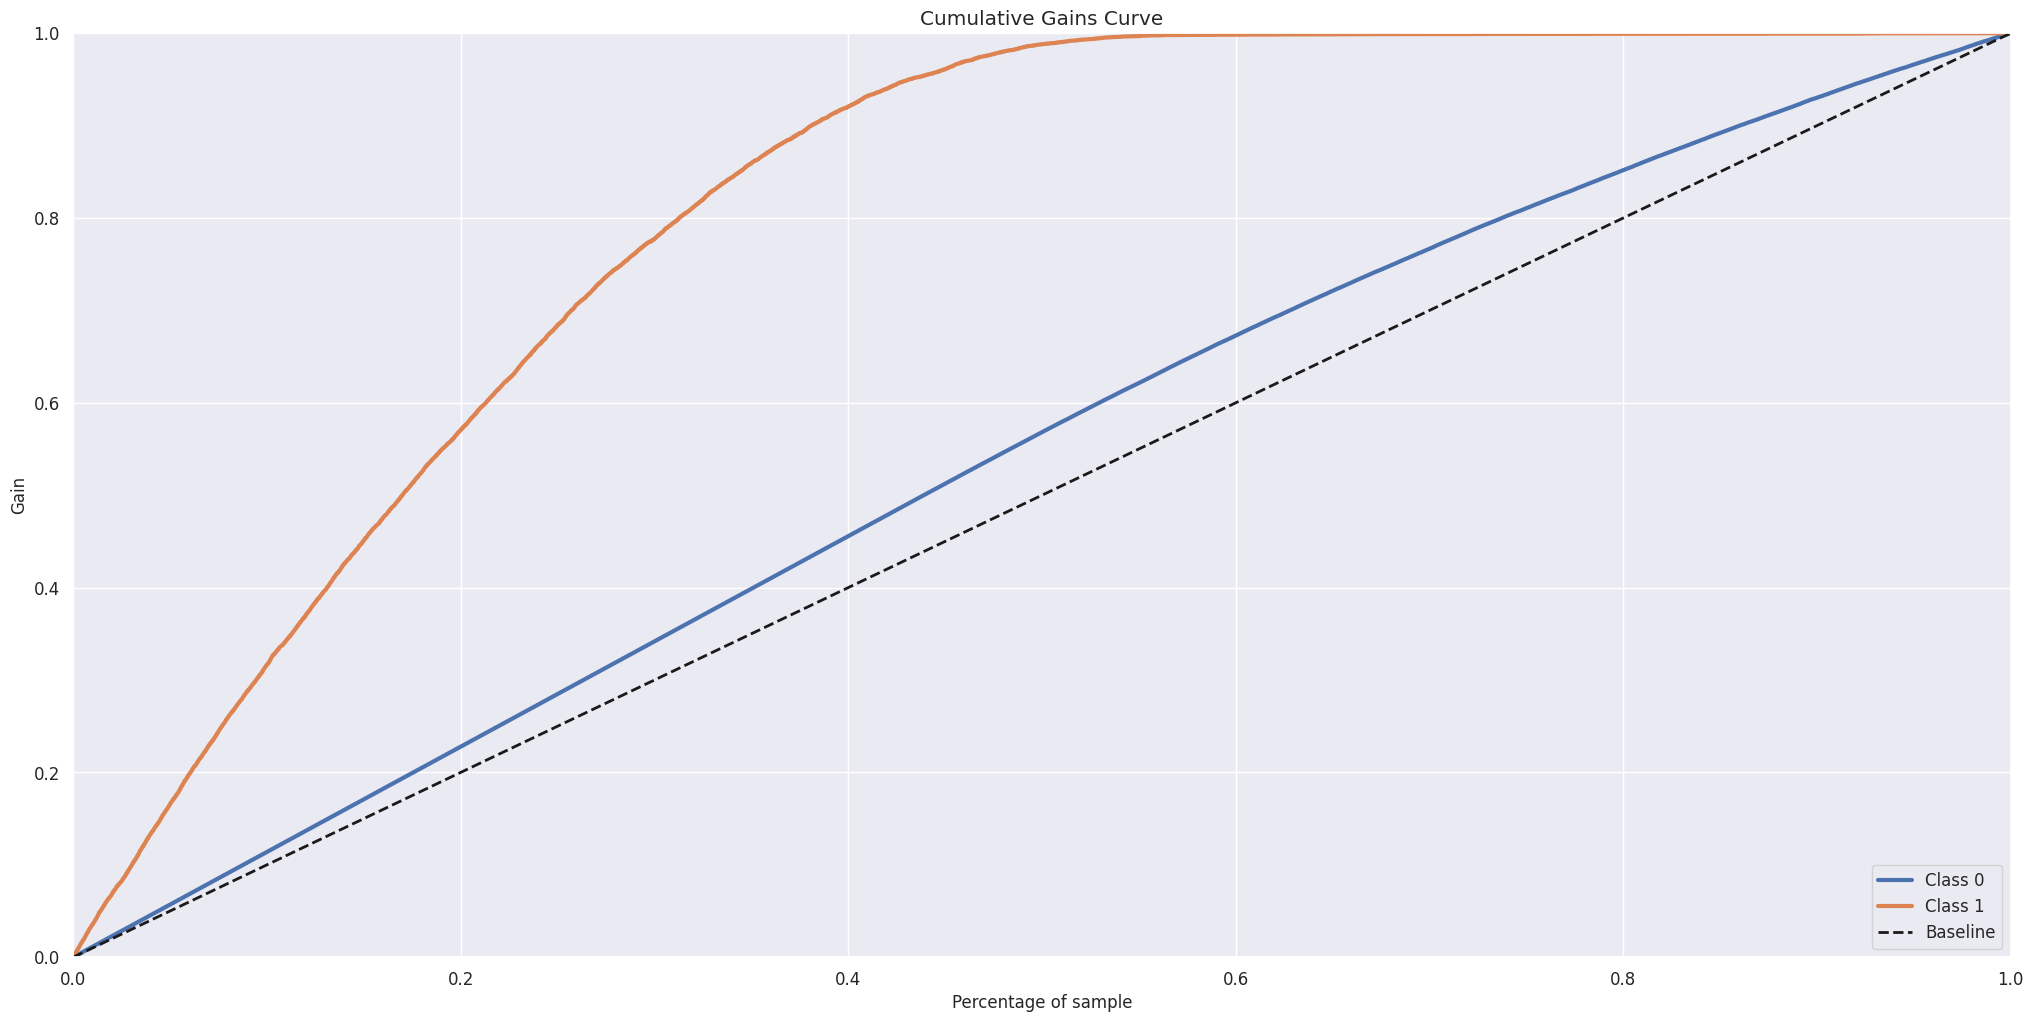

In [111]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_cat)

In [112]:
print(f'Precision at k: {precision_at_k(df7, yhat_cat)}')
print(f'Recall at k: {recall_at_k(df7, yhat_cat)}')

Precision at k: 0.34668266586670665
Recall at k: 0.593766055831478


#### Cross Validation

In [113]:
cv_cat = cross_validation(cat_model, 5, X_train_cv, y_train_cv)
cv_cat

/tmp/ipykernel_34820/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

Learning rate set to 0.104788
0:	learn: 0.5223425	total: 48.2ms	remaining: 48.1s
1:	learn: 0.4238856	total: 95.6ms	remaining: 47.7s
2:	learn: 0.3690232	total: 156ms	remaining: 51.8s
3:	learn: 0.3366386	total: 245ms	remaining: 1m 1s
4:	learn: 0.3193463	total: 291ms	remaining: 58s
5:	learn: 0.3051483	total: 348ms	remaining: 57.7s
6:	learn: 0.2956290	total: 401ms	remaining: 56.9s
7:	learn: 0.2899992	total: 467ms	remaining: 57.9s
8:	learn: 0.2848387	total: 530ms	remaining: 58.4s
9:	learn: 0.2815648	total: 577ms	remaining: 57.1s
10:	learn: 0.2788661	total: 634ms	remaining: 57s
11:	learn: 0.2770038	total: 706ms	remaining: 58.1s
12:	learn: 0.2750826	total: 772ms	remaining: 58.6s
13:	learn: 0.2736933	total: 826ms	remaining: 58.2s
14:	learn: 0.2724464	total: 874ms	remaining: 57.4s
15:	learn: 0.2714765	total: 957ms	remaining: 58.9s
16:	learn: 0.2707762	total: 1.06s	remaining: 1m 1s
17:	learn: 0.2701624	total: 1.17s	remaining: 1m 3s
18:	learn: 0.2697210	total: 1.24s	remaining: 1m 4s
19:	learn: 0.

159:	learn: 0.2625025	total: 12.2s	remaining: 1m 4s
160:	learn: 0.2624803	total: 12.3s	remaining: 1m 3s
161:	learn: 0.2624472	total: 12.3s	remaining: 1m 3s
162:	learn: 0.2624277	total: 12.4s	remaining: 1m 3s
163:	learn: 0.2624036	total: 12.5s	remaining: 1m 3s
164:	learn: 0.2623818	total: 12.5s	remaining: 1m 3s
165:	learn: 0.2623656	total: 12.6s	remaining: 1m 3s
166:	learn: 0.2623462	total: 12.7s	remaining: 1m 3s
167:	learn: 0.2623293	total: 12.7s	remaining: 1m 3s
168:	learn: 0.2623118	total: 12.8s	remaining: 1m 2s
169:	learn: 0.2622730	total: 12.8s	remaining: 1m 2s
170:	learn: 0.2622446	total: 12.9s	remaining: 1m 2s
171:	learn: 0.2622137	total: 13s	remaining: 1m 2s
172:	learn: 0.2621938	total: 13.1s	remaining: 1m 2s
173:	learn: 0.2621705	total: 13.1s	remaining: 1m 2s
174:	learn: 0.2621484	total: 13.2s	remaining: 1m 2s
175:	learn: 0.2621253	total: 13.2s	remaining: 1m 1s
176:	learn: 0.2620970	total: 13.3s	remaining: 1m 1s
177:	learn: 0.2620602	total: 13.4s	remaining: 1m 1s
178:	learn: 0.

318:	learn: 0.2595150	total: 22.7s	remaining: 48.4s
319:	learn: 0.2595059	total: 22.7s	remaining: 48.3s
320:	learn: 0.2594899	total: 22.8s	remaining: 48.2s
321:	learn: 0.2594684	total: 22.8s	remaining: 48.1s
322:	learn: 0.2594459	total: 22.9s	remaining: 48s
323:	learn: 0.2594375	total: 23s	remaining: 47.9s
324:	learn: 0.2594243	total: 23.1s	remaining: 47.9s
325:	learn: 0.2594136	total: 23.2s	remaining: 47.9s
326:	learn: 0.2593913	total: 23.3s	remaining: 48s
327:	learn: 0.2593644	total: 23.4s	remaining: 48s
328:	learn: 0.2593426	total: 23.6s	remaining: 48.1s
329:	learn: 0.2593244	total: 23.6s	remaining: 48s
330:	learn: 0.2593105	total: 23.7s	remaining: 47.9s
331:	learn: 0.2592847	total: 23.8s	remaining: 47.9s
332:	learn: 0.2592702	total: 24s	remaining: 48s
333:	learn: 0.2592481	total: 24.1s	remaining: 48s
334:	learn: 0.2592356	total: 24.2s	remaining: 48s
335:	learn: 0.2592233	total: 24.3s	remaining: 48s
336:	learn: 0.2592123	total: 24.4s	remaining: 47.9s
337:	learn: 0.2591966	total: 24.

477:	learn: 0.2569941	total: 33.4s	remaining: 36.5s
478:	learn: 0.2569819	total: 33.5s	remaining: 36.5s
479:	learn: 0.2569673	total: 33.6s	remaining: 36.4s
480:	learn: 0.2569502	total: 33.6s	remaining: 36.3s
481:	learn: 0.2569299	total: 33.7s	remaining: 36.2s
482:	learn: 0.2569123	total: 33.7s	remaining: 36.1s
483:	learn: 0.2568942	total: 33.8s	remaining: 36s
484:	learn: 0.2568825	total: 33.9s	remaining: 36s
485:	learn: 0.2568700	total: 33.9s	remaining: 35.9s
486:	learn: 0.2568530	total: 34s	remaining: 35.8s
487:	learn: 0.2568403	total: 34s	remaining: 35.7s
488:	learn: 0.2568245	total: 34.1s	remaining: 35.6s
489:	learn: 0.2568064	total: 34.1s	remaining: 35.5s
490:	learn: 0.2567835	total: 34.2s	remaining: 35.5s
491:	learn: 0.2567703	total: 34.2s	remaining: 35.4s
492:	learn: 0.2567546	total: 34.3s	remaining: 35.3s
493:	learn: 0.2567383	total: 34.4s	remaining: 35.2s
494:	learn: 0.2567203	total: 34.4s	remaining: 35.1s
495:	learn: 0.2567005	total: 34.5s	remaining: 35s
496:	learn: 0.2566869	

639:	learn: 0.2547293	total: 43.3s	remaining: 24.4s
640:	learn: 0.2547134	total: 43.4s	remaining: 24.3s
641:	learn: 0.2546968	total: 43.5s	remaining: 24.2s
642:	learn: 0.2546799	total: 43.5s	remaining: 24.2s
643:	learn: 0.2546721	total: 43.6s	remaining: 24.1s
644:	learn: 0.2546505	total: 43.6s	remaining: 24s
645:	learn: 0.2546362	total: 43.7s	remaining: 23.9s
646:	learn: 0.2546238	total: 43.7s	remaining: 23.9s
647:	learn: 0.2546107	total: 43.8s	remaining: 23.8s
648:	learn: 0.2545940	total: 43.9s	remaining: 23.7s
649:	learn: 0.2545874	total: 43.9s	remaining: 23.6s
650:	learn: 0.2545734	total: 44s	remaining: 23.6s
651:	learn: 0.2545606	total: 44s	remaining: 23.5s
652:	learn: 0.2545453	total: 44.1s	remaining: 23.4s
653:	learn: 0.2545258	total: 44.1s	remaining: 23.4s
654:	learn: 0.2545131	total: 44.2s	remaining: 23.3s
655:	learn: 0.2544984	total: 44.3s	remaining: 23.2s
656:	learn: 0.2544891	total: 44.3s	remaining: 23.1s
657:	learn: 0.2544749	total: 44.4s	remaining: 23.1s
658:	learn: 0.2544

800:	learn: 0.2526487	total: 53s	remaining: 13.2s
801:	learn: 0.2526384	total: 53s	remaining: 13.1s
802:	learn: 0.2526249	total: 53.1s	remaining: 13s
803:	learn: 0.2526089	total: 53.1s	remaining: 12.9s
804:	learn: 0.2525916	total: 53.2s	remaining: 12.9s
805:	learn: 0.2525751	total: 53.2s	remaining: 12.8s
806:	learn: 0.2525674	total: 53.3s	remaining: 12.7s
807:	learn: 0.2525595	total: 53.4s	remaining: 12.7s
808:	learn: 0.2525440	total: 53.4s	remaining: 12.6s
809:	learn: 0.2525387	total: 53.5s	remaining: 12.6s
810:	learn: 0.2525236	total: 53.6s	remaining: 12.5s
811:	learn: 0.2525053	total: 53.6s	remaining: 12.4s
812:	learn: 0.2524933	total: 53.7s	remaining: 12.3s
813:	learn: 0.2524843	total: 53.8s	remaining: 12.3s
814:	learn: 0.2524670	total: 53.8s	remaining: 12.2s
815:	learn: 0.2524524	total: 53.9s	remaining: 12.1s
816:	learn: 0.2524385	total: 53.9s	remaining: 12.1s
817:	learn: 0.2524209	total: 54s	remaining: 12s
818:	learn: 0.2524080	total: 54s	remaining: 11.9s
819:	learn: 0.2523964	to

961:	learn: 0.2506539	total: 1m 2s	remaining: 2.48s
962:	learn: 0.2506516	total: 1m 2s	remaining: 2.41s
963:	learn: 0.2506360	total: 1m 2s	remaining: 2.35s
964:	learn: 0.2506203	total: 1m 2s	remaining: 2.28s
965:	learn: 0.2506003	total: 1m 2s	remaining: 2.21s
966:	learn: 0.2505908	total: 1m 3s	remaining: 2.15s
967:	learn: 0.2505755	total: 1m 3s	remaining: 2.08s
968:	learn: 0.2505655	total: 1m 3s	remaining: 2.02s
969:	learn: 0.2505573	total: 1m 3s	remaining: 1.95s
970:	learn: 0.2505450	total: 1m 3s	remaining: 1.89s
971:	learn: 0.2505294	total: 1m 3s	remaining: 1.82s
972:	learn: 0.2505167	total: 1m 3s	remaining: 1.76s
973:	learn: 0.2505041	total: 1m 3s	remaining: 1.69s
974:	learn: 0.2504906	total: 1m 3s	remaining: 1.63s
975:	learn: 0.2504836	total: 1m 3s	remaining: 1.56s
976:	learn: 0.2504755	total: 1m 3s	remaining: 1.5s
977:	learn: 0.2504680	total: 1m 3s	remaining: 1.43s
978:	learn: 0.2504573	total: 1m 3s	remaining: 1.37s
979:	learn: 0.2504390	total: 1m 3s	remaining: 1.3s
980:	learn: 0.

/tmp/ipykernel_34820/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

Learning rate set to 0.104788
0:	learn: 0.5223944	total: 55.1ms	remaining: 55.1s
1:	learn: 0.4235035	total: 108ms	remaining: 53.7s
2:	learn: 0.3686795	total: 178ms	remaining: 59.2s
3:	learn: 0.3364159	total: 256ms	remaining: 1m 3s
4:	learn: 0.3187749	total: 292ms	remaining: 58.1s
5:	learn: 0.3053989	total: 345ms	remaining: 57.2s
6:	learn: 0.2960129	total: 398ms	remaining: 56.5s
7:	learn: 0.2902689	total: 469ms	remaining: 58.2s
8:	learn: 0.2852275	total: 538ms	remaining: 59.3s
9:	learn: 0.2820137	total: 589ms	remaining: 58.3s
10:	learn: 0.2798729	total: 658ms	remaining: 59.1s
11:	learn: 0.2778961	total: 705ms	remaining: 58.1s
12:	learn: 0.2759891	total: 780ms	remaining: 59.2s
13:	learn: 0.2748482	total: 830ms	remaining: 58.4s
14:	learn: 0.2736002	total: 895ms	remaining: 58.8s
15:	learn: 0.2726982	total: 952ms	remaining: 58.6s
16:	learn: 0.2720593	total: 998ms	remaining: 57.7s
17:	learn: 0.2713663	total: 1.06s	remaining: 58.1s
18:	learn: 0.2709281	total: 1.12s	remaining: 57.8s
19:	learn:

162:	learn: 0.2633129	total: 9.91s	remaining: 50.9s
163:	learn: 0.2632730	total: 9.98s	remaining: 50.9s
164:	learn: 0.2632491	total: 10s	remaining: 50.8s
165:	learn: 0.2632340	total: 10.1s	remaining: 50.9s
166:	learn: 0.2632120	total: 10.2s	remaining: 50.8s
167:	learn: 0.2631961	total: 10.2s	remaining: 50.6s
168:	learn: 0.2631821	total: 10.3s	remaining: 50.5s
169:	learn: 0.2631629	total: 10.3s	remaining: 50.4s
170:	learn: 0.2631472	total: 10.4s	remaining: 50.4s
171:	learn: 0.2631297	total: 10.5s	remaining: 50.3s
172:	learn: 0.2631192	total: 10.5s	remaining: 50.2s
173:	learn: 0.2630941	total: 10.5s	remaining: 50.1s
174:	learn: 0.2630783	total: 10.6s	remaining: 49.9s
175:	learn: 0.2630430	total: 10.6s	remaining: 49.8s
176:	learn: 0.2630284	total: 10.7s	remaining: 49.7s
177:	learn: 0.2630082	total: 10.7s	remaining: 49.6s
178:	learn: 0.2629803	total: 10.8s	remaining: 49.6s
179:	learn: 0.2629625	total: 10.9s	remaining: 49.6s
180:	learn: 0.2629444	total: 10.9s	remaining: 49.4s
181:	learn: 0.

323:	learn: 0.2604514	total: 19s	remaining: 39.7s
324:	learn: 0.2604387	total: 19.1s	remaining: 39.7s
325:	learn: 0.2604167	total: 19.2s	remaining: 39.6s
326:	learn: 0.2603955	total: 19.2s	remaining: 39.5s
327:	learn: 0.2603835	total: 19.3s	remaining: 39.5s
328:	learn: 0.2603663	total: 19.3s	remaining: 39.4s
329:	learn: 0.2603481	total: 19.4s	remaining: 39.4s
330:	learn: 0.2603339	total: 19.5s	remaining: 39.4s
331:	learn: 0.2603125	total: 19.6s	remaining: 39.4s
332:	learn: 0.2602958	total: 19.7s	remaining: 39.4s
333:	learn: 0.2602726	total: 19.7s	remaining: 39.3s
334:	learn: 0.2602531	total: 19.8s	remaining: 39.3s
335:	learn: 0.2602331	total: 19.8s	remaining: 39.2s
336:	learn: 0.2602198	total: 19.9s	remaining: 39.1s
337:	learn: 0.2602040	total: 19.9s	remaining: 39s
338:	learn: 0.2601854	total: 20s	remaining: 39s
339:	learn: 0.2601722	total: 20s	remaining: 38.9s
340:	learn: 0.2601574	total: 20.1s	remaining: 38.8s
341:	learn: 0.2601415	total: 20.1s	remaining: 38.8s
342:	learn: 0.2601291	

486:	learn: 0.2578262	total: 28.5s	remaining: 30.1s
487:	learn: 0.2578083	total: 28.6s	remaining: 30s
488:	learn: 0.2577970	total: 28.6s	remaining: 29.9s
489:	learn: 0.2577826	total: 28.7s	remaining: 29.9s
490:	learn: 0.2577733	total: 28.7s	remaining: 29.8s
491:	learn: 0.2577608	total: 28.8s	remaining: 29.7s
492:	learn: 0.2577425	total: 28.8s	remaining: 29.7s
493:	learn: 0.2577321	total: 28.9s	remaining: 29.6s
494:	learn: 0.2577242	total: 29s	remaining: 29.5s
495:	learn: 0.2577123	total: 29.1s	remaining: 29.5s
496:	learn: 0.2576968	total: 29.1s	remaining: 29.5s
497:	learn: 0.2576842	total: 29.2s	remaining: 29.4s
498:	learn: 0.2576693	total: 29.2s	remaining: 29.3s
499:	learn: 0.2576552	total: 29.3s	remaining: 29.3s
500:	learn: 0.2576428	total: 29.3s	remaining: 29.2s
501:	learn: 0.2576239	total: 29.4s	remaining: 29.1s
502:	learn: 0.2576097	total: 29.4s	remaining: 29.1s
503:	learn: 0.2575885	total: 29.5s	remaining: 29s
504:	learn: 0.2575699	total: 29.6s	remaining: 29s
505:	learn: 0.257551

649:	learn: 0.2555328	total: 37.8s	remaining: 20.3s
650:	learn: 0.2555141	total: 37.8s	remaining: 20.3s
651:	learn: 0.2555009	total: 37.8s	remaining: 20.2s
652:	learn: 0.2554897	total: 37.9s	remaining: 20.1s
653:	learn: 0.2554777	total: 37.9s	remaining: 20.1s
654:	learn: 0.2554579	total: 38s	remaining: 20s
655:	learn: 0.2554485	total: 38.1s	remaining: 20s
656:	learn: 0.2554301	total: 38.1s	remaining: 19.9s
657:	learn: 0.2554192	total: 38.2s	remaining: 19.8s
658:	learn: 0.2554087	total: 38.2s	remaining: 19.8s
659:	learn: 0.2553930	total: 38.3s	remaining: 19.7s
660:	learn: 0.2553813	total: 38.3s	remaining: 19.7s
661:	learn: 0.2553686	total: 38.4s	remaining: 19.6s
662:	learn: 0.2553574	total: 38.4s	remaining: 19.5s
663:	learn: 0.2553398	total: 38.5s	remaining: 19.5s
664:	learn: 0.2553283	total: 38.5s	remaining: 19.4s
665:	learn: 0.2553140	total: 38.6s	remaining: 19.3s
666:	learn: 0.2553029	total: 38.6s	remaining: 19.3s
667:	learn: 0.2552958	total: 38.7s	remaining: 19.2s
668:	learn: 0.2552

809:	learn: 0.2534133	total: 46.9s	remaining: 11s
810:	learn: 0.2534107	total: 47s	remaining: 10.9s
811:	learn: 0.2533920	total: 47s	remaining: 10.9s
812:	learn: 0.2533777	total: 47.1s	remaining: 10.8s
813:	learn: 0.2533607	total: 47.1s	remaining: 10.8s
814:	learn: 0.2533476	total: 47.2s	remaining: 10.7s
815:	learn: 0.2533337	total: 47.2s	remaining: 10.6s
816:	learn: 0.2533262	total: 47.3s	remaining: 10.6s
817:	learn: 0.2533142	total: 47.3s	remaining: 10.5s
818:	learn: 0.2533069	total: 47.4s	remaining: 10.5s
819:	learn: 0.2533007	total: 47.4s	remaining: 10.4s
820:	learn: 0.2532976	total: 47.5s	remaining: 10.4s
821:	learn: 0.2532885	total: 47.5s	remaining: 10.3s
822:	learn: 0.2532736	total: 47.6s	remaining: 10.2s
823:	learn: 0.2532632	total: 47.7s	remaining: 10.2s
824:	learn: 0.2532551	total: 47.7s	remaining: 10.1s
825:	learn: 0.2532292	total: 47.8s	remaining: 10.1s
826:	learn: 0.2532186	total: 47.9s	remaining: 10s
827:	learn: 0.2532038	total: 48s	remaining: 9.96s
828:	learn: 0.2531961	

970:	learn: 0.2514814	total: 56s	remaining: 1.67s
971:	learn: 0.2514699	total: 56s	remaining: 1.61s
972:	learn: 0.2514529	total: 56.1s	remaining: 1.56s
973:	learn: 0.2514404	total: 56.1s	remaining: 1.5s
974:	learn: 0.2514259	total: 56.2s	remaining: 1.44s
975:	learn: 0.2514189	total: 56.3s	remaining: 1.38s
976:	learn: 0.2514104	total: 56.3s	remaining: 1.32s
977:	learn: 0.2513982	total: 56.4s	remaining: 1.27s
978:	learn: 0.2513806	total: 56.4s	remaining: 1.21s
979:	learn: 0.2513720	total: 56.5s	remaining: 1.15s
980:	learn: 0.2513641	total: 56.5s	remaining: 1.09s
981:	learn: 0.2513492	total: 56.6s	remaining: 1.04s
982:	learn: 0.2513383	total: 56.6s	remaining: 979ms
983:	learn: 0.2513289	total: 56.7s	remaining: 921ms
984:	learn: 0.2513198	total: 56.7s	remaining: 864ms
985:	learn: 0.2513063	total: 56.8s	remaining: 806ms
986:	learn: 0.2512930	total: 56.8s	remaining: 748ms
987:	learn: 0.2512798	total: 56.9s	remaining: 691ms
988:	learn: 0.2512668	total: 56.9s	remaining: 633ms
989:	learn: 0.251

/tmp/ipykernel_34820/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

Learning rate set to 0.104788
0:	learn: 0.5190547	total: 53ms	remaining: 53s
1:	learn: 0.4200854	total: 107ms	remaining: 53.2s
2:	learn: 0.3664083	total: 189ms	remaining: 1m 2s
3:	learn: 0.3354573	total: 265ms	remaining: 1m 5s
4:	learn: 0.3174819	total: 326ms	remaining: 1m 4s
5:	learn: 0.3041870	total: 407ms	remaining: 1m 7s
6:	learn: 0.2951828	total: 494ms	remaining: 1m 10s
7:	learn: 0.2889194	total: 573ms	remaining: 1m 11s
8:	learn: 0.2846531	total: 650ms	remaining: 1m 11s
9:	learn: 0.2819829	total: 701ms	remaining: 1m 9s
10:	learn: 0.2789820	total: 761ms	remaining: 1m 8s
11:	learn: 0.2770118	total: 813ms	remaining: 1m 6s
12:	learn: 0.2755826	total: 867ms	remaining: 1m 5s
13:	learn: 0.2740079	total: 934ms	remaining: 1m 5s
14:	learn: 0.2729663	total: 1s	remaining: 1m 6s
15:	learn: 0.2724713	total: 1.05s	remaining: 1m 4s
16:	learn: 0.2714152	total: 1.11s	remaining: 1m 3s
17:	learn: 0.2707244	total: 1.16s	remaining: 1m 3s
18:	learn: 0.2702570	total: 1.23s	remaining: 1m 3s
19:	learn: 0.2

164:	learn: 0.2627599	total: 9.97s	remaining: 50.5s
165:	learn: 0.2627435	total: 10s	remaining: 50.4s
166:	learn: 0.2627083	total: 10.1s	remaining: 50.4s
167:	learn: 0.2626798	total: 10.2s	remaining: 50.4s
168:	learn: 0.2626600	total: 10.3s	remaining: 50.4s
169:	learn: 0.2626393	total: 10.3s	remaining: 50.5s
170:	learn: 0.2626266	total: 10.4s	remaining: 50.5s
171:	learn: 0.2626120	total: 10.5s	remaining: 50.4s
172:	learn: 0.2625935	total: 10.5s	remaining: 50.3s
173:	learn: 0.2625681	total: 10.6s	remaining: 50.2s
174:	learn: 0.2625430	total: 10.7s	remaining: 50.2s
175:	learn: 0.2625253	total: 10.7s	remaining: 50.2s
176:	learn: 0.2625008	total: 10.8s	remaining: 50.1s
177:	learn: 0.2624823	total: 10.8s	remaining: 49.9s
178:	learn: 0.2624568	total: 10.9s	remaining: 49.9s
179:	learn: 0.2624421	total: 10.9s	remaining: 49.9s
180:	learn: 0.2624188	total: 11s	remaining: 49.8s
181:	learn: 0.2624022	total: 11.1s	remaining: 49.7s
182:	learn: 0.2623883	total: 11.1s	remaining: 49.6s
183:	learn: 0.26

323:	learn: 0.2597682	total: 19.5s	remaining: 40.7s
324:	learn: 0.2597560	total: 19.6s	remaining: 40.6s
325:	learn: 0.2597406	total: 19.6s	remaining: 40.6s
326:	learn: 0.2597269	total: 19.7s	remaining: 40.5s
327:	learn: 0.2597097	total: 19.8s	remaining: 40.5s
328:	learn: 0.2596895	total: 19.8s	remaining: 40.4s
329:	learn: 0.2596779	total: 19.9s	remaining: 40.4s
330:	learn: 0.2596563	total: 19.9s	remaining: 40.3s
331:	learn: 0.2596334	total: 20s	remaining: 40.3s
332:	learn: 0.2596160	total: 20.1s	remaining: 40.2s
333:	learn: 0.2596006	total: 20.1s	remaining: 40.1s
334:	learn: 0.2595881	total: 20.2s	remaining: 40s
335:	learn: 0.2595758	total: 20.2s	remaining: 39.9s
336:	learn: 0.2595651	total: 20.3s	remaining: 39.9s
337:	learn: 0.2595548	total: 20.3s	remaining: 39.8s
338:	learn: 0.2595326	total: 20.4s	remaining: 39.8s
339:	learn: 0.2595227	total: 20.4s	remaining: 39.7s
340:	learn: 0.2595021	total: 20.5s	remaining: 39.6s
341:	learn: 0.2594878	total: 20.6s	remaining: 39.6s
342:	learn: 0.25

482:	learn: 0.2574008	total: 28.6s	remaining: 30.6s
483:	learn: 0.2573919	total: 28.7s	remaining: 30.6s
484:	learn: 0.2573823	total: 28.7s	remaining: 30.5s
485:	learn: 0.2573676	total: 28.8s	remaining: 30.4s
486:	learn: 0.2573607	total: 28.8s	remaining: 30.4s
487:	learn: 0.2573500	total: 28.9s	remaining: 30.3s
488:	learn: 0.2573398	total: 29s	remaining: 30.3s
489:	learn: 0.2573294	total: 29s	remaining: 30.2s
490:	learn: 0.2573135	total: 29.1s	remaining: 30.1s
491:	learn: 0.2572980	total: 29.1s	remaining: 30.1s
492:	learn: 0.2572807	total: 29.2s	remaining: 30s
493:	learn: 0.2572676	total: 29.3s	remaining: 30s
494:	learn: 0.2572565	total: 29.3s	remaining: 29.9s
495:	learn: 0.2572435	total: 29.4s	remaining: 29.8s
496:	learn: 0.2572272	total: 29.4s	remaining: 29.8s
497:	learn: 0.2572096	total: 29.5s	remaining: 29.7s
498:	learn: 0.2572009	total: 29.6s	remaining: 29.7s
499:	learn: 0.2571919	total: 29.6s	remaining: 29.6s
500:	learn: 0.2571752	total: 29.7s	remaining: 29.5s
501:	learn: 0.257156

641:	learn: 0.2551763	total: 37.9s	remaining: 21.1s
642:	learn: 0.2551600	total: 38s	remaining: 21.1s
643:	learn: 0.2551505	total: 38s	remaining: 21s
644:	learn: 0.2551306	total: 38.1s	remaining: 20.9s
645:	learn: 0.2551139	total: 38.1s	remaining: 20.9s
646:	learn: 0.2551064	total: 38.2s	remaining: 20.8s
647:	learn: 0.2550900	total: 38.2s	remaining: 20.8s
648:	learn: 0.2550736	total: 38.3s	remaining: 20.7s
649:	learn: 0.2550683	total: 38.3s	remaining: 20.6s
650:	learn: 0.2550639	total: 38.4s	remaining: 20.6s
651:	learn: 0.2550549	total: 38.5s	remaining: 20.5s
652:	learn: 0.2550358	total: 38.5s	remaining: 20.5s
653:	learn: 0.2550291	total: 38.6s	remaining: 20.4s
654:	learn: 0.2550156	total: 38.6s	remaining: 20.3s
655:	learn: 0.2550049	total: 38.7s	remaining: 20.3s
656:	learn: 0.2549938	total: 38.7s	remaining: 20.2s
657:	learn: 0.2549801	total: 38.8s	remaining: 20.2s
658:	learn: 0.2549655	total: 38.9s	remaining: 20.1s
659:	learn: 0.2549495	total: 38.9s	remaining: 20s
660:	learn: 0.254939

803:	learn: 0.2530342	total: 47.2s	remaining: 11.5s
804:	learn: 0.2530236	total: 47.3s	remaining: 11.4s
805:	learn: 0.2530077	total: 47.3s	remaining: 11.4s
806:	learn: 0.2529994	total: 47.4s	remaining: 11.3s
807:	learn: 0.2529870	total: 47.4s	remaining: 11.3s
808:	learn: 0.2529753	total: 47.5s	remaining: 11.2s
809:	learn: 0.2529609	total: 47.5s	remaining: 11.1s
810:	learn: 0.2529491	total: 47.6s	remaining: 11.1s
811:	learn: 0.2529326	total: 47.6s	remaining: 11s
812:	learn: 0.2529187	total: 47.7s	remaining: 11s
813:	learn: 0.2529063	total: 47.8s	remaining: 10.9s
814:	learn: 0.2528938	total: 47.8s	remaining: 10.9s
815:	learn: 0.2528806	total: 47.9s	remaining: 10.8s
816:	learn: 0.2528716	total: 47.9s	remaining: 10.7s
817:	learn: 0.2528582	total: 48s	remaining: 10.7s
818:	learn: 0.2528430	total: 48s	remaining: 10.6s
819:	learn: 0.2528293	total: 48.1s	remaining: 10.6s
820:	learn: 0.2528148	total: 48.2s	remaining: 10.5s
821:	learn: 0.2528027	total: 48.2s	remaining: 10.4s
822:	learn: 0.252791

963:	learn: 0.2510609	total: 56.3s	remaining: 2.1s
964:	learn: 0.2510492	total: 56.4s	remaining: 2.04s
965:	learn: 0.2510335	total: 56.4s	remaining: 1.99s
966:	learn: 0.2510240	total: 56.5s	remaining: 1.93s
967:	learn: 0.2510095	total: 56.6s	remaining: 1.87s
968:	learn: 0.2509975	total: 56.6s	remaining: 1.81s
969:	learn: 0.2509845	total: 56.7s	remaining: 1.75s
970:	learn: 0.2509694	total: 56.7s	remaining: 1.69s
971:	learn: 0.2509586	total: 56.8s	remaining: 1.64s
972:	learn: 0.2509483	total: 56.8s	remaining: 1.58s
973:	learn: 0.2509357	total: 56.9s	remaining: 1.52s
974:	learn: 0.2509180	total: 56.9s	remaining: 1.46s
975:	learn: 0.2509107	total: 57s	remaining: 1.4s
976:	learn: 0.2509053	total: 57s	remaining: 1.34s
977:	learn: 0.2508963	total: 57.1s	remaining: 1.28s
978:	learn: 0.2508884	total: 57.1s	remaining: 1.23s
979:	learn: 0.2508681	total: 57.2s	remaining: 1.17s
980:	learn: 0.2508546	total: 57.3s	remaining: 1.11s
981:	learn: 0.2508490	total: 57.3s	remaining: 1.05s
982:	learn: 0.2508

/tmp/ipykernel_34820/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

Learning rate set to 0.104788
0:	learn: 0.5208119	total: 48.8ms	remaining: 48.8s
1:	learn: 0.4225904	total: 102ms	remaining: 50.7s
2:	learn: 0.3681763	total: 193ms	remaining: 1m 4s
3:	learn: 0.3366591	total: 253ms	remaining: 1m 3s
4:	learn: 0.3196371	total: 293ms	remaining: 58.4s
5:	learn: 0.3060896	total: 347ms	remaining: 57.5s
6:	learn: 0.2966052	total: 422ms	remaining: 59.8s
7:	learn: 0.2906496	total: 495ms	remaining: 1m 1s
8:	learn: 0.2855703	total: 542ms	remaining: 59.7s
9:	learn: 0.2823505	total: 594ms	remaining: 58.8s
10:	learn: 0.2797334	total: 661ms	remaining: 59.4s
11:	learn: 0.2779763	total: 736ms	remaining: 1m
12:	learn: 0.2760406	total: 790ms	remaining: 60s
13:	learn: 0.2747653	total: 839ms	remaining: 59.1s
14:	learn: 0.2734976	total: 899ms	remaining: 59s
15:	learn: 0.2723714	total: 955ms	remaining: 58.7s
16:	learn: 0.2717209	total: 1.01s	remaining: 58.3s
17:	learn: 0.2711246	total: 1.06s	remaining: 57.9s
18:	learn: 0.2705560	total: 1.13s	remaining: 58.1s
19:	learn: 0.2702

164:	learn: 0.2634172	total: 9.93s	remaining: 50.2s
165:	learn: 0.2634012	total: 9.97s	remaining: 50.1s
166:	learn: 0.2633765	total: 10s	remaining: 50s
167:	learn: 0.2633585	total: 10.1s	remaining: 49.9s
168:	learn: 0.2633456	total: 10.2s	remaining: 50s
169:	learn: 0.2633241	total: 10.2s	remaining: 49.9s
170:	learn: 0.2632844	total: 10.3s	remaining: 49.8s
171:	learn: 0.2632593	total: 10.3s	remaining: 49.7s
172:	learn: 0.2632419	total: 10.4s	remaining: 49.6s
173:	learn: 0.2632245	total: 10.4s	remaining: 49.6s
174:	learn: 0.2632010	total: 10.5s	remaining: 49.5s
175:	learn: 0.2631817	total: 10.5s	remaining: 49.4s
176:	learn: 0.2631648	total: 10.6s	remaining: 49.3s
177:	learn: 0.2631472	total: 10.7s	remaining: 49.3s
178:	learn: 0.2631211	total: 10.7s	remaining: 49.3s
179:	learn: 0.2631122	total: 10.8s	remaining: 49.1s
180:	learn: 0.2630916	total: 10.8s	remaining: 49.1s
181:	learn: 0.2630773	total: 10.9s	remaining: 48.9s
182:	learn: 0.2630622	total: 11s	remaining: 48.9s
183:	learn: 0.263032

325:	learn: 0.2603526	total: 21.1s	remaining: 43.7s
326:	learn: 0.2603389	total: 21.3s	remaining: 43.8s
327:	learn: 0.2603203	total: 21.4s	remaining: 43.8s
328:	learn: 0.2602989	total: 21.5s	remaining: 43.8s
329:	learn: 0.2602874	total: 21.6s	remaining: 43.8s
330:	learn: 0.2602718	total: 21.7s	remaining: 43.8s
331:	learn: 0.2602488	total: 21.8s	remaining: 43.8s
332:	learn: 0.2602366	total: 21.8s	remaining: 43.7s
333:	learn: 0.2602245	total: 22s	remaining: 43.8s
334:	learn: 0.2602090	total: 22.1s	remaining: 43.9s
335:	learn: 0.2602039	total: 22.2s	remaining: 43.9s
336:	learn: 0.2601917	total: 22.3s	remaining: 43.9s
337:	learn: 0.2601803	total: 22.4s	remaining: 43.9s
338:	learn: 0.2601673	total: 22.5s	remaining: 44s
339:	learn: 0.2601513	total: 22.6s	remaining: 43.9s
340:	learn: 0.2601350	total: 22.7s	remaining: 43.8s
341:	learn: 0.2601150	total: 22.7s	remaining: 43.8s
342:	learn: 0.2601044	total: 22.8s	remaining: 43.8s
343:	learn: 0.2600897	total: 22.9s	remaining: 43.7s
344:	learn: 0.26

485:	learn: 0.2578985	total: 31.6s	remaining: 33.4s
486:	learn: 0.2578780	total: 31.7s	remaining: 33.4s
487:	learn: 0.2578637	total: 31.7s	remaining: 33.3s
488:	learn: 0.2578480	total: 31.8s	remaining: 33.2s
489:	learn: 0.2578340	total: 31.8s	remaining: 33.1s
490:	learn: 0.2578218	total: 31.9s	remaining: 33.1s
491:	learn: 0.2578134	total: 31.9s	remaining: 33s
492:	learn: 0.2577983	total: 32s	remaining: 32.9s
493:	learn: 0.2577914	total: 32s	remaining: 32.8s
494:	learn: 0.2577750	total: 32.1s	remaining: 32.7s
495:	learn: 0.2577606	total: 32.1s	remaining: 32.7s
496:	learn: 0.2577426	total: 32.2s	remaining: 32.6s
497:	learn: 0.2577253	total: 32.3s	remaining: 32.5s
498:	learn: 0.2577085	total: 32.4s	remaining: 32.5s
499:	learn: 0.2576949	total: 32.4s	remaining: 32.4s
500:	learn: 0.2576859	total: 32.5s	remaining: 32.4s
501:	learn: 0.2576770	total: 32.5s	remaining: 32.3s
502:	learn: 0.2576635	total: 32.6s	remaining: 32.2s
503:	learn: 0.2576525	total: 32.7s	remaining: 32.1s
504:	learn: 0.2576

646:	learn: 0.2555627	total: 41.9s	remaining: 22.9s
647:	learn: 0.2555519	total: 42s	remaining: 22.8s
648:	learn: 0.2555435	total: 42.1s	remaining: 22.8s
649:	learn: 0.2555323	total: 42.2s	remaining: 22.7s
650:	learn: 0.2555128	total: 42.2s	remaining: 22.6s
651:	learn: 0.2554989	total: 42.3s	remaining: 22.6s
652:	learn: 0.2554868	total: 42.4s	remaining: 22.5s
653:	learn: 0.2554751	total: 42.5s	remaining: 22.5s
654:	learn: 0.2554611	total: 42.5s	remaining: 22.4s
655:	learn: 0.2554501	total: 42.6s	remaining: 22.3s
656:	learn: 0.2554367	total: 42.7s	remaining: 22.3s
657:	learn: 0.2554249	total: 42.7s	remaining: 22.2s
658:	learn: 0.2554104	total: 42.8s	remaining: 22.1s
659:	learn: 0.2554017	total: 42.8s	remaining: 22.1s
660:	learn: 0.2553876	total: 42.9s	remaining: 22s
661:	learn: 0.2553761	total: 43s	remaining: 21.9s
662:	learn: 0.2553617	total: 43s	remaining: 21.9s
663:	learn: 0.2553538	total: 43.1s	remaining: 21.8s
664:	learn: 0.2553341	total: 43.1s	remaining: 21.7s
665:	learn: 0.255322

807:	learn: 0.2534567	total: 53.7s	remaining: 12.8s
808:	learn: 0.2534522	total: 53.8s	remaining: 12.7s
809:	learn: 0.2534431	total: 53.9s	remaining: 12.6s
810:	learn: 0.2534421	total: 54s	remaining: 12.6s
811:	learn: 0.2534333	total: 54.1s	remaining: 12.5s
812:	learn: 0.2534281	total: 54.1s	remaining: 12.5s
813:	learn: 0.2534180	total: 54.2s	remaining: 12.4s
814:	learn: 0.2534058	total: 54.3s	remaining: 12.3s
815:	learn: 0.2533938	total: 54.3s	remaining: 12.3s
816:	learn: 0.2533840	total: 54.4s	remaining: 12.2s
817:	learn: 0.2533757	total: 54.5s	remaining: 12.1s
818:	learn: 0.2533613	total: 54.6s	remaining: 12.1s
819:	learn: 0.2533493	total: 54.7s	remaining: 12s
820:	learn: 0.2533381	total: 54.7s	remaining: 11.9s
821:	learn: 0.2533232	total: 54.8s	remaining: 11.9s
822:	learn: 0.2533117	total: 54.9s	remaining: 11.8s
823:	learn: 0.2532937	total: 55s	remaining: 11.7s
824:	learn: 0.2532793	total: 55.1s	remaining: 11.7s
825:	learn: 0.2532674	total: 55.2s	remaining: 11.6s
826:	learn: 0.2532

966:	learn: 0.2515045	total: 1m 9s	remaining: 2.37s
967:	learn: 0.2514896	total: 1m 9s	remaining: 2.3s
968:	learn: 0.2514772	total: 1m 9s	remaining: 2.23s
969:	learn: 0.2514692	total: 1m 9s	remaining: 2.16s
970:	learn: 0.2514608	total: 1m 10s	remaining: 2.09s
971:	learn: 0.2514532	total: 1m 10s	remaining: 2.02s
972:	learn: 0.2514419	total: 1m 10s	remaining: 1.95s
973:	learn: 0.2514349	total: 1m 10s	remaining: 1.88s
974:	learn: 0.2514227	total: 1m 10s	remaining: 1.81s
975:	learn: 0.2514160	total: 1m 10s	remaining: 1.74s
976:	learn: 0.2513953	total: 1m 10s	remaining: 1.66s
977:	learn: 0.2513831	total: 1m 10s	remaining: 1.59s
978:	learn: 0.2513658	total: 1m 10s	remaining: 1.52s
979:	learn: 0.2513562	total: 1m 11s	remaining: 1.45s
980:	learn: 0.2513451	total: 1m 11s	remaining: 1.38s
981:	learn: 0.2513333	total: 1m 11s	remaining: 1.3s
982:	learn: 0.2513254	total: 1m 11s	remaining: 1.23s
983:	learn: 0.2513081	total: 1m 11s	remaining: 1.16s
984:	learn: 0.2512957	total: 1m 11s	remaining: 1.09s

/tmp/ipykernel_34820/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_34820/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_34820/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

Learning rate set to 0.104788
0:	learn: 0.5215801	total: 134ms	remaining: 2m 13s
1:	learn: 0.4233102	total: 293ms	remaining: 2m 26s
2:	learn: 0.3689065	total: 421ms	remaining: 2m 19s
3:	learn: 0.3374331	total: 538ms	remaining: 2m 13s
4:	learn: 0.3203070	total: 639ms	remaining: 2m 7s
5:	learn: 0.3061162	total: 742ms	remaining: 2m 2s
6:	learn: 0.2969827	total: 792ms	remaining: 1m 52s
7:	learn: 0.2902324	total: 872ms	remaining: 1m 48s
8:	learn: 0.2855804	total: 938ms	remaining: 1m 43s
9:	learn: 0.2829552	total: 992ms	remaining: 1m 38s
10:	learn: 0.2799126	total: 1.09s	remaining: 1m 38s
11:	learn: 0.2781887	total: 1.18s	remaining: 1m 36s
12:	learn: 0.2763969	total: 1.28s	remaining: 1m 37s
13:	learn: 0.2749562	total: 1.41s	remaining: 1m 39s
14:	learn: 0.2737724	total: 1.54s	remaining: 1m 40s
15:	learn: 0.2727406	total: 1.66s	remaining: 1m 42s
16:	learn: 0.2719434	total: 1.77s	remaining: 1m 42s
17:	learn: 0.2713663	total: 1.87s	remaining: 1m 41s
18:	learn: 0.2709209	total: 1.96s	remaining: 1

160:	learn: 0.2633937	total: 11.2s	remaining: 58.2s
161:	learn: 0.2633728	total: 11.2s	remaining: 58.1s
162:	learn: 0.2633554	total: 11.3s	remaining: 57.9s
163:	learn: 0.2633302	total: 11.3s	remaining: 57.8s
164:	learn: 0.2632928	total: 11.4s	remaining: 57.7s
165:	learn: 0.2632657	total: 11.5s	remaining: 57.6s
166:	learn: 0.2632440	total: 11.5s	remaining: 57.4s
167:	learn: 0.2632242	total: 11.6s	remaining: 57.2s
168:	learn: 0.2632057	total: 11.6s	remaining: 57s
169:	learn: 0.2631906	total: 11.7s	remaining: 56.9s
170:	learn: 0.2631745	total: 11.7s	remaining: 56.8s
171:	learn: 0.2631562	total: 11.8s	remaining: 56.6s
172:	learn: 0.2631413	total: 11.8s	remaining: 56.4s
173:	learn: 0.2631167	total: 11.8s	remaining: 56.2s
174:	learn: 0.2630960	total: 11.9s	remaining: 56.1s
175:	learn: 0.2630790	total: 11.9s	remaining: 55.9s
176:	learn: 0.2630691	total: 12s	remaining: 55.8s
177:	learn: 0.2630525	total: 12s	remaining: 55.6s
178:	learn: 0.2630320	total: 12.1s	remaining: 55.6s
179:	learn: 0.2630

320:	learn: 0.2604628	total: 20.5s	remaining: 43.3s
321:	learn: 0.2604446	total: 20.5s	remaining: 43.2s
322:	learn: 0.2604314	total: 20.6s	remaining: 43.1s
323:	learn: 0.2604253	total: 20.6s	remaining: 43s
324:	learn: 0.2604115	total: 20.7s	remaining: 43s
325:	learn: 0.2603967	total: 20.8s	remaining: 43s
326:	learn: 0.2603797	total: 20.8s	remaining: 42.9s
327:	learn: 0.2603573	total: 20.9s	remaining: 42.8s
328:	learn: 0.2603458	total: 21s	remaining: 42.7s
329:	learn: 0.2603333	total: 21s	remaining: 42.7s
330:	learn: 0.2603246	total: 21.1s	remaining: 42.6s
331:	learn: 0.2603036	total: 21.2s	remaining: 42.6s
332:	learn: 0.2602845	total: 21.2s	remaining: 42.5s
333:	learn: 0.2602576	total: 21.3s	remaining: 42.5s
334:	learn: 0.2602389	total: 21.4s	remaining: 42.4s
335:	learn: 0.2602234	total: 21.4s	remaining: 42.4s
336:	learn: 0.2602130	total: 21.5s	remaining: 42.3s
337:	learn: 0.2602004	total: 21.6s	remaining: 42.3s
338:	learn: 0.2601821	total: 21.6s	remaining: 42.2s
339:	learn: 0.2601647	

482:	learn: 0.2579783	total: 29.9s	remaining: 32s
483:	learn: 0.2579602	total: 30s	remaining: 32s
484:	learn: 0.2579432	total: 30s	remaining: 31.9s
485:	learn: 0.2579305	total: 30.1s	remaining: 31.8s
486:	learn: 0.2579219	total: 30.1s	remaining: 31.7s
487:	learn: 0.2579085	total: 30.2s	remaining: 31.7s
488:	learn: 0.2578980	total: 30.2s	remaining: 31.6s
489:	learn: 0.2578840	total: 30.3s	remaining: 31.5s
490:	learn: 0.2578723	total: 30.4s	remaining: 31.5s
491:	learn: 0.2578631	total: 30.4s	remaining: 31.4s
492:	learn: 0.2578448	total: 30.5s	remaining: 31.3s
493:	learn: 0.2578320	total: 30.5s	remaining: 31.3s
494:	learn: 0.2578129	total: 30.6s	remaining: 31.2s
495:	learn: 0.2577965	total: 30.6s	remaining: 31.1s
496:	learn: 0.2577781	total: 30.7s	remaining: 31.1s
497:	learn: 0.2577666	total: 30.7s	remaining: 31s
498:	learn: 0.2577466	total: 30.8s	remaining: 30.9s
499:	learn: 0.2577330	total: 30.8s	remaining: 30.8s
500:	learn: 0.2577074	total: 30.9s	remaining: 30.8s
501:	learn: 0.2576911	

643:	learn: 0.2557357	total: 39.3s	remaining: 21.7s
644:	learn: 0.2557217	total: 39.4s	remaining: 21.7s
645:	learn: 0.2557112	total: 39.4s	remaining: 21.6s
646:	learn: 0.2556898	total: 39.5s	remaining: 21.5s
647:	learn: 0.2556776	total: 39.5s	remaining: 21.5s
648:	learn: 0.2556629	total: 39.6s	remaining: 21.4s
649:	learn: 0.2556532	total: 39.7s	remaining: 21.4s
650:	learn: 0.2556462	total: 39.7s	remaining: 21.3s
651:	learn: 0.2556325	total: 39.8s	remaining: 21.2s
652:	learn: 0.2556197	total: 39.8s	remaining: 21.2s
653:	learn: 0.2556006	total: 39.9s	remaining: 21.1s
654:	learn: 0.2555835	total: 40s	remaining: 21.1s
655:	learn: 0.2555704	total: 40s	remaining: 21s
656:	learn: 0.2555567	total: 40.1s	remaining: 20.9s
657:	learn: 0.2555409	total: 40.1s	remaining: 20.9s
658:	learn: 0.2555290	total: 40.3s	remaining: 20.8s
659:	learn: 0.2555116	total: 40.3s	remaining: 20.8s
660:	learn: 0.2554971	total: 40.4s	remaining: 20.7s
661:	learn: 0.2554844	total: 40.4s	remaining: 20.7s
662:	learn: 0.2554

803:	learn: 0.2536738	total: 49.6s	remaining: 12.1s
804:	learn: 0.2536632	total: 49.7s	remaining: 12s
805:	learn: 0.2536556	total: 49.8s	remaining: 12s
806:	learn: 0.2536450	total: 49.9s	remaining: 11.9s
807:	learn: 0.2536345	total: 50.1s	remaining: 11.9s
808:	learn: 0.2536181	total: 50.3s	remaining: 11.9s
809:	learn: 0.2536080	total: 50.4s	remaining: 11.8s
810:	learn: 0.2535969	total: 50.5s	remaining: 11.8s
811:	learn: 0.2535839	total: 50.7s	remaining: 11.7s
812:	learn: 0.2535711	total: 50.8s	remaining: 11.7s
813:	learn: 0.2535514	total: 50.9s	remaining: 11.6s
814:	learn: 0.2535390	total: 51.1s	remaining: 11.6s
815:	learn: 0.2535251	total: 51.2s	remaining: 11.5s
816:	learn: 0.2535126	total: 51.3s	remaining: 11.5s
817:	learn: 0.2534952	total: 51.5s	remaining: 11.5s
818:	learn: 0.2534881	total: 51.6s	remaining: 11.4s
819:	learn: 0.2534749	total: 51.7s	remaining: 11.3s
820:	learn: 0.2534630	total: 52s	remaining: 11.3s
821:	learn: 0.2534507	total: 52.1s	remaining: 11.3s
822:	learn: 0.2534

962:	learn: 0.2515701	total: 1m 8s	remaining: 2.64s
963:	learn: 0.2515634	total: 1m 8s	remaining: 2.57s
964:	learn: 0.2515516	total: 1m 8s	remaining: 2.5s
965:	learn: 0.2515382	total: 1m 9s	remaining: 2.43s
966:	learn: 0.2515288	total: 1m 9s	remaining: 2.37s
967:	learn: 0.2515219	total: 1m 9s	remaining: 2.3s
968:	learn: 0.2515134	total: 1m 9s	remaining: 2.23s
969:	learn: 0.2514934	total: 1m 9s	remaining: 2.16s
970:	learn: 0.2514824	total: 1m 9s	remaining: 2.09s
971:	learn: 0.2514726	total: 1m 9s	remaining: 2.02s
972:	learn: 0.2514605	total: 1m 10s	remaining: 1.95s
973:	learn: 0.2514453	total: 1m 10s	remaining: 1.88s
974:	learn: 0.2514347	total: 1m 10s	remaining: 1.8s
975:	learn: 0.2514201	total: 1m 10s	remaining: 1.73s
976:	learn: 0.2514097	total: 1m 10s	remaining: 1.66s
977:	learn: 0.2513985	total: 1m 10s	remaining: 1.59s
978:	learn: 0.2513863	total: 1m 10s	remaining: 1.52s
979:	learn: 0.2513738	total: 1m 10s	remaining: 1.45s
980:	learn: 0.2513605	total: 1m 11s	remaining: 1.38s
981:	l

,Model,Precision at k,Recall at k
0,CatBoostClassifier,0.3014+/-0.0022,0.8605+/-0.0063


## 7.2 Model Performance

In [114]:
performance = pd.concat([cv_knn, cv_lr, cv_rf, cv_xgb, cv_lgbm, cv_cat])
performance.sort_values('Recall at k', ascending=False)

,Model,Precision at k,Recall at k
0,LGBMClassifier,0.3026+/-0.0021,0.8638+/-0.0059
0,CatBoostClassifier,0.3014+/-0.0022,0.8605+/-0.0063
0,XGBClassifier,0.3012+/-0.0022,0.8597+/-0.0064
0,RandomForestClassifier,0.2869+/-0.0026,0.8189+/-0.0074
0,KNeighborsClassifier,0.2794+/-0.0019,0.7975+/-0.0056
0,LogisticRegression,0.275+/-0.002,0.785+/-0.0057


# 8.0 HYPERPARAMETER FINE TUNING

## 8.1 Random Search

In [51]:
param = {'n_estimators': [400, 650, 800, 1200],
          'learning_rate': [0.01, 0.05, 0.1],
          'max_depth': [7, 9, 13, 18],
          'num_leaves': [30, 55, 75, 85, 120],
          'min_child_samples': [20, 80, 120, 200]}

max_eval = 20

In [54]:
final_result = pd.DataFrame()
parameters_list = []

for i in range(max_eval):
    #choose values for parameters randomly
    hp = {k: sample(v, 1)[0] for k, v in param.items()}
    parameters_list.append(hp)
    print(i)
    print(hp)
    
    # model
    model_lgbm = LGBMClassifier(n_estimators=hp['n_estimators'],
                                learning_rate=hp['learning_rate'],
                                max_depth=hp['max_depth'],
                                num_leaves=hp['num_leaves'],
                                min_child_samples=hp['min_child_samples'],
                                n_jobs=-1)

    # performance
    result = cross_validation(model_lgbm, 5, X_train_cv, y_train_cv)
    final_result = pd.concat([final_result, result])
final_result['parameters'] = parameters_list

0
{'n_estimators': 400, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 30, 'min_child_samples': 200}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

1
{'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 18, 'num_leaves': 30, 'min_child_samples': 20}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

2
{'n_estimators': 400, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 75, 'min_child_samples': 120}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

3
{'n_estimators': 1200, 'learning_rate': 0.05, 'max_depth': 18, 'num_leaves': 55, 'min_child_samples': 80}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:210: UserWarning: During the encoding, NaN values were introduced in the feature(s) policy_sales_channel.
  warnings.warn(
/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold

4
{'n_estimators': 1200, 'learning_rate': 0.01, 'max_depth': 13, 'num_leaves': 85, 'min_child_samples': 200}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['policy_sales_channel'] = X_train_fold['policy_sales_channel'].astype(str)
/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

5
{'n_estimators': 1200, 'learning_rate': 0.01, 'max_depth': 7, 'num_leaves': 120, 'min_child_samples': 200}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['policy_sales_channel'] = X_train_fold['policy_sales_channel'].astype(str)
/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

6
{'n_estimators': 800, 'learning_rate': 0.1, 'max_depth': 9, 'num_leaves': 75, 'min_child_samples': 200}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

7
{'n_estimators': 800, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 85, 'min_child_samples': 120}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

8
{'n_estimators': 800, 'learning_rate': 0.01, 'max_depth': 7, 'num_leaves': 55, 'min_child_samples': 20}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['policy_sales_channel'] = X_test_fold['policy_sales_channel'].astype(str)
/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:210: UserWarning: During the encoding, NaN values were introduced in the feature(s) policy_sales_channel.
  warnings.warn(
/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['an

9
{'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 13, 'num_leaves': 75, 'min_child_samples': 120}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['policy_sales_channel'] = X_train_fold['policy_sales_channel'].astype(str)
/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:210: UserWarning: During the encoding, NaN values were introduced in the feature(s) policy_sales_channel.
  warnings.warn(
/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold

10
{'n_estimators': 400, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 55, 'min_child_samples': 200}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['policy_sales_channel'] = X_train_fold['policy_sales_channel'].astype(str)
/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:210: UserWarning: During the encoding, NaN values were introduced in the feature(s) policy_sales_channel.
  warnings.warn(
/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold

11
{'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 13, 'num_leaves': 75, 'min_child_samples': 200}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:210: UserWarning: During the encoding, NaN values were introduced in the feature(s) policy_sales_channel.
  warnings.warn(
/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold

12
{'n_estimators': 650, 'learning_rate': 0.01, 'max_depth': 7, 'num_leaves': 85, 'min_child_samples': 200}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['policy_sales_channel'] = X_train_fold['policy_sales_channel'].astype(str)
/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

/home/matheus/.pyenv/versions/3.8.12/envs/pa004/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:210: UserWarning: During the encoding, NaN values were introduced in the feature(s) policy_sales_channel.
  warnings.warn(
/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold

13
{'n_estimators': 800, 'learning_rate': 0.01, 'max_depth': 18, 'num_leaves': 120, 'min_child_samples': 80}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

14
{'n_estimators': 800, 'learning_rate': 0.01, 'max_depth': 13, 'num_leaves': 85, 'min_child_samples': 80}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

15
{'n_estimators': 800, 'learning_rate': 0.01, 'max_depth': 9, 'num_leaves': 75, 'min_child_samples': 80}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

16
{'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 7, 'num_leaves': 30, 'min_child_samples': 120}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

17
{'n_estimators': 1200, 'learning_rate': 0.05, 'max_depth': 9, 'num_leaves': 55, 'min_child_samples': 20}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

18
{'n_estimators': 400, 'learning_rate': 0.1, 'max_depth': 7, 'num_leaves': 85, 'min_child_samples': 80}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

19
{'n_estimators': 400, 'learning_rate': 0.05, 'max_depth': 13, 'num_leaves': 120, 'min_child_samples': 200}


/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

/tmp/ipykernel_24990/4150216634.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = X_train_fold['region_code'].astype(str)
/tmp/ipykernel_24990/4150216634.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['region_code'] = te.fit_transform(X_train_fold['region_code'], y_train_fold)
/tmp/ipykernel_24990/4150216634.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

/tmp/ipykernel_24990/4150216634.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['annual_premium'] = ss.transform(X_test_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_fold['age'] = mms_age.transform(X_test_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

/tmp/ipykernel_24990/4150216634.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['annual_premium'] = ss.fit_transform(X_train_fold[['annual_premium']].values)
/tmp/ipykernel_24990/4150216634.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_fold['age'] = mms_age.fit_transform(X_train_fold[['age']].values)
/tmp/ipykernel_24990/4150216634.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [59]:
# Ordenando por maior Recall at k
final_result.reset_index().sort_values('Recall at k', ascending=False)

,index,Model,Precision at k,Recall at k,parameters
5,0,LGBMClassifier,0.3176+/-0.001,0.8+/-0.0026,"{'n_estimators': 1200, 'learning_rate': 0.01, ..."
8,0,LGBMClassifier,0.3175+/-0.0009,0.7997+/-0.0023,"{'n_estimators': 800, 'learning_rate': 0.01, '..."
15,0,LGBMClassifier,0.3174+/-0.0012,0.7994+/-0.003,"{'n_estimators': 800, 'learning_rate': 0.01, '..."
12,0,LGBMClassifier,0.3173+/-0.0009,0.7993+/-0.0024,"{'n_estimators': 650, 'learning_rate': 0.01, '..."
13,0,LGBMClassifier,0.3173+/-0.0012,0.7992+/-0.003,"{'n_estimators': 800, 'learning_rate': 0.01, '..."
10,0,LGBMClassifier,0.3173+/-0.0009,0.7992+/-0.0023,"{'n_estimators': 400, 'learning_rate': 0.01, '..."
14,0,LGBMClassifier,0.3172+/-0.001,0.7989+/-0.0025,"{'n_estimators': 800, 'learning_rate': 0.01, '..."
2,0,LGBMClassifier,0.3172+/-0.001,0.7989+/-0.0024,"{'n_estimators': 400, 'learning_rate': 0.01, '..."
4,0,LGBMClassifier,0.317+/-0.001,0.7985+/-0.0024,"{'n_estimators': 1200, 'learning_rate': 0.01, ..."
16,0,LGBMClassifier,0.3168+/-0.0009,0.7979+/-0.0023,"{'n_estimators': 400, 'learning_rate': 0.05, '..."


In [67]:
# Melhores parâmetros
final_result.reset_index().loc[5, 'parameters']

{'n_estimators': 1200,
 'learning_rate': 0.01,
 'max_depth': 7,
 'num_leaves': 120,
 'min_child_samples': 200}

## 8.2 Model Final

In [135]:
# Model with tunned parameters
model_lgbm = LGBMClassifier(n_estimators=1200, 
                            learning_rate=0.01,
                            max_depth=7,
                            num_leaves=120,
                            min_child_samples=200)

# training with train dataset
model_lgbm.fit(X_train, y_train)

# Predicting propensity
yhat_lgbm_tunned = model_lgbm.predict_proba(X_val)

In [136]:
print(f'Precision at k: {precision_at_k(df7, yhat_lgbm_tunned)}')
print(f'Recall at k: {recall_at_k(df7, yhat_lgbm_tunned)}')

Precision at k: 0.3535823208839558
Recall at k: 0.6055831477992807


# 9.0 TRADUÇÃO E INTERPRETAÇÃO DAS MÉTRICAS

<AxesSubplot: title={'center': 'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

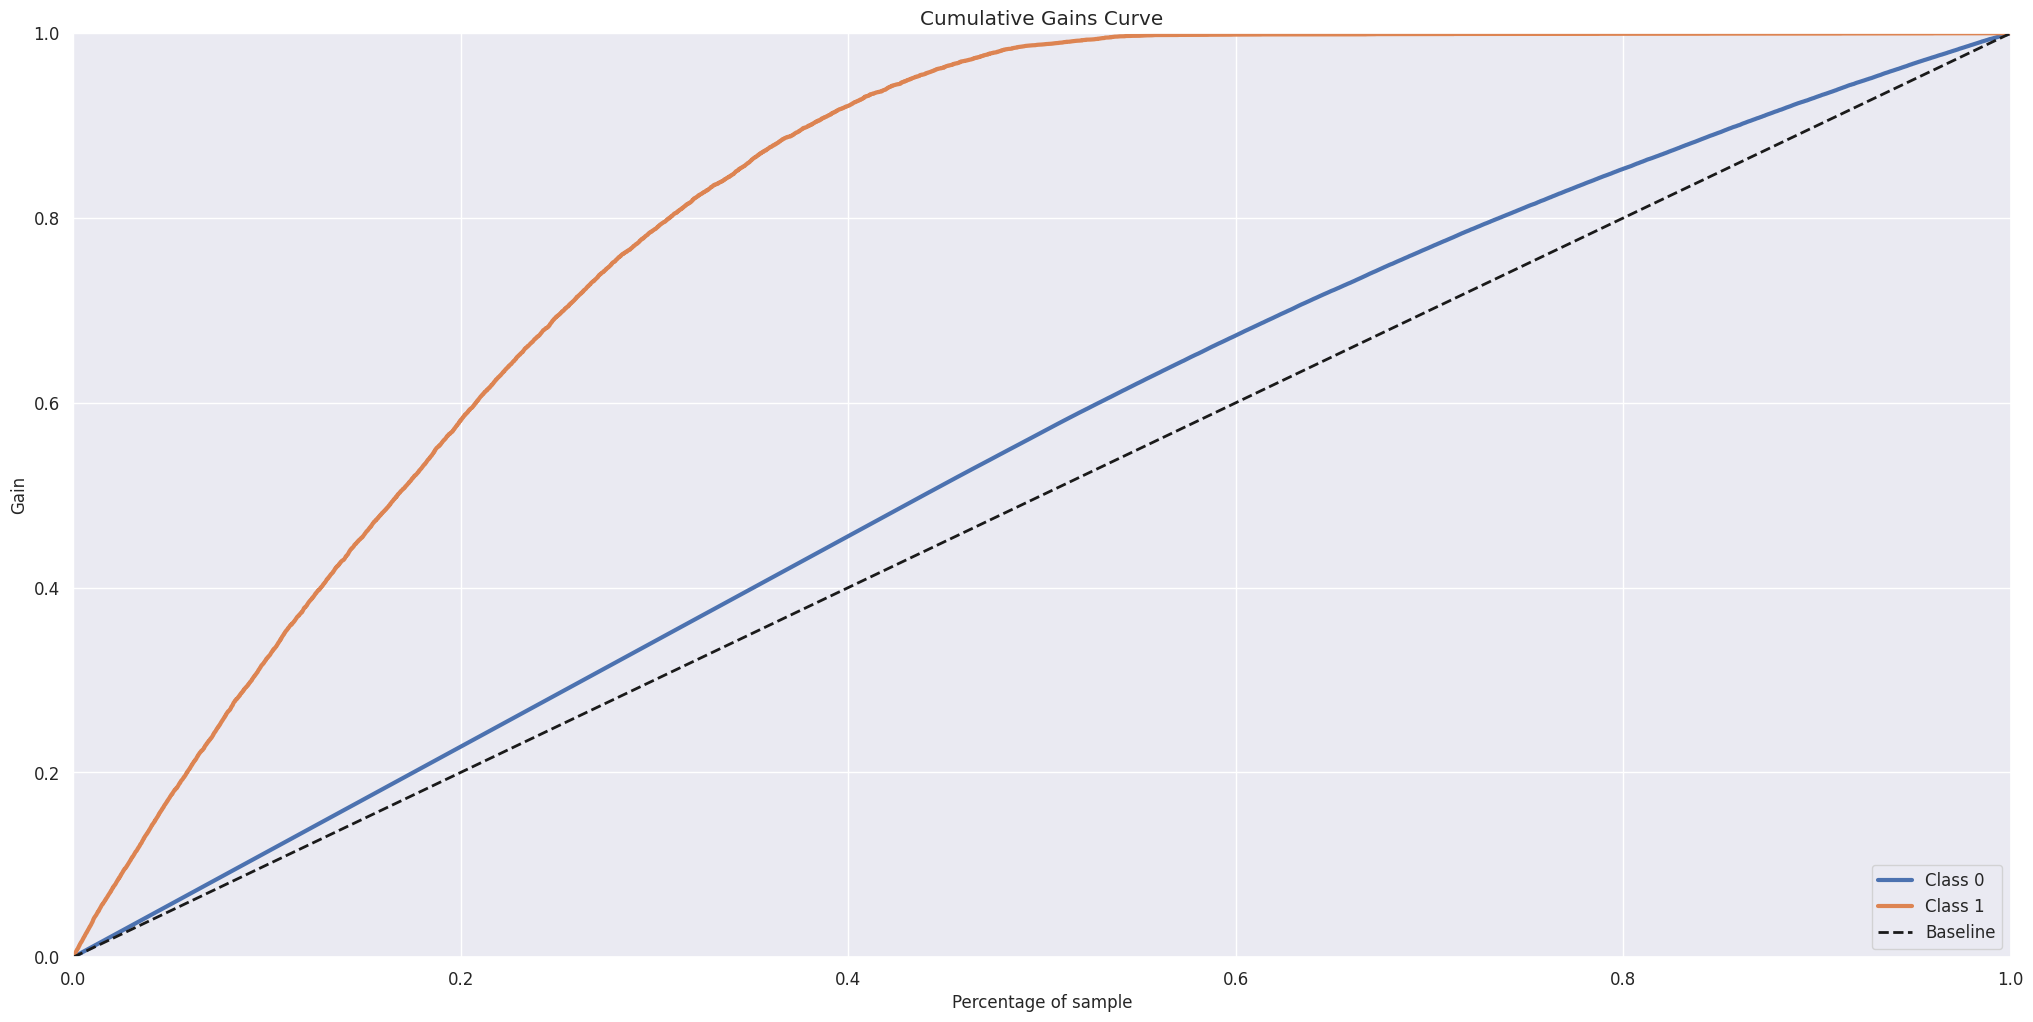

In [137]:
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val, yhat_lgbm_tunned)

Média do annual premium: 31669.0

<AxesSubplot: title={'center': 'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

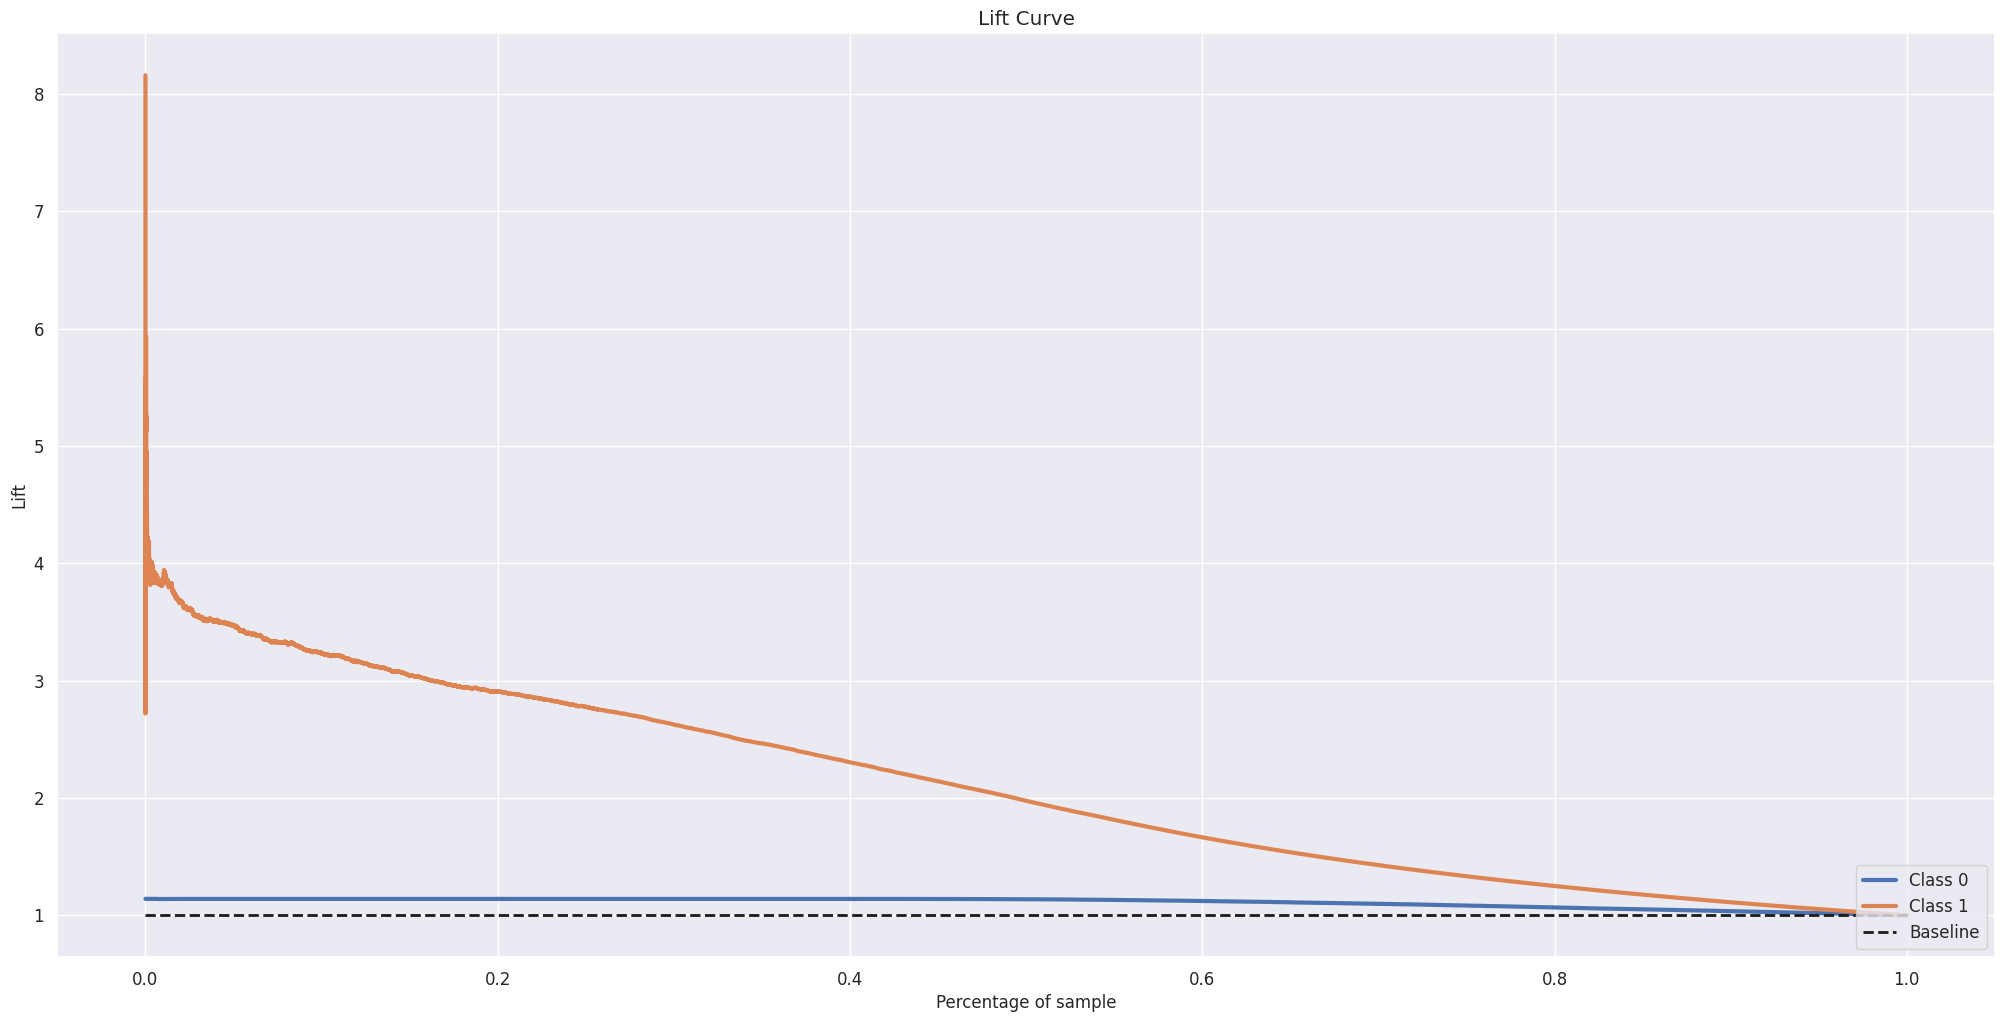

In [138]:
skplt.metrics.plot_lift_curve(y_val, yhat_lgbm_tunned)

In [148]:
20000*100/data_metrics.shape[0]

20.991204685236887

In [141]:
data_metrics['response'].sum()

11678

In [151]:
result_with_model = data_metrics['response'].sum()*0.6055
result_with_model

7071.029

In [152]:
result_random = data_metrics['response'].sum()*0.2099
result_random

2451.2122

In [153]:
result_with_model/result_random

2.884707003334922